<a href="https://colab.research.google.com/github/pabloinsente/CovNet_Human_Drawings/blob/master/code/model_training_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training and hyperparameter optimization for Age-prediction
Here we use Keras and the Talos library to set up the hyperparameter optimization. 

***Warning***: since we are using colab, we need to (1) install talos (2) re-start the running environment (to update some packages that Talos needs to un) before running the optimization.  

In [1]:
!pip install talos

    100% |████████████████████████████████| 51kB 17.9MB/s 
    100% |████████████████████████████████| 778kB 15.8MB/s 
    100% |████████████████████████████████| 12.6MB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/eb/6b/c0/5b58a4767728bb467656ccd70b4fc2e286840c1e8ffa2631ac
  Stored in directory: /root/.cache/pip/wheels/ba/cc/e9/11c6a853d8379f295e17b68f2139ea1bbcd13c5b260822abc7
  Stored in directory: /root/.cache/pip/wheels/61/12/37/957767d4ed95919b90081079c6eb74f83927930e652b30fa93
  Stored in directory: /root/.cache/pip/wheels/36/6b/4c/e1fc6d7d8811940fbea1147b1519c7baa6933e4baeff904433
  Stored in directory: /root/.cache/pip/wheels/ce/ea/67/c7756f897f70f22279c7f2bbf5be52423d85835643042fcc34
Successfully built talos astetik chances kerasplotlib wrangle
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalle

In [1]:
# Let's import Talos, Keras, and dependencies

import talos as ta
from talos.metrics.keras_metrics import fmeasure_acc
from talos.model.normalizers import lr_normalizer

from keras.activations import relu, elu, sigmoid
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import binary_crossentropy, logcosh
from keras.models import Sequential
from keras.layers import Dense, Dropout

from numpy import genfromtxt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Data preparation
First, we need to split the data into training and testing as usual. The training dataset will be feed into the model training and optimization process The testing data will be used to evalute the model. 

In [2]:
# Clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings

Cloning into 'CovNet_Human_Drawings'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 588 (delta 28), reused 23 (delta 9), pack-reused 527
Receiving objects: 100% (588/588), 55.02 MiB | 20.88 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [3]:
# Get data
x_path= 'CovNet_Human_Drawings/data/merged_dataframes_prediction/x_train_drawings_features_max_pool_5_pca.csv'
y_path = 'CovNet_Human_Drawings/data/merged_dataframes_prediction/y_train_age_adult_labels.csv'

x = genfromtxt(x_path, delimiter=',')
y = genfromtxt(y_path, delimiter=',')

print(x.shape) # (258, 200)
print(y.shape) # (258,)

(258, 200)
(258,)


In [4]:
# Split data into train and test sets
# Since we have an small sample, we will do a 70/30 split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=44)
print(x_train.shape) # (180, 200)
print(y_train.shape) # (180,)
print(x_test.shape) # (78, 200)
print(y_test.shape) # (78,)

(180, 200)
(180,)
(78, 200)
(78,)


## Model Definition
Here we define the model using Keras. The main point is to pass all the arguments as keys of a Python dictionary instead of variables

In [0]:
# define model
def input_model(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  # add hidden layer
  model.add(Dense(params['first_neuron'], 
                  input_dim=x_train.shape[1], 
                  activation=params['activation'],
                  kernel_initializer = params['kernel_initializer']))
  # add dropout layer
  model.add(Dropout(params['dropout']))
  # add output layer
  model.add(Dense(1,activation=params['last_activation'],
                  kernel_initializer = params['kernel_initializer']))
  # compile model
  model.compile(loss=params['losses'],
                optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                metrics=['acc', fmeasure_acc])
  # train model
  out = model.fit(x_train, y_train,
                  validation_data=[x_val, y_val],
                  batch_size=params['batch_size'],
                  # 180*.29 = ~52, which is ~20% of all data
                  #val_split = .29, 
                  epochs=params['epochs'])
  return out, model

## Setting the Parameter Space Boundaries 
here we create a dictionary, which will then be passed on to Talos together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

In [0]:
# set hyperparameters to optimize
p = {'first_neuron': [4, 8, 16, 32],
     'activation': [relu, sigmoid],
     'optimizer': [Nadam, Adam],
     'losses':[binary_crossentropy],
     'hidden_layers':[0, 1, 2],
     'batch_size': [10, 20, 30],
     'epochs':[4, 10, 25, 50],
     'dropout': [0, 0.1, 0.2],
     'kernel_initializer': ['uniform','normal'],
     'lr':[0.001, 0.01, 0.1],
     'last_activation': ['sigmoid']}

## Running the hyperparameter optimization with Scan() 
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example. To get started quickly, we're going to invoke the 'grid_downsample' parameter to 5/100 of the entire permutations.



In [7]:
# starting optimization
# with the current hyperparameter space, taking a random sample of 5% will 
# run 518 models
h = ta.Scan(x= x_train, y=y_train,
            params=p,
            model=input_model,
            grid_downsample=.05)

  0%|          | 0/518 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 3s 21ms/step - loss: 0.7016 - acc: 0.1920 - fmeasure_acc: 0.2685 - val_loss: 0.6985 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 261us/step - loss: 0.7015 - acc: 0.1680 - fmeasure_acc: 0.2745 - val_loss: 0.6985 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 249us/step - loss: 0.7022 - acc: 0.1920 - fmeasure_acc: 0.2829 - val_loss: 0.6985 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 220us/step - loss: 0.7012 - acc: 0.1920 - fmeasure_acc: 0.2658 - val_loss: 0.6985 - val_acc: 0.2909 - val_fmeasu

  0%|          | 1/518 [00:03<31:21,  3.64s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.7043 - acc: 0.1680 - fmeasure_acc: 0.2838 - val_loss: 0.7001 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 240us/step - loss: 0.7044 - acc: 0.1680 - fmeasure_acc: 0.2844 - val_loss: 0.7000 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 244us/step - loss: 0.7038 - acc: 0.1680 - fmeasure_acc: 0.2809 - val_loss: 0.7000 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 220us/step - loss: 0.7041 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.6999 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 212us/step - loss: 0.7037 - acc: 0.1680 - fmeasure_acc: 0.2703 - val_loss: 0.6998 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

  0%|          | 2/518 [00:06<28:18,  3.29s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6899 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 667us/step - loss: 0.6898 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6910 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 503us/step - loss: 0.6897 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6909 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 561us/step - loss: 0.6896 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6908 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


  1%|          | 3/518 [00:07<22:14,  2.59s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6852 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6881 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 571us/step - loss: 0.6848 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6878 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 622us/step - loss: 0.6844 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6876 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 547us/step - loss: 0.6840 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6874 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 612us/step - loss: 0.6836 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6871 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

  1%|          | 4/518 [00:08<19:45,  2.31s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4080 - fmeasure_acc: 0.2359 - val_loss: 0.6932 - val_acc: 0.5091 - val_fmeasure_acc: 0.3535
Epoch 2/50
125/125 [==============================] - 0s 553us/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.1897 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.3172
Epoch 3/50
125/125 [==============================] - 0s 612us/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.2161 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.3566
Epoch 4/50
125/125 [==============================] - 0s 558us/step - loss: 0.6931 - acc: 0.5360 - fmeasure_acc: 0.2149 - val_loss: 0.6931 - val_acc: 0.6000 - val_fmeasure_acc: 0.3364
Epoch 5/50
125/125 [==============================] - 0s 625us/step - loss: 0.6931 - acc: 0.5600 - fmeasure_acc: 0.1573 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.3081
Epoch 6/50
125/125 [=================

  1%|          | 5/518 [00:13<25:28,  2.98s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6976 - acc: 0.1680 - fmeasure_acc: 0.2843 - val_loss: 0.6956 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 266us/step - loss: 0.6968 - acc: 0.1680 - fmeasure_acc: 0.2863 - val_loss: 0.6951 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 251us/step - loss: 0.6959 - acc: 0.1680 - fmeasure_acc: 0.2836 - val_loss: 0.6945 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 259us/step - loss: 0.6950 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.6939 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 249us/step - loss: 0.6941 - acc: 0.1680 - fmeasure_acc: 0.2857 - val_loss: 0.6933 - val_acc: 0.2545 - val_fmeasure_acc: 0.4022
Epoch 6/25
125/125 [=================

  1%|          | 6/518 [00:15<22:24,  2.63s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6934 - acc: 0.3440 - fmeasure_acc: 0.2245 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.3776
Epoch 2/4
125/125 [==============================] - 0s 261us/step - loss: 0.6934 - acc: 0.3600 - fmeasure_acc: 0.2361 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.3916
Epoch 3/4
125/125 [==============================] - 0s 252us/step - loss: 0.6934 - acc: 0.3760 - fmeasure_acc: 0.2544 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.3916
Epoch 4/4
125/125 [==============================] - 0s 239us/step - loss: 0.6934 - acc: 0.3920 - fmeasure_acc: 0.2307 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.4000


  1%|▏         | 7/518 [00:16<18:02,  2.12s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6931 - acc: 0.5200 - fmeasure_acc: 0.2107 - val_loss: 0.6932 - val_acc: 0.4000 - val_fmeasure_acc: 0.1948
Epoch 2/10
125/125 [==============================] - 0s 239us/step - loss: 0.6930 - acc: 0.5680 - fmeasure_acc: 0.2120 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.1531
Epoch 3/10
125/125 [==============================] - 0s 248us/step - loss: 0.6930 - acc: 0.6080 - fmeasure_acc: 0.2181 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.1644
Epoch 4/10
125/125 [==============================] - 0s 242us/step - loss: 0.6930 - acc: 0.5920 - fmeasure_acc: 0.2309 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.1644
Epoch 5/10
125/125 [==============================] - 0s 239us/step - loss: 0.6930 - acc: 0.6560 - fmeasure_acc: 0.2626 - val_loss: 0.6931 - val_acc: 0.4727 - val_fmeasure_acc: 0.1711
Epoch 6/10
125/125 [=================

  2%|▏         | 8/518 [00:17<15:26,  1.82s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7040 - acc: 0.1760 - fmeasure_acc: 0.2850 - val_loss: 0.6990 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 335us/step - loss: 0.7034 - acc: 0.1680 - fmeasure_acc: 0.2752 - val_loss: 0.6987 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 269us/step - loss: 0.7026 - acc: 0.1760 - fmeasure_acc: 0.2713 - val_loss: 0.6984 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 280us/step - loss: 0.6995 - acc: 0.2240 - fmeasure_acc: 0.2954 - val_loss: 0.6981 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 267us/step - loss: 0.7001 - acc: 0.2480 - fmeasure_acc: 0.2764 - val_loss: 0.6978 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

  2%|▏         | 9/518 [00:18<14:14,  1.68s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7344 - acc: 0.1680 - fmeasure_acc: 0.2729 - val_loss: 0.7208 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 643us/step - loss: 0.7367 - acc: 0.1680 - fmeasure_acc: 0.2654 - val_loss: 0.7207 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 653us/step - loss: 0.7356 - acc: 0.1680 - fmeasure_acc: 0.2647 - val_loss: 0.7206 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 640us/step - loss: 0.7340 - acc: 0.1680 - fmeasure_acc: 0.2596 - val_loss: 0.7205 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


  2%|▏         | 10/518 [00:19<12:55,  1.53s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7032 - acc: 0.3520 - fmeasure_acc: 0.3249 - val_loss: 0.6990 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/50
125/125 [==============================] - 0s 341us/step - loss: 0.6989 - acc: 0.3600 - fmeasure_acc: 0.3188 - val_loss: 0.6966 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/50
125/125 [==============================] - 0s 368us/step - loss: 0.6991 - acc: 0.3360 - fmeasure_acc: 0.2621 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/50
125/125 [==============================] - 0s 338us/step - loss: 0.6954 - acc: 0.4320 - fmeasure_acc: 0.2098 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 346us/step - loss: 0.6891 - acc: 0.6480 - fmeasure_acc: 0.1559 - val_loss: 0.6891 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=========

  2%|▏         | 11/518 [00:22<17:30,  2.07s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6969 - acc: 0.1920 - fmeasure_acc: 0.2697 - val_loss: 0.6943 - val_acc: 0.2727 - val_fmeasure_acc: 0.4110
Epoch 2/10
125/125 [==============================] - 0s 259us/step - loss: 0.6964 - acc: 0.2320 - fmeasure_acc: 0.2838 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4170
Epoch 3/10
125/125 [==============================] - 0s 251us/step - loss: 0.6960 - acc: 0.2400 - fmeasure_acc: 0.2658 - val_loss: 0.6939 - val_acc: 0.3091 - val_fmeasure_acc: 0.4235
Epoch 4/10
125/125 [==============================] - 0s 267us/step - loss: 0.6956 - acc: 0.2720 - fmeasure_acc: 0.2753 - val_loss: 0.6937 - val_acc: 0.2909 - val_fmeasure_acc: 0.3972
Epoch 5/10
125/125 [==============================] - 0s 253us/step - loss: 0.6951 - acc: 0.2880 - fmeasure_acc: 0.2779 - val_loss: 0.6935 - val_acc: 0.2909 - val_fmeasure_acc: 0.3757
Epoch 6/10
125/125 [=================

  2%|▏         | 12/518 [00:24<14:55,  1.77s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.5760 - fmeasure_acc: 0.2018 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.2447
Epoch 2/10
125/125 [==============================] - 0s 224us/step - loss: 0.6929 - acc: 0.5600 - fmeasure_acc: 0.2382 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.2447
Epoch 3/10
125/125 [==============================] - 0s 242us/step - loss: 0.6929 - acc: 0.5600 - fmeasure_acc: 0.1820 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.2447
Epoch 4/10
125/125 [==============================] - 0s 245us/step - loss: 0.6929 - acc: 0.5760 - fmeasure_acc: 0.1920 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.2447
Epoch 5/10
125/125 [==============================] - 0s 238us/step - loss: 0.6929 - acc: 0.5840 - fmeasure_acc: 0.2174 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.2447
Epoch 6/10
125/125 [=================

  3%|▎         | 13/518 [00:25<13:15,  1.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6961 - acc: 0.4080 - fmeasure_acc: 0.3235 - val_loss: 0.6951 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 275us/step - loss: 0.6984 - acc: 0.3200 - fmeasure_acc: 0.2308 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 260us/step - loss: 0.6953 - acc: 0.3760 - fmeasure_acc: 0.2450 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 343us/step - loss: 0.6947 - acc: 0.3440 - fmeasure_acc: 0.2560 - val_loss: 0.6936 - val_acc: 0.2727 - val_fmeasure_acc: 0.4268
Epoch 5/25
125/125 [==============================] - 0s 302us/step - loss: 0.6935 - acc: 0.3920 - fmeasure_acc: 0.2675 - val_loss: 0.6930 - val_acc: 0.6000 - val_fmeasure_acc: 0.3636
Epoch 6/25
125/125 [=================

  3%|▎         | 14/518 [00:27<14:14,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.5600 - fmeasure_acc: 0.0800 - val_loss: 0.6929 - val_acc: 0.6000 - val_fmeasure_acc: 0.1948
Epoch 2/10
125/125 [==============================] - 0s 337us/step - loss: 0.6921 - acc: 0.6880 - fmeasure_acc: 0.0756 - val_loss: 0.6927 - val_acc: 0.6727 - val_fmeasure_acc: 0.1636
Epoch 3/10
125/125 [==============================] - 0s 318us/step - loss: 0.6919 - acc: 0.7360 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7455 - val_fmeasure_acc: 0.1948
Epoch 4/10
125/125 [==============================] - 0s 331us/step - loss: 0.6914 - acc: 0.8080 - fmeasure_acc: 0.0533 - val_loss: 0.6922 - val_acc: 0.7273 - val_fmeasure_acc: 0.0909
Epoch 5/10
125/125 [==============================] - 0s 331us/step - loss: 0.6909 - acc: 0.8320 - fmeasure_acc: 0.0640 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=========

  3%|▎         | 15/518 [00:28<13:03,  1.56s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6828 - acc: 0.7680 - fmeasure_acc: 0.1067 - val_loss: 0.6863 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 252us/step - loss: 0.6820 - acc: 0.7760 - fmeasure_acc: 0.2385 - val_loss: 0.6860 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 328us/step - loss: 0.6818 - acc: 0.7600 - fmeasure_acc: 0.1272 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 259us/step - loss: 0.6805 - acc: 0.7920 - fmeasure_acc: 0.1333 - val_loss: 0.6855 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


  3%|▎         | 16/518 [00:29<11:55,  1.43s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6925 - acc: 0.7520 - fmeasure_acc: 0.1333 - val_loss: 0.6924 - val_acc: 0.7636 - val_fmeasure_acc: 0.2975
Epoch 2/25
125/125 [==============================] - 0s 266us/step - loss: 0.6921 - acc: 0.8320 - fmeasure_acc: 0.1733 - val_loss: 0.6921 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212
Epoch 3/25
125/125 [==============================] - 0s 262us/step - loss: 0.6917 - acc: 0.8320 - fmeasure_acc: 0.0600 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 259us/step - loss: 0.6912 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 258us/step - loss: 0.6908 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

  3%|▎         | 17/518 [00:31<12:25,  1.49s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6926 - acc: 0.6560 - fmeasure_acc: 0.0720 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2778
Epoch 2/25
125/125 [==============================] - 0s 320us/step - loss: 0.6926 - acc: 0.6560 - fmeasure_acc: 0.0587 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2778
Epoch 3/25
125/125 [==============================] - 0s 297us/step - loss: 0.6926 - acc: 0.6560 - fmeasure_acc: 0.0756 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2778
Epoch 4/25
125/125 [==============================] - 0s 307us/step - loss: 0.6926 - acc: 0.6560 - fmeasure_acc: 0.0720 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2778
Epoch 5/25
125/125 [==============================] - 0s 316us/step - loss: 0.6926 - acc: 0.6560 - fmeasure_acc: 0.0756 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2778
Epoch 6/25
125/125 [=================

  3%|▎         | 18/518 [00:32<13:06,  1.57s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6921 - acc: 0.7840 - fmeasure_acc: 0.1813 - val_loss: 0.6924 - val_acc: 0.6727 - val_fmeasure_acc: 0.1515
Epoch 2/50
125/125 [==============================] - 0s 273us/step - loss: 0.6921 - acc: 0.7840 - fmeasure_acc: 0.1547 - val_loss: 0.6924 - val_acc: 0.6727 - val_fmeasure_acc: 0.1515
Epoch 3/50
125/125 [==============================] - 0s 259us/step - loss: 0.6921 - acc: 0.7840 - fmeasure_acc: 0.1699 - val_loss: 0.6924 - val_acc: 0.6727 - val_fmeasure_acc: 0.1515
Epoch 4/50
125/125 [==============================] - 0s 301us/step - loss: 0.6920 - acc: 0.7840 - fmeasure_acc: 0.1752 - val_loss: 0.6924 - val_acc: 0.6909 - val_fmeasure_acc: 0.1653
Epoch 5/50
125/125 [==============================] - 0s 250us/step - loss: 0.6920 - acc: 0.7840 - fmeasure_acc: 0.2133 - val_loss: 0.6924 - val_acc: 0.6909 - val_fmeasure_acc: 0.1653
Epoch 6/50
125/125 [=================

  4%|▎         | 19/518 [00:35<15:52,  1.91s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7436 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.7254 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/50
125/125 [==============================] - 0s 328us/step - loss: 0.7443 - acc: 0.1680 - fmeasure_acc: 0.2823 - val_loss: 0.7251 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/50
125/125 [==============================] - 0s 332us/step - loss: 0.7438 - acc: 0.1680 - fmeasure_acc: 0.2810 - val_loss: 0.7248 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/50
125/125 [==============================] - 0s 319us/step - loss: 0.7407 - acc: 0.1680 - fmeasure_acc: 0.2687 - val_loss: 0.7245 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/50
125/125 [==============================] - 0s 416us/step - loss: 0.7408 - acc: 0.1680 - fmeasure_acc: 0.2852 - val_loss: 0.7242 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/50
125/125 [=================

  4%|▍         | 20/518 [00:38<18:33,  2.24s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.8000 - fmeasure_acc: 0.0800 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0727
Epoch 2/50
125/125 [==============================] - 0s 642us/step - loss: 0.6918 - acc: 0.7920 - fmeasure_acc: 0.0720 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.0727
Epoch 3/50
125/125 [==============================] - 0s 731us/step - loss: 0.6917 - acc: 0.8080 - fmeasure_acc: 0.0320 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 680us/step - loss: 0.6915 - acc: 0.8080 - fmeasure_acc: 0.0267 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 633us/step - loss: 0.6914 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=

  4%|▍         | 21/518 [00:43<25:08,  3.04s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6964 - acc: 0.1680 - fmeasure_acc: 0.2804 - val_loss: 0.6953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 309us/step - loss: 0.6962 - acc: 0.1680 - fmeasure_acc: 0.2756 - val_loss: 0.6953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 336us/step - loss: 0.6961 - acc: 0.1680 - fmeasure_acc: 0.2772 - val_loss: 0.6952 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 311us/step - loss: 0.6960 - acc: 0.1680 - fmeasure_acc: 0.2822 - val_loss: 0.6951 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


  4%|▍         | 22/518 [00:44<20:18,  2.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6904 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 313us/step - loss: 0.6902 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 312us/step - loss: 0.6900 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 305us/step - loss: 0.6898 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6910 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 314us/step - loss: 0.6896 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6908 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

  4%|▍         | 23/518 [00:47<21:11,  2.57s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6797 - acc: 0.7760 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6844 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 256us/step - loss: 0.6783 - acc: 0.8000 - fmeasure_acc: 0.0800 - val_loss: 0.6841 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 256us/step - loss: 0.6783 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6838 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 249us/step - loss: 0.6775 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6835 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


  5%|▍         | 24/518 [00:48<17:37,  2.14s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.7680 - fmeasure_acc: 0.0533 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 338us/step - loss: 0.6924 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 336us/step - loss: 0.6920 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 337us/step - loss: 0.6915 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 345us/step - loss: 0.6910 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

  5%|▍         | 25/518 [00:50<16:52,  2.05s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.4960 - fmeasure_acc: 0.2305 - val_loss: 0.6919 - val_acc: 0.6364 - val_fmeasure_acc: 0.2879
Epoch 2/50
125/125 [==============================] - 0s 552us/step - loss: 0.6919 - acc: 0.5920 - fmeasure_acc: 0.2276 - val_loss: 0.6913 - val_acc: 0.6545 - val_fmeasure_acc: 0.2394
Epoch 3/50
125/125 [==============================] - 0s 556us/step - loss: 0.6909 - acc: 0.6880 - fmeasure_acc: 0.1844 - val_loss: 0.6908 - val_acc: 0.6727 - val_fmeasure_acc: 0.1939
Epoch 4/50
125/125 [==============================] - 0s 546us/step - loss: 0.6898 - acc: 0.7600 - fmeasure_acc: 0.2282 - val_loss: 0.6902 - val_acc: 0.6727 - val_fmeasure_acc: 0.1636
Epoch 5/50
125/125 [==============================] - 0s 529us/step - loss: 0.6887 - acc: 0.7760 - fmeasure_acc: 0.1333 - val_loss: 0.6896 - val_acc: 0.6727 - val_fmeasure_acc: 0.0519
Epoch 6/50
125/125 [=================

  5%|▌         | 26/518 [00:54<22:14,  2.71s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6864 - acc: 0.7360 - fmeasure_acc: 0.0720 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 533us/step - loss: 0.6849 - acc: 0.8240 - fmeasure_acc: 0.0600 - val_loss: 0.6884 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 536us/step - loss: 0.6855 - acc: 0.8080 - fmeasure_acc: 0.1200 - val_loss: 0.6883 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 614us/step - loss: 0.6852 - acc: 0.8240 - fmeasure_acc: 0.1467 - val_loss: 0.6882 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 547us/step - loss: 0.6853 - acc: 0.8320 - fmeasure_acc: 0.0320 - val_loss: 0.6882 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/12

  5%|▌         | 27/518 [00:59<27:06,  3.31s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6910 - acc: 0.8400 - fmeasure_acc: 0.0320 - val_loss: 0.6922 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212
Epoch 2/4
125/125 [==============================] - 0s 564us/step - loss: 0.6911 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212
Epoch 3/4
125/125 [==============================] - 0s 631us/step - loss: 0.6910 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212
Epoch 4/4
125/125 [==============================] - 0s 531us/step - loss: 0.6910 - acc: 0.8400 - fmeasure_acc: 0.0267 - val_loss: 0.6922 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212


  5%|▌         | 28/518 [01:00<21:39,  2.65s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7084 - acc: 0.1680 - fmeasure_acc: 0.2742 - val_loss: 0.7028 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 559us/step - loss: 0.7083 - acc: 0.1680 - fmeasure_acc: 0.2729 - val_loss: 0.7028 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 554us/step - loss: 0.7083 - acc: 0.1680 - fmeasure_acc: 0.2711 - val_loss: 0.7027 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 540us/step - loss: 0.7083 - acc: 0.1680 - fmeasure_acc: 0.2666 - val_loss: 0.7027 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/25
125/125 [==============================] - 0s 554us/step - loss: 0.7083 - acc: 0.1680 - fmeasure_acc: 0.2629 - val_loss: 0.7027 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/25
125/125 [=================

  6%|▌         | 29/518 [01:03<21:28,  2.64s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6908 - acc: 0.7280 - fmeasure_acc: 0.0933 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 584us/step - loss: 0.6905 - acc: 0.7440 - fmeasure_acc: 0.1573 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 604us/step - loss: 0.6904 - acc: 0.7280 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 605us/step - loss: 0.6902 - acc: 0.7280 - fmeasure_acc: 0.1440 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


  6%|▌         | 30/518 [01:04<18:09,  2.23s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6814 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 255us/step - loss: 0.6813 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6857 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 249us/step - loss: 0.6813 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6857 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 238us/step - loss: 0.6812 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6857 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 235us/step - loss: 0.6812 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6856 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

  6%|▌         | 31/518 [01:05<15:13,  1.88s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.5040 - fmeasure_acc: 0.2146 - val_loss: 0.6937 - val_acc: 0.3091 - val_fmeasure_acc: 0.2687
Epoch 2/50
125/125 [==============================] - 0s 548us/step - loss: 0.6930 - acc: 0.5680 - fmeasure_acc: 0.3109 - val_loss: 0.6937 - val_acc: 0.3273 - val_fmeasure_acc: 0.2747
Epoch 3/50
125/125 [==============================] - 0s 566us/step - loss: 0.6929 - acc: 0.5840 - fmeasure_acc: 0.2487 - val_loss: 0.6936 - val_acc: 0.3273 - val_fmeasure_acc: 0.2747
Epoch 4/50
125/125 [==============================] - 0s 558us/step - loss: 0.6927 - acc: 0.5920 - fmeasure_acc: 0.2758 - val_loss: 0.6936 - val_acc: 0.3636 - val_fmeasure_acc: 0.2479
Epoch 5/50
125/125 [==============================] - 0s 555us/step - loss: 0.6927 - acc: 0.6080 - fmeasure_acc: 0.2650 - val_loss: 0.6936 - val_acc: 0.3818 - val_fmeasure_acc: 0.2580
Epoch 6/50
125/125 [=================

  6%|▌         | 32/518 [01:10<21:55,  2.71s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6931 - acc: 0.5440 - fmeasure_acc: 0.2648 - val_loss: 0.6929 - val_acc: 0.6182 - val_fmeasure_acc: 0.3240
Epoch 2/4
125/125 [==============================] - 0s 344us/step - loss: 0.6931 - acc: 0.5920 - fmeasure_acc: 0.2739 - val_loss: 0.6929 - val_acc: 0.6182 - val_fmeasure_acc: 0.2755
Epoch 3/4
125/125 [==============================] - 0s 337us/step - loss: 0.6931 - acc: 0.6400 - fmeasure_acc: 0.3057 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.2848
Epoch 4/4
125/125 [==============================] - 0s 354us/step - loss: 0.6930 - acc: 0.6400 - fmeasure_acc: 0.2121 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.2848


  6%|▋         | 33/518 [01:11<17:36,  2.18s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6938 - acc: 0.2080 - fmeasure_acc: 0.2735 - val_loss: 0.6934 - val_acc: 0.3818 - val_fmeasure_acc: 0.4795
Epoch 2/4
125/125 [==============================] - 0s 324us/step - loss: 0.6935 - acc: 0.3840 - fmeasure_acc: 0.2894 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4822
Epoch 3/4
125/125 [==============================] - 0s 321us/step - loss: 0.6932 - acc: 0.5360 - fmeasure_acc: 0.2801 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.4560
Epoch 4/4
125/125 [==============================] - 0s 327us/step - loss: 0.6930 - acc: 0.6320 - fmeasure_acc: 0.2178 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.4231


  7%|▋         | 34/518 [01:11<14:38,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7059 - acc: 0.2000 - fmeasure_acc: 0.2799 - val_loss: 0.7014 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 649us/step - loss: 0.7072 - acc: 0.1840 - fmeasure_acc: 0.2512 - val_loss: 0.7013 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 621us/step - loss: 0.7063 - acc: 0.1920 - fmeasure_acc: 0.2736 - val_loss: 0.7013 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 635us/step - loss: 0.7061 - acc: 0.1920 - fmeasure_acc: 0.2583 - val_loss: 0.7013 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


  7%|▋         | 35/518 [01:13<13:33,  1.68s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6876 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6892 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 268us/step - loss: 0.6864 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 253us/step - loss: 0.6851 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6876 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 253us/step - loss: 0.6837 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6866 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 257us/step - loss: 0.6821 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6857 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

  7%|▋         | 36/518 [01:15<15:25,  1.92s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 1s 4ms/step - loss: 0.7366 - acc: 0.1680 - fmeasure_acc: 0.2832 - val_loss: 0.7189 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 342us/step - loss: 0.7338 - acc: 0.1680 - fmeasure_acc: 0.2766 - val_loss: 0.7176 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 342us/step - loss: 0.7301 - acc: 0.1680 - fmeasure_acc: 0.2828 - val_loss: 0.7162 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 346us/step - loss: 0.7304 - acc: 0.1680 - fmeasure_acc: 0.2778 - val_loss: 0.7147 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


  7%|▋         | 37/518 [01:17<13:44,  1.71s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6600 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6733 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 322us/step - loss: 0.6635 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6732 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 328us/step - loss: 0.6582 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6731 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 333us/step - loss: 0.6596 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6730 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 357us/step - loss: 0.6568 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6729 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

  7%|▋         | 38/518 [01:18<14:04,  1.76s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6936 - acc: 0.2400 - fmeasure_acc: 0.2545 - val_loss: 0.6934 - val_acc: 0.2909 - val_fmeasure_acc: 0.3748
Epoch 2/50
125/125 [==============================] - 0s 636us/step - loss: 0.6936 - acc: 0.2240 - fmeasure_acc: 0.2472 - val_loss: 0.6934 - val_acc: 0.2909 - val_fmeasure_acc: 0.3505
Epoch 3/50
125/125 [==============================] - 0s 628us/step - loss: 0.6936 - acc: 0.2080 - fmeasure_acc: 0.2403 - val_loss: 0.6934 - val_acc: 0.2909 - val_fmeasure_acc: 0.3505
Epoch 4/50
125/125 [==============================] - 0s 619us/step - loss: 0.6936 - acc: 0.2320 - fmeasure_acc: 0.2446 - val_loss: 0.6934 - val_acc: 0.2909 - val_fmeasure_acc: 0.3505
Epoch 5/50
125/125 [==============================] - 0s 642us/step - loss: 0.6935 - acc: 0.2480 - fmeasure_acc: 0.2495 - val_loss: 0.6934 - val_acc: 0.2909 - val_fmeasure_acc: 0.3505
Epoch 6/50
125/125 [=================

  8%|▊         | 39/518 [01:23<21:21,  2.68s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7061 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.7009 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 256us/step - loss: 0.7055 - acc: 0.1760 - fmeasure_acc: 0.2876 - val_loss: 0.7006 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 235us/step - loss: 0.7050 - acc: 0.1760 - fmeasure_acc: 0.2738 - val_loss: 0.7002 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 265us/step - loss: 0.7033 - acc: 0.1760 - fmeasure_acc: 0.2886 - val_loss: 0.7000 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 263us/step - loss: 0.7044 - acc: 0.1680 - fmeasure_acc: 0.2431 - val_loss: 0.6996 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

  8%|▊         | 40/518 [01:26<21:34,  2.71s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4880 - fmeasure_acc: 0.2228 - val_loss: 0.6934 - val_acc: 0.2909 - val_fmeasure_acc: 0.4260
Epoch 2/4
125/125 [==============================] - 0s 576us/step - loss: 0.6937 - acc: 0.5200 - fmeasure_acc: 0.2712 - val_loss: 0.6934 - val_acc: 0.2727 - val_fmeasure_acc: 0.4060
Epoch 3/4
125/125 [==============================] - 0s 576us/step - loss: 0.6916 - acc: 0.5040 - fmeasure_acc: 0.2686 - val_loss: 0.6934 - val_acc: 0.2727 - val_fmeasure_acc: 0.4060
Epoch 4/4
125/125 [==============================] - 0s 560us/step - loss: 0.6928 - acc: 0.5280 - fmeasure_acc: 0.2455 - val_loss: 0.6934 - val_acc: 0.3091 - val_fmeasure_acc: 0.4185


  8%|▊         | 41/518 [01:27<17:43,  2.23s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6920 - acc: 0.7120 - fmeasure_acc: 0.1013 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.1653
Epoch 2/4
125/125 [==============================] - 0s 226us/step - loss: 0.6919 - acc: 0.7360 - fmeasure_acc: 0.1867 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.1653
Epoch 3/4
125/125 [==============================] - 0s 247us/step - loss: 0.6918 - acc: 0.7600 - fmeasure_acc: 0.1877 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.1653
Epoch 4/4
125/125 [==============================] - 0s 248us/step - loss: 0.6918 - acc: 0.7360 - fmeasure_acc: 0.1741 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.1653


  8%|▊         | 42/518 [01:28<14:34,  1.84s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6923 - acc: 0.5840 - fmeasure_acc: 0.2007 - val_loss: 0.6926 - val_acc: 0.6364 - val_fmeasure_acc: 0.3887
Epoch 2/50
125/125 [==============================] - 0s 573us/step - loss: 0.6915 - acc: 0.7040 - fmeasure_acc: 0.2155 - val_loss: 0.6922 - val_acc: 0.6909 - val_fmeasure_acc: 0.4009
Epoch 3/50
125/125 [==============================] - 0s 556us/step - loss: 0.6908 - acc: 0.7280 - fmeasure_acc: 0.0990 - val_loss: 0.6918 - val_acc: 0.6364 - val_fmeasure_acc: 0.0606
Epoch 4/50
125/125 [==============================] - 0s 551us/step - loss: 0.6900 - acc: 0.7840 - fmeasure_acc: 0.1333 - val_loss: 0.6914 - val_acc: 0.6909 - val_fmeasure_acc: 0.0606
Epoch 5/50
125/125 [==============================] - 0s 534us/step - loss: 0.6893 - acc: 0.8240 - fmeasure_acc: 0.0720 - val_loss: 0.6910 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=============

  8%|▊         | 43/518 [01:33<20:47,  2.63s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6939 - acc: 0.3600 - fmeasure_acc: 0.1980 - val_loss: 0.6939 - val_acc: 0.3091 - val_fmeasure_acc: 0.2407
Epoch 2/50
125/125 [==============================] - 0s 252us/step - loss: 0.6939 - acc: 0.3600 - fmeasure_acc: 0.1961 - val_loss: 0.6939 - val_acc: 0.3091 - val_fmeasure_acc: 0.2407
Epoch 3/50
125/125 [==============================] - 0s 254us/step - loss: 0.6939 - acc: 0.3600 - fmeasure_acc: 0.2039 - val_loss: 0.6939 - val_acc: 0.3091 - val_fmeasure_acc: 0.2407
Epoch 4/50
125/125 [==============================] - 0s 267us/step - loss: 0.6938 - acc: 0.3600 - fmeasure_acc: 0.1995 - val_loss: 0.6939 - val_acc: 0.3273 - val_fmeasure_acc: 0.2443
Epoch 5/50
125/125 [==============================] - 0s 249us/step - loss: 0.6938 - acc: 0.3600 - fmeasure_acc: 0.1932 - val_loss: 0.6939 - val_acc: 0.3273 - val_fmeasure_acc: 0.2443
Epoch 6/50
125/125 [=================

  8%|▊         | 44/518 [01:35<20:27,  2.59s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6855 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6882 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 255us/step - loss: 0.6853 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6880 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 263us/step - loss: 0.6850 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6879 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 254us/step - loss: 0.6848 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6877 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 263us/step - loss: 0.6845 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6876 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

  9%|▊         | 45/518 [01:37<18:31,  2.35s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6732 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6807 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 648us/step - loss: 0.6730 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6806 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 523us/step - loss: 0.6728 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6805 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 601us/step - loss: 0.6726 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6804 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 527us/step - loss: 0.6724 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6803 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

  9%|▉         | 46/518 [01:38<16:20,  2.08s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7060 - acc: 0.1680 - fmeasure_acc: 0.2807 - val_loss: 0.7004 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 353us/step - loss: 0.7039 - acc: 0.1920 - fmeasure_acc: 0.2697 - val_loss: 0.6997 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 359us/step - loss: 0.7027 - acc: 0.1680 - fmeasure_acc: 0.2771 - val_loss: 0.6989 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 355us/step - loss: 0.7011 - acc: 0.1840 - fmeasure_acc: 0.2841 - val_loss: 0.6981 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


  9%|▉         | 47/518 [01:39<13:50,  1.76s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6943 - acc: 0.3840 - fmeasure_acc: 0.2544 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.3382
Epoch 2/4
125/125 [==============================] - 0s 244us/step - loss: 0.6945 - acc: 0.3760 - fmeasure_acc: 0.2719 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.3382
Epoch 3/4
125/125 [==============================] - 0s 244us/step - loss: 0.6944 - acc: 0.4000 - fmeasure_acc: 0.2606 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.3382
Epoch 4/4
125/125 [==============================] - 0s 243us/step - loss: 0.6943 - acc: 0.4160 - fmeasure_acc: 0.2937 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.3382


  9%|▉         | 48/518 [01:40<12:21,  1.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.6720 - fmeasure_acc: 0.1606 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.2567
Epoch 2/50
125/125 [==============================] - 0s 286us/step - loss: 0.6926 - acc: 0.6800 - fmeasure_acc: 0.1813 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.2182
Epoch 3/50
125/125 [==============================] - 0s 267us/step - loss: 0.6924 - acc: 0.6640 - fmeasure_acc: 0.1122 - val_loss: 0.6928 - val_acc: 0.6182 - val_fmeasure_acc: 0.1678
Epoch 4/50
125/125 [==============================] - 0s 272us/step - loss: 0.6922 - acc: 0.6960 - fmeasure_acc: 0.2527 - val_loss: 0.6928 - val_acc: 0.6182 - val_fmeasure_acc: 0.1678
Epoch 5/50
125/125 [==============================] - 0s 258us/step - loss: 0.6923 - acc: 0.7280 - fmeasure_acc: 0.1358 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.1678
Epoch 6/50
125/125 [=================

  9%|▉         | 49/518 [01:43<14:44,  1.89s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6868 - acc: 0.7920 - fmeasure_acc: 0.2267 - val_loss: 0.6892 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 640us/step - loss: 0.6863 - acc: 0.7440 - fmeasure_acc: 0.0857 - val_loss: 0.6891 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 594us/step - loss: 0.6871 - acc: 0.7440 - fmeasure_acc: 0.1111 - val_loss: 0.6890 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 553us/step - loss: 0.6856 - acc: 0.7440 - fmeasure_acc: 0.1257 - val_loss: 0.6889 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 547us/step - loss: 0.6846 - acc: 0.8080 - fmeasure_acc: 0.1653 - val_loss: 0.6889 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 10%|▉         | 50/518 [01:45<14:19,  1.84s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6708 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6791 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 655us/step - loss: 0.6696 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6778 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 708us/step - loss: 0.6675 - acc: 0.8400 - fmeasure_acc: 0.0800 - val_loss: 0.6764 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 608us/step - loss: 0.6644 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6750 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 10%|▉         | 51/518 [01:46<12:47,  1.64s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6750 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6822 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 278us/step - loss: 0.6744 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6822 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 286us/step - loss: 0.6748 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6821 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 294us/step - loss: 0.6755 - acc: 0.8080 - fmeasure_acc: 0.0160 - val_loss: 0.6820 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 257us/step - loss: 0.6742 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6819 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 10%|█         | 52/518 [01:47<11:42,  1.51s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6930 - acc: 0.5760 - fmeasure_acc: 0.2064 - val_loss: 0.6929 - val_acc: 0.5818 - val_fmeasure_acc: 0.2667
Epoch 2/10
125/125 [==============================] - 0s 312us/step - loss: 0.6926 - acc: 0.7120 - fmeasure_acc: 0.1497 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.1847
Epoch 3/10
125/125 [==============================] - 0s 306us/step - loss: 0.6923 - acc: 0.7520 - fmeasure_acc: 0.0949 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0909
Epoch 4/10
125/125 [==============================] - 0s 337us/step - loss: 0.6920 - acc: 0.8000 - fmeasure_acc: 0.0457 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 326us/step - loss: 0.6916 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=====

 10%|█         | 53/518 [01:49<11:20,  1.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6448 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6640 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 311us/step - loss: 0.6447 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6640 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 313us/step - loss: 0.6447 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6640 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 323us/step - loss: 0.6447 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6640 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 10%|█         | 54/518 [01:49<09:59,  1.29s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6973 - acc: 0.3040 - fmeasure_acc: 0.2478 - val_loss: 0.6955 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 608us/step - loss: 0.6958 - acc: 0.3360 - fmeasure_acc: 0.2862 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 554us/step - loss: 0.6941 - acc: 0.3680 - fmeasure_acc: 0.2654 - val_loss: 0.6929 - val_acc: 0.7818 - val_fmeasure_acc: 0.3983
Epoch 4/25
125/125 [==============================] - 0s 551us/step - loss: 0.6921 - acc: 0.6480 - fmeasure_acc: 0.1082 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 535us/step - loss: 0.6898 - acc: 0.6960 - fmeasure_acc: 0.0853 - val_loss: 0.6904 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=========

 11%|█         | 55/518 [01:52<13:01,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.7125 - acc: 0.1680 - fmeasure_acc: 0.2751 - val_loss: 0.7055 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 312us/step - loss: 0.7124 - acc: 0.1680 - fmeasure_acc: 0.2785 - val_loss: 0.7055 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 327us/step - loss: 0.7124 - acc: 0.1680 - fmeasure_acc: 0.2799 - val_loss: 0.7055 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 403us/step - loss: 0.7123 - acc: 0.1680 - fmeasure_acc: 0.2804 - val_loss: 0.7054 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/25
125/125 [==============================] - 0s 343us/step - loss: 0.7123 - acc: 0.1680 - fmeasure_acc: 0.2725 - val_loss: 0.7054 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/25
125/125 [=================

 11%|█         | 56/518 [01:54<13:36,  1.77s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7407 - acc: 0.1680 - fmeasure_acc: 0.2687 - val_loss: 0.7233 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/10
125/125 [==============================] - 0s 657us/step - loss: 0.7382 - acc: 0.1680 - fmeasure_acc: 0.2763 - val_loss: 0.7230 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/10
125/125 [==============================] - 0s 646us/step - loss: 0.7392 - acc: 0.1680 - fmeasure_acc: 0.2729 - val_loss: 0.7227 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/10
125/125 [==============================] - 0s 722us/step - loss: 0.7378 - acc: 0.1680 - fmeasure_acc: 0.2737 - val_loss: 0.7224 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/10
125/125 [==============================] - 0s 653us/step - loss: 0.7391 - acc: 0.1680 - fmeasure_acc: 0.2775 - val_loss: 0.7221 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/10
125/125 [=================

 11%|█         | 57/518 [01:56<13:21,  1.74s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5760 - fmeasure_acc: 0.1609 - val_loss: 0.6930 - val_acc: 0.6364 - val_fmeasure_acc: 0.1666
Epoch 2/25
125/125 [==============================] - 0s 249us/step - loss: 0.6928 - acc: 0.7840 - fmeasure_acc: 0.1000 - val_loss: 0.6928 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 269us/step - loss: 0.6925 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 300us/step - loss: 0.6922 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 262us/step - loss: 0.6919 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/2

 11%|█         | 58/518 [01:58<13:42,  1.79s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6741 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6811 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 317us/step - loss: 0.6735 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6807 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 339us/step - loss: 0.6728 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6803 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 327us/step - loss: 0.6721 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6798 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 362us/step - loss: 0.6713 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6794 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 11%|█▏        | 59/518 [02:00<16:19,  2.13s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6207 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6485 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 627us/step - loss: 0.6154 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6455 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 681us/step - loss: 0.6099 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6425 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 655us/step - loss: 0.6043 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6396 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 615us/step - loss: 0.5988 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6370 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 12%|█▏        | 60/518 [02:02<14:56,  1.96s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6922 - acc: 0.6960 - fmeasure_acc: 0.1579 - val_loss: 0.6928 - val_acc: 0.5455 - val_fmeasure_acc: 0.0642
Epoch 2/50
125/125 [==============================] - 0s 250us/step - loss: 0.6922 - acc: 0.6960 - fmeasure_acc: 0.1120 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.0727
Epoch 3/50
125/125 [==============================] - 0s 243us/step - loss: 0.6921 - acc: 0.6960 - fmeasure_acc: 0.1333 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.0727
Epoch 4/50
125/125 [==============================] - 0s 250us/step - loss: 0.6921 - acc: 0.6960 - fmeasure_acc: 0.1309 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.0727
Epoch 5/50
125/125 [==============================] - 0s 246us/step - loss: 0.6920 - acc: 0.7360 - fmeasure_acc: 0.1316 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.0779
Epoch 6/50
125/125 [=================

 12%|█▏        | 61/518 [02:05<16:31,  2.17s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6935 - acc: 0.5280 - fmeasure_acc: 0.2620 - val_loss: 0.6936 - val_acc: 0.4182 - val_fmeasure_acc: 0.3052
Epoch 2/50
125/125 [==============================] - 0s 356us/step - loss: 0.6936 - acc: 0.4880 - fmeasure_acc: 0.2268 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3122
Epoch 3/50
125/125 [==============================] - 0s 336us/step - loss: 0.6935 - acc: 0.5200 - fmeasure_acc: 0.2942 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3122
Epoch 4/50
125/125 [==============================] - 0s 352us/step - loss: 0.6936 - acc: 0.4880 - fmeasure_acc: 0.2358 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3122
Epoch 5/50
125/125 [==============================] - 0s 340us/step - loss: 0.6935 - acc: 0.5200 - fmeasure_acc: 0.2763 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3122
Epoch 6/50
125/125 [=================

 12%|█▏        | 62/518 [02:08<18:40,  2.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6860 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6886 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 530us/step - loss: 0.6859 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 542us/step - loss: 0.6859 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 517us/step - loss: 0.6858 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6884 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 528us/step - loss: 0.6857 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6884 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 12%|█▏        | 63/518 [02:10<19:03,  2.51s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.2240 - fmeasure_acc: 0.2672 - val_loss: 0.6933 - val_acc: 0.2909 - val_fmeasure_acc: 0.4170
Epoch 2/25
125/125 [==============================] - 0s 260us/step - loss: 0.6933 - acc: 0.2480 - fmeasure_acc: 0.2467 - val_loss: 0.6933 - val_acc: 0.3273 - val_fmeasure_acc: 0.4303
Epoch 3/25
125/125 [==============================] - 0s 264us/step - loss: 0.6933 - acc: 0.2720 - fmeasure_acc: 0.2797 - val_loss: 0.6933 - val_acc: 0.3273 - val_fmeasure_acc: 0.4303
Epoch 4/25
125/125 [==============================] - 0s 244us/step - loss: 0.6933 - acc: 0.3280 - fmeasure_acc: 0.2799 - val_loss: 0.6932 - val_acc: 0.3636 - val_fmeasure_acc: 0.4435
Epoch 5/25
125/125 [==============================] - 0s 245us/step - loss: 0.6933 - acc: 0.3680 - fmeasure_acc: 0.2638 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.4566
Epoch 6/25
125/125 [=================

 12%|█▏        | 64/518 [02:12<17:02,  2.25s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6966 - acc: 0.3280 - fmeasure_acc: 0.2916 - val_loss: 0.6956 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 245us/step - loss: 0.6959 - acc: 0.3360 - fmeasure_acc: 0.2251 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 261us/step - loss: 0.6949 - acc: 0.3440 - fmeasure_acc: 0.2153 - val_loss: 0.6938 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 258us/step - loss: 0.6941 - acc: 0.4240 - fmeasure_acc: 0.3122 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 256us/step - loss: 0.6914 - acc: 0.6880 - fmeasure_acc: 0.2445 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=========

 13%|█▎        | 65/518 [02:14<15:48,  2.09s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.7138 - acc: 0.1680 - fmeasure_acc: 0.2857 - val_loss: 0.7062 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 256us/step - loss: 0.7137 - acc: 0.1680 - fmeasure_acc: 0.2808 - val_loss: 0.7062 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 240us/step - loss: 0.7137 - acc: 0.1680 - fmeasure_acc: 0.2855 - val_loss: 0.7061 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 242us/step - loss: 0.7136 - acc: 0.1680 - fmeasure_acc: 0.2838 - val_loss: 0.7061 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 13%|█▎        | 66/518 [02:15<13:22,  1.78s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6984 - acc: 0.4160 - fmeasure_acc: 0.2717 - val_loss: 0.6961 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 286us/step - loss: 0.7023 - acc: 0.3120 - fmeasure_acc: 0.1814 - val_loss: 0.6960 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 274us/step - loss: 0.6969 - acc: 0.4400 - fmeasure_acc: 0.2938 - val_loss: 0.6959 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 262us/step - loss: 0.6975 - acc: 0.3920 - fmeasure_acc: 0.2254 - val_loss: 0.6958 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 268us/step - loss: 0.6981 - acc: 0.3680 - fmeasure_acc: 0.1994 - val_loss: 0.6957 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 13%|█▎        | 67/518 [02:16<12:03,  1.60s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6861 - acc: 0.5840 - fmeasure_acc: 0.2319 - val_loss: 0.6888 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 229us/step - loss: 0.6926 - acc: 0.5360 - fmeasure_acc: 0.1491 - val_loss: 0.6887 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 265us/step - loss: 0.6869 - acc: 0.5200 - fmeasure_acc: 0.1860 - val_loss: 0.6887 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 268us/step - loss: 0.6810 - acc: 0.6160 - fmeasure_acc: 0.2522 - val_loss: 0.6887 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 13%|█▎        | 68/518 [02:17<10:31,  1.40s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.6400 - fmeasure_acc: 0.1992 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.3293
Epoch 2/4
125/125 [==============================] - 0s 655us/step - loss: 0.6929 - acc: 0.6880 - fmeasure_acc: 0.2126 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.3293
Epoch 3/4
125/125 [==============================] - 0s 577us/step - loss: 0.6929 - acc: 0.6160 - fmeasure_acc: 0.1431 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.3293
Epoch 4/4
125/125 [==============================] - 0s 588us/step - loss: 0.6928 - acc: 0.6560 - fmeasure_acc: 0.1829 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.3293


 13%|█▎        | 69/518 [02:18<10:15,  1.37s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7074 - acc: 0.1840 - fmeasure_acc: 0.2680 - val_loss: 0.7021 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/10
125/125 [==============================] - 0s 615us/step - loss: 0.7081 - acc: 0.2000 - fmeasure_acc: 0.2846 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/10
125/125 [==============================] - 0s 625us/step - loss: 0.7069 - acc: 0.1760 - fmeasure_acc: 0.2697 - val_loss: 0.7016 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/10
125/125 [==============================] - 0s 583us/step - loss: 0.7068 - acc: 0.1840 - fmeasure_acc: 0.2862 - val_loss: 0.7013 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/10
125/125 [==============================] - 0s 642us/step - loss: 0.7066 - acc: 0.1840 - fmeasure_acc: 0.2561 - val_loss: 0.7010 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/10
125/125 [=================

 14%|█▎        | 70/518 [02:20<10:52,  1.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.6240 - fmeasure_acc: 0.1520 - val_loss: 0.6928 - val_acc: 0.6364 - val_fmeasure_acc: 0.1818
Epoch 2/4
125/125 [==============================] - 0s 571us/step - loss: 0.6920 - acc: 0.8240 - fmeasure_acc: 0.0853 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 646us/step - loss: 0.6912 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 558us/step - loss: 0.6901 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 14%|█▎        | 71/518 [02:21<10:37,  1.43s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.6240 - fmeasure_acc: 0.2701 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.2576
Epoch 2/25
125/125 [==============================] - 0s 271us/step - loss: 0.6929 - acc: 0.6080 - fmeasure_acc: 0.2665 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.2576
Epoch 3/25
125/125 [==============================] - 0s 271us/step - loss: 0.6929 - acc: 0.6080 - fmeasure_acc: 0.2471 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.2576
Epoch 4/25
125/125 [==============================] - 0s 266us/step - loss: 0.6928 - acc: 0.6880 - fmeasure_acc: 0.3838 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.2576
Epoch 5/25
125/125 [==============================] - 0s 259us/step - loss: 0.6929 - acc: 0.6160 - fmeasure_acc: 0.2595 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.2576
Epoch 6/25
125/125 [=================

 14%|█▍        | 72/518 [02:23<11:17,  1.52s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4480 - fmeasure_acc: 0.2720 - val_loss: 0.6937 - val_acc: 0.3273 - val_fmeasure_acc: 0.2445
Epoch 2/10
125/125 [==============================] - 0s 243us/step - loss: 0.6934 - acc: 0.4320 - fmeasure_acc: 0.2841 - val_loss: 0.6937 - val_acc: 0.3273 - val_fmeasure_acc: 0.2445
Epoch 3/10
125/125 [==============================] - 0s 273us/step - loss: 0.6933 - acc: 0.4320 - fmeasure_acc: 0.2479 - val_loss: 0.6937 - val_acc: 0.3273 - val_fmeasure_acc: 0.2445
Epoch 4/10
125/125 [==============================] - 0s 238us/step - loss: 0.6933 - acc: 0.4160 - fmeasure_acc: 0.2544 - val_loss: 0.6937 - val_acc: 0.3273 - val_fmeasure_acc: 0.2445
Epoch 5/10
125/125 [==============================] - 0s 286us/step - loss: 0.6933 - acc: 0.4000 - fmeasure_acc: 0.2568 - val_loss: 0.6937 - val_acc: 0.3455 - val_fmeasure_acc: 0.2495
Epoch 6/10
125/125 [=================

 14%|█▍        | 73/518 [02:24<10:56,  1.47s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5200 - fmeasure_acc: 0.1640 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.4157
Epoch 2/10
125/125 [==============================] - 0s 329us/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.1905 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.4157
Epoch 3/10
125/125 [==============================] - 0s 336us/step - loss: 0.6931 - acc: 0.5840 - fmeasure_acc: 0.2276 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.4157
Epoch 4/10
125/125 [==============================] - 0s 323us/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.1816 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.4157
Epoch 5/10
125/125 [==============================] - 0s 330us/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.2004 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.4157
Epoch 6/10
125/125 [=================

 14%|█▍        | 74/518 [02:26<10:26,  1.41s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.6800 - fmeasure_acc: 0.2215 - val_loss: 0.6929 - val_acc: 0.6182 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 669us/step - loss: 0.6921 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 638us/step - loss: 0.6912 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 639us/step - loss: 0.6902 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 717us/step - loss: 0.6892 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 14%|█▍        | 75/518 [02:31<18:07,  2.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6985 - acc: 0.1680 - fmeasure_acc: 0.2760 - val_loss: 0.6958 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 542us/step - loss: 0.6963 - acc: 0.1680 - fmeasure_acc: 0.2613 - val_loss: 0.6943 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 562us/step - loss: 0.6939 - acc: 0.2560 - fmeasure_acc: 0.2038 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 584us/step - loss: 0.6915 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 15%|█▍        | 76/518 [02:32<15:25,  2.09s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6854 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6883 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 272us/step - loss: 0.6853 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6882 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 239us/step - loss: 0.6852 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6882 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 242us/step - loss: 0.6851 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6881 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 244us/step - loss: 0.6851 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6881 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 15%|█▍        | 77/518 [02:33<13:06,  1.78s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6580 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6703 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 327us/step - loss: 0.6568 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6699 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 335us/step - loss: 0.6528 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6695 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 332us/step - loss: 0.6534 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6691 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 346us/step - loss: 0.6529 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6688 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 15%|█▌        | 78/518 [02:36<15:42,  2.14s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.5840 - fmeasure_acc: 0.2620 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3254
Epoch 2/50
125/125 [==============================] - 0s 242us/step - loss: 0.6925 - acc: 0.5360 - fmeasure_acc: 0.2496 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3254
Epoch 3/50
125/125 [==============================] - 0s 237us/step - loss: 0.6924 - acc: 0.5600 - fmeasure_acc: 0.2470 - val_loss: 0.6928 - val_acc: 0.5455 - val_fmeasure_acc: 0.3254
Epoch 4/50
125/125 [==============================] - 0s 266us/step - loss: 0.6926 - acc: 0.5440 - fmeasure_acc: 0.2753 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.3361
Epoch 5/50
125/125 [==============================] - 0s 245us/step - loss: 0.6924 - acc: 0.6000 - fmeasure_acc: 0.3247 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.3361
Epoch 6/50
125/125 [=================

 15%|█▌        | 79/518 [02:39<16:57,  2.32s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6861 - acc: 0.6080 - fmeasure_acc: 0.1120 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 648us/step - loss: 0.6885 - acc: 0.5760 - fmeasure_acc: 0.2253 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 619us/step - loss: 0.6824 - acc: 0.6560 - fmeasure_acc: 0.1333 - val_loss: 0.6877 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 629us/step - loss: 0.6849 - acc: 0.6640 - fmeasure_acc: 0.2377 - val_loss: 0.6869 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 15%|█▌        | 80/518 [02:40<14:23,  1.97s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.6480 - fmeasure_acc: 0.1577 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.2424
Epoch 2/25
125/125 [==============================] - 0s 563us/step - loss: 0.6926 - acc: 0.6240 - fmeasure_acc: 0.2000 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.2424
Epoch 3/25
125/125 [==============================] - 0s 562us/step - loss: 0.6928 - acc: 0.5920 - fmeasure_acc: 0.2200 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.2424
Epoch 4/25
125/125 [==============================] - 0s 576us/step - loss: 0.6926 - acc: 0.6720 - fmeasure_acc: 0.1752 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.2424
Epoch 5/25
125/125 [==============================] - 0s 639us/step - loss: 0.6926 - acc: 0.6240 - fmeasure_acc: 0.2324 - val_loss: 0.6926 - val_acc: 0.6182 - val_fmeasure_acc: 0.2424
Epoch 6/25
125/125 [=================

 16%|█▌        | 81/518 [02:43<16:41,  2.29s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.7520 - fmeasure_acc: 0.3329 - val_loss: 0.6922 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 255us/step - loss: 0.6915 - acc: 0.8080 - fmeasure_acc: 0.2006 - val_loss: 0.6920 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 267us/step - loss: 0.6912 - acc: 0.8160 - fmeasure_acc: 0.2331 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 251us/step - loss: 0.6910 - acc: 0.8240 - fmeasure_acc: 0.2057 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 239us/step - loss: 0.6905 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
12

 16%|█▌        | 82/518 [02:44<15:15,  2.10s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7221 - acc: 0.1600 - fmeasure_acc: 0.2629 - val_loss: 0.7080 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 320us/step - loss: 0.7131 - acc: 0.2480 - fmeasure_acc: 0.3082 - val_loss: 0.7053 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 402us/step - loss: 0.7148 - acc: 0.2000 - fmeasure_acc: 0.2347 - val_loss: 0.7027 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 338us/step - loss: 0.7093 - acc: 0.2400 - fmeasure_acc: 0.2362 - val_loss: 0.7003 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 330us/step - loss: 0.7034 - acc: 0.3440 - fmeasure_acc: 0.2974 - val_loss: 0.6978 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

 16%|█▌        | 83/518 [02:46<13:20,  1.84s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.5360 - fmeasure_acc: 0.1615 - val_loss: 0.6932 - val_acc: 0.6364 - val_fmeasure_acc: 0.3848
Epoch 2/25
125/125 [==============================] - 0s 540us/step - loss: 0.6932 - acc: 0.5520 - fmeasure_acc: 0.1640 - val_loss: 0.6931 - val_acc: 0.6364 - val_fmeasure_acc: 0.3848
Epoch 3/25
125/125 [==============================] - 0s 538us/step - loss: 0.6932 - acc: 0.5600 - fmeasure_acc: 0.1619 - val_loss: 0.6931 - val_acc: 0.6364 - val_fmeasure_acc: 0.3616
Epoch 4/25
125/125 [==============================] - 0s 527us/step - loss: 0.6931 - acc: 0.5920 - fmeasure_acc: 0.1587 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.3081
Epoch 5/25
125/125 [==============================] - 0s 536us/step - loss: 0.6931 - acc: 0.6160 - fmeasure_acc: 0.1580 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.3081
Epoch 6/25
125/125 [=================

 16%|█▌        | 84/518 [02:48<15:09,  2.09s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4640 - fmeasure_acc: 0.2199 - val_loss: 0.6934 - val_acc: 0.4545 - val_fmeasure_acc: 0.4222
Epoch 2/4
125/125 [==============================] - 0s 536us/step - loss: 0.6933 - acc: 0.4640 - fmeasure_acc: 0.2140 - val_loss: 0.6934 - val_acc: 0.4545 - val_fmeasure_acc: 0.3772
Epoch 3/4
125/125 [==============================] - 0s 524us/step - loss: 0.6933 - acc: 0.4800 - fmeasure_acc: 0.2313 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.3902
Epoch 4/4
125/125 [==============================] - 0s 522us/step - loss: 0.6932 - acc: 0.5040 - fmeasure_acc: 0.2068 - val_loss: 0.6933 - val_acc: 0.4909 - val_fmeasure_acc: 0.4003


 16%|█▋        | 85/518 [02:49<12:43,  1.76s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6845 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6880 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 635us/step - loss: 0.6841 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6879 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 533us/step - loss: 0.6849 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6878 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 555us/step - loss: 0.6845 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6878 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 17%|█▋        | 86/518 [02:51<11:39,  1.62s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4640 - fmeasure_acc: 0.2606 - val_loss: 0.6932 - val_acc: 0.5636 - val_fmeasure_acc: 0.3566
Epoch 2/50
125/125 [==============================] - 0s 674us/step - loss: 0.6931 - acc: 0.6720 - fmeasure_acc: 0.2796 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.1338
Epoch 3/50
125/125 [==============================] - 0s 622us/step - loss: 0.6930 - acc: 0.7360 - fmeasure_acc: 0.2267 - val_loss: 0.6931 - val_acc: 0.6000 - val_fmeasure_acc: 0.1061
Epoch 4/50
125/125 [==============================] - 0s 614us/step - loss: 0.6929 - acc: 0.8080 - fmeasure_acc: 0.1787 - val_loss: 0.6930 - val_acc: 0.7273 - val_fmeasure_acc: 0.1333
Epoch 5/50
125/125 [==============================] - 0s 559us/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0320 - val_loss: 0.6930 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=============

 17%|█▋        | 87/518 [02:55<17:58,  2.50s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7149 - acc: 0.1680 - fmeasure_acc: 0.2839 - val_loss: 0.7072 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 337us/step - loss: 0.7155 - acc: 0.1680 - fmeasure_acc: 0.2804 - val_loss: 0.7072 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 355us/step - loss: 0.7155 - acc: 0.1680 - fmeasure_acc: 0.2838 - val_loss: 0.7072 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 340us/step - loss: 0.7143 - acc: 0.1680 - fmeasure_acc: 0.2799 - val_loss: 0.7072 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


 17%|█▋        | 88/518 [02:56<14:43,  2.05s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6880 - acc: 0.7120 - fmeasure_acc: 0.2202 - val_loss: 0.6894 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 248us/step - loss: 0.6872 - acc: 0.6960 - fmeasure_acc: 0.1236 - val_loss: 0.6890 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 264us/step - loss: 0.6853 - acc: 0.7760 - fmeasure_acc: 0.3642 - val_loss: 0.6884 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 267us/step - loss: 0.6874 - acc: 0.6240 - fmeasure_acc: 0.0520 - val_loss: 0.6879 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 256us/step - loss: 0.6832 - acc: 0.8080 - fmeasure_acc: 0.2126 - val_loss: 0.6873 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 17%|█▋        | 89/518 [02:58<14:27,  2.02s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6940 - acc: 0.4320 - fmeasure_acc: 0.2051 - val_loss: 0.6945 - val_acc: 0.3091 - val_fmeasure_acc: 0.2515
Epoch 2/10
125/125 [==============================] - 0s 565us/step - loss: 0.6938 - acc: 0.4880 - fmeasure_acc: 0.2566 - val_loss: 0.6945 - val_acc: 0.3273 - val_fmeasure_acc: 0.2570
Epoch 3/10
125/125 [==============================] - 0s 575us/step - loss: 0.6938 - acc: 0.5200 - fmeasure_acc: 0.2267 - val_loss: 0.6944 - val_acc: 0.3455 - val_fmeasure_acc: 0.2570
Epoch 4/10
125/125 [==============================] - 0s 559us/step - loss: 0.6935 - acc: 0.5280 - fmeasure_acc: 0.2520 - val_loss: 0.6944 - val_acc: 0.3273 - val_fmeasure_acc: 0.2247
Epoch 5/10
125/125 [==============================] - 0s 556us/step - loss: 0.6937 - acc: 0.5040 - fmeasure_acc: 0.2235 - val_loss: 0.6944 - val_acc: 0.3455 - val_fmeasure_acc: 0.2312
Epoch 6/10
125/125 [=================

 17%|█▋        | 90/518 [03:00<13:22,  1.88s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.7311 - acc: 0.1680 - fmeasure_acc: 0.2657 - val_loss: 0.7169 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 322us/step - loss: 0.7289 - acc: 0.1680 - fmeasure_acc: 0.2823 - val_loss: 0.7155 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 322us/step - loss: 0.7267 - acc: 0.1680 - fmeasure_acc: 0.2742 - val_loss: 0.7140 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 323us/step - loss: 0.7244 - acc: 0.1680 - fmeasure_acc: 0.2822 - val_loss: 0.7127 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/25
125/125 [==============================] - 0s 377us/step - loss: 0.7223 - acc: 0.1680 - fmeasure_acc: 0.2819 - val_loss: 0.7113 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/25
125/125 [=================

 18%|█▊        | 91/518 [03:01<13:08,  1.85s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7674 - acc: 0.1680 - fmeasure_acc: 0.2843 - val_loss: 0.7419 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 351us/step - loss: 0.7680 - acc: 0.1680 - fmeasure_acc: 0.2780 - val_loss: 0.7419 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 341us/step - loss: 0.7660 - acc: 0.1680 - fmeasure_acc: 0.2736 - val_loss: 0.7419 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 335us/step - loss: 0.7646 - acc: 0.1680 - fmeasure_acc: 0.2802 - val_loss: 0.7418 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/25
125/125 [==============================] - 0s 327us/step - loss: 0.7690 - acc: 0.1680 - fmeasure_acc: 0.2807 - val_loss: 0.7418 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/25
125/125 [=================

 18%|█▊        | 92/518 [03:04<13:39,  1.92s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6922 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 273us/step - loss: 0.6919 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 248us/step - loss: 0.6915 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 254us/step - loss: 0.6910 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 259us/step - loss: 0.6905 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 18%|█▊        | 93/518 [03:05<11:51,  1.67s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6934 - acc: 0.4080 - fmeasure_acc: 0.2150 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.2092
Epoch 2/25
125/125 [==============================] - 0s 313us/step - loss: 0.6934 - acc: 0.4080 - fmeasure_acc: 0.2209 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.2092
Epoch 3/25
125/125 [==============================] - 0s 318us/step - loss: 0.6933 - acc: 0.4160 - fmeasure_acc: 0.1956 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.2092
Epoch 4/25
125/125 [==============================] - 0s 350us/step - loss: 0.6933 - acc: 0.4160 - fmeasure_acc: 0.2024 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.2092
Epoch 5/25
125/125 [==============================] - 0s 329us/step - loss: 0.6933 - acc: 0.4160 - fmeasure_acc: 0.1924 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.2092
Epoch 6/25
125/125 [=================

 18%|█▊        | 94/518 [03:07<12:24,  1.76s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7005 - acc: 0.3520 - fmeasure_acc: 0.2549 - val_loss: 0.6982 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 357us/step - loss: 0.7002 - acc: 0.3600 - fmeasure_acc: 0.2863 - val_loss: 0.6980 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 320us/step - loss: 0.7013 - acc: 0.3680 - fmeasure_acc: 0.2890 - val_loss: 0.6978 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 364us/step - loss: 0.7014 - acc: 0.3200 - fmeasure_acc: 0.2687 - val_loss: 0.6975 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


 18%|█▊        | 95/518 [03:08<10:51,  1.54s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4720 - fmeasure_acc: 0.1983 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.4667
Epoch 2/4
125/125 [==============================] - 0s 650us/step - loss: 0.6929 - acc: 0.5360 - fmeasure_acc: 0.1835 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.4667
Epoch 3/4
125/125 [==============================] - 0s 653us/step - loss: 0.6932 - acc: 0.4960 - fmeasure_acc: 0.1204 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.4667
Epoch 4/4
125/125 [==============================] - 0s 630us/step - loss: 0.6933 - acc: 0.5120 - fmeasure_acc: 0.1710 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.4667


 19%|█▊        | 96/518 [03:09<10:04,  1.43s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6971 - acc: 0.4160 - fmeasure_acc: 0.1968 - val_loss: 0.6925 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 247us/step - loss: 0.6892 - acc: 0.6320 - fmeasure_acc: 0.3459 - val_loss: 0.6908 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 288us/step - loss: 0.6901 - acc: 0.5840 - fmeasure_acc: 0.1787 - val_loss: 0.6891 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 281us/step - loss: 0.6869 - acc: 0.6240 - fmeasure_acc: 0.0436 - val_loss: 0.6874 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 242us/step - loss: 0.6852 - acc: 0.6800 - fmeasure_acc: 0.1245 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 19%|█▊        | 97/518 [03:11<11:00,  1.57s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 569us/step - loss: 0.6910 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 558us/step - loss: 0.6900 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 613us/step - loss: 0.6890 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6905 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 19%|█▉        | 98/518 [03:12<09:55,  1.42s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6687 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6780 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 337us/step - loss: 0.6685 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6779 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 354us/step - loss: 0.6683 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6778 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 339us/step - loss: 0.6681 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6777 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 337us/step - loss: 0.6679 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6775 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 19%|█▉        | 99/518 [03:15<13:29,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6935 - acc: 0.3440 - fmeasure_acc: 0.2166 - val_loss: 0.6936 - val_acc: 0.3636 - val_fmeasure_acc: 0.3263
Epoch 2/50
125/125 [==============================] - 0s 628us/step - loss: 0.6934 - acc: 0.3760 - fmeasure_acc: 0.1993 - val_loss: 0.6935 - val_acc: 0.3455 - val_fmeasure_acc: 0.2487
Epoch 3/50
125/125 [==============================] - 0s 558us/step - loss: 0.6933 - acc: 0.4240 - fmeasure_acc: 0.1954 - val_loss: 0.6935 - val_acc: 0.3455 - val_fmeasure_acc: 0.2123
Epoch 4/50
125/125 [==============================] - 0s 545us/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.2091 - val_loss: 0.6934 - val_acc: 0.3818 - val_fmeasure_acc: 0.2204
Epoch 5/50
125/125 [==============================] - 0s 633us/step - loss: 0.6931 - acc: 0.5360 - fmeasure_acc: 0.1933 - val_loss: 0.6933 - val_acc: 0.4000 - val_fmeasure_acc: 0.1586
Epoch 6/50
125/125 [=================

 19%|█▉        | 100/518 [03:20<19:09,  2.75s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6989 - acc: 0.3520 - fmeasure_acc: 0.1939 - val_loss: 0.6944 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 332us/step - loss: 0.6943 - acc: 0.4400 - fmeasure_acc: 0.2534 - val_loss: 0.6937 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 352us/step - loss: 0.6926 - acc: 0.4240 - fmeasure_acc: 0.2340 - val_loss: 0.6929 - val_acc: 0.5636 - val_fmeasure_acc: 0.3229
Epoch 4/25
125/125 [==============================] - 0s 325us/step - loss: 0.6941 - acc: 0.5280 - fmeasure_acc: 0.2435 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 322us/step - loss: 0.6919 - acc: 0.6000 - fmeasure_acc: 0.1853 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=========

 19%|█▉        | 101/518 [03:22<17:22,  2.50s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.5520 - fmeasure_acc: 0.1623 - val_loss: 0.6929 - val_acc: 0.5273 - val_fmeasure_acc: 0.1364
Epoch 2/4
125/125 [==============================] - 0s 579us/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.1495 - val_loss: 0.6928 - val_acc: 0.5273 - val_fmeasure_acc: 0.1364
Epoch 3/4
125/125 [==============================] - 0s 633us/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.1671 - val_loss: 0.6928 - val_acc: 0.5273 - val_fmeasure_acc: 0.1364
Epoch 4/4
125/125 [==============================] - 0s 643us/step - loss: 0.6929 - acc: 0.5440 - fmeasure_acc: 0.1419 - val_loss: 0.6928 - val_acc: 0.5273 - val_fmeasure_acc: 0.1364


 20%|█▉        | 102/518 [03:23<14:46,  2.13s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6014 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6395 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 564us/step - loss: 0.5992 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6370 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 623us/step - loss: 0.5923 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6344 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 536us/step - loss: 0.5864 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6319 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 628us/step - loss: 0.5834 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6296 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 20%|█▉        | 103/518 [03:24<13:36,  1.97s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.5200 - fmeasure_acc: 0.1909 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.2513
Epoch 2/50
125/125 [==============================] - 0s 232us/step - loss: 0.6930 - acc: 0.7600 - fmeasure_acc: 0.1218 - val_loss: 0.6930 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 258us/step - loss: 0.6928 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 245us/step - loss: 0.6926 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 252us/step - loss: 0.6925 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/5

 20%|██        | 104/518 [03:27<15:07,  2.19s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.2535 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.2908
Epoch 2/25
125/125 [==============================] - 0s 645us/step - loss: 0.6932 - acc: 0.4880 - fmeasure_acc: 0.1502 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.2545
Epoch 3/25
125/125 [==============================] - 0s 643us/step - loss: 0.6931 - acc: 0.5920 - fmeasure_acc: 0.1444 - val_loss: 0.6931 - val_acc: 0.5091 - val_fmeasure_acc: 0.2338
Epoch 4/25
125/125 [==============================] - 0s 638us/step - loss: 0.6930 - acc: 0.6560 - fmeasure_acc: 0.2472 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2403
Epoch 5/25
125/125 [==============================] - 0s 677us/step - loss: 0.6929 - acc: 0.6720 - fmeasure_acc: 0.1897 - val_loss: 0.6930 - val_acc: 0.6000 - val_fmeasure_acc: 0.1818
Epoch 6/25
125/125 [=================

 20%|██        | 105/518 [03:30<16:36,  2.41s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.1829 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3065
Epoch 2/25
125/125 [==============================] - 0s 540us/step - loss: 0.6929 - acc: 0.5840 - fmeasure_acc: 0.1897 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3065
Epoch 3/25
125/125 [==============================] - 0s 547us/step - loss: 0.6930 - acc: 0.5680 - fmeasure_acc: 0.1853 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3065
Epoch 4/25
125/125 [==============================] - 0s 527us/step - loss: 0.6929 - acc: 0.5520 - fmeasure_acc: 0.1453 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3065
Epoch 5/25
125/125 [==============================] - 0s 529us/step - loss: 0.6931 - acc: 0.5520 - fmeasure_acc: 0.1669 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3065
Epoch 6/25
125/125 [=================

 20%|██        | 106/518 [03:33<16:54,  2.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6945 - acc: 0.1920 - fmeasure_acc: 0.2645 - val_loss: 0.6940 - val_acc: 0.3091 - val_fmeasure_acc: 0.4382
Epoch 2/10
125/125 [==============================] - 0s 368us/step - loss: 0.6940 - acc: 0.2480 - fmeasure_acc: 0.2603 - val_loss: 0.6937 - val_acc: 0.4182 - val_fmeasure_acc: 0.4545
Epoch 3/10
125/125 [==============================] - 0s 336us/step - loss: 0.6934 - acc: 0.4400 - fmeasure_acc: 0.3158 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.2712
Epoch 4/10
125/125 [==============================] - 0s 347us/step - loss: 0.6928 - acc: 0.6160 - fmeasure_acc: 0.3745 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.0727
Epoch 5/10
125/125 [==============================] - 0s 336us/step - loss: 0.6924 - acc: 0.7440 - fmeasure_acc: 0.3228 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.0727
Epoch 6/10
125/125 [=================

 21%|██        | 107/518 [03:34<14:51,  2.17s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7021 - acc: 0.2400 - fmeasure_acc: 0.2739 - val_loss: 0.6987 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 256us/step - loss: 0.7006 - acc: 0.3040 - fmeasure_acc: 0.2972 - val_loss: 0.6982 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 256us/step - loss: 0.7023 - acc: 0.2240 - fmeasure_acc: 0.2603 - val_loss: 0.6977 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 254us/step - loss: 0.6994 - acc: 0.2800 - fmeasure_acc: 0.2747 - val_loss: 0.6972 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 261us/step - loss: 0.6990 - acc: 0.3120 - fmeasure_acc: 0.3018 - val_loss: 0.6966 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 21%|██        | 108/518 [03:36<13:53,  2.03s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.6160 - fmeasure_acc: 0.1892 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2955
Epoch 2/25
125/125 [==============================] - 0s 249us/step - loss: 0.6931 - acc: 0.6720 - fmeasure_acc: 0.2118 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2955
Epoch 3/25
125/125 [==============================] - 0s 254us/step - loss: 0.6931 - acc: 0.6080 - fmeasure_acc: 0.1880 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2955
Epoch 4/25
125/125 [==============================] - 0s 256us/step - loss: 0.6931 - acc: 0.6480 - fmeasure_acc: 0.1673 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2955
Epoch 5/25
125/125 [==============================] - 0s 248us/step - loss: 0.6931 - acc: 0.6880 - fmeasure_acc: 0.2615 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2955
Epoch 6/25
125/125 [=================

 21%|██        | 109/518 [03:38<13:34,  1.99s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.5840 - fmeasure_acc: 0.2514 - val_loss: 0.6933 - val_acc: 0.5273 - val_fmeasure_acc: 0.3252
Epoch 2/4
125/125 [==============================] - 0s 333us/step - loss: 0.6929 - acc: 0.6560 - fmeasure_acc: 0.2175 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.3030
Epoch 3/4
125/125 [==============================] - 0s 341us/step - loss: 0.6927 - acc: 0.6480 - fmeasure_acc: 0.1898 - val_loss: 0.6930 - val_acc: 0.6000 - val_fmeasure_acc: 0.2263
Epoch 4/4
125/125 [==============================] - 0s 333us/step - loss: 0.6924 - acc: 0.7360 - fmeasure_acc: 0.2725 - val_loss: 0.6928 - val_acc: 0.6545 - val_fmeasure_acc: 0.2364


 21%|██        | 110/518 [03:39<11:27,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7061 - acc: 0.1760 - fmeasure_acc: 0.2626 - val_loss: 0.6995 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 549us/step - loss: 0.7023 - acc: 0.2000 - fmeasure_acc: 0.2597 - val_loss: 0.6971 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 590us/step - loss: 0.6985 - acc: 0.2240 - fmeasure_acc: 0.2336 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 689us/step - loss: 0.6932 - acc: 0.4640 - fmeasure_acc: 0.1853 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 549us/step - loss: 0.6908 - acc: 0.6560 - fmeasure_acc: 0.0762 - val_loss: 0.6901 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=========

 21%|██▏       | 111/518 [03:41<13:20,  1.97s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6909 - acc: 0.7440 - fmeasure_acc: 0.1940 - val_loss: 0.6920 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 344us/step - loss: 0.6908 - acc: 0.7280 - fmeasure_acc: 0.1497 - val_loss: 0.6920 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 362us/step - loss: 0.6907 - acc: 0.7520 - fmeasure_acc: 0.2916 - val_loss: 0.6919 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 357us/step - loss: 0.6906 - acc: 0.7440 - fmeasure_acc: 0.2639 - val_loss: 0.6919 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 347us/step - loss: 0.6906 - acc: 0.7360 - fmeasure_acc: 0.1440 - val_loss: 0.6918 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/12

 22%|██▏       | 112/518 [03:45<16:31,  2.44s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6675 - acc: 0.7680 - fmeasure_acc: 0.1406 - val_loss: 0.6736 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 384us/step - loss: 0.6629 - acc: 0.7680 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6701 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 361us/step - loss: 0.6502 - acc: 0.8000 - fmeasure_acc: 0.0320 - val_loss: 0.6665 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 439us/step - loss: 0.6465 - acc: 0.8000 - fmeasure_acc: 0.1600 - val_loss: 0.6630 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 22%|██▏       | 113/518 [03:46<13:46,  2.04s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6606 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6731 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 278us/step - loss: 0.6606 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6731 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 248us/step - loss: 0.6606 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6731 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 245us/step - loss: 0.6606 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6731 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 22%|██▏       | 114/518 [03:47<11:50,  1.76s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.6080 - fmeasure_acc: 0.3092 - val_loss: 0.6923 - val_acc: 0.6545 - val_fmeasure_acc: 0.4424
Epoch 2/4
125/125 [==============================] - 0s 313us/step - loss: 0.6917 - acc: 0.6400 - fmeasure_acc: 0.2559 - val_loss: 0.6921 - val_acc: 0.6727 - val_fmeasure_acc: 0.3217
Epoch 3/4
125/125 [==============================] - 0s 242us/step - loss: 0.6911 - acc: 0.7360 - fmeasure_acc: 0.3473 - val_loss: 0.6919 - val_acc: 0.6727 - val_fmeasure_acc: 0.3217
Epoch 4/4
125/125 [==============================] - 0s 247us/step - loss: 0.6906 - acc: 0.7520 - fmeasure_acc: 0.3985 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.3344


 22%|██▏       | 115/518 [03:48<10:15,  1.53s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5440 - fmeasure_acc: 0.1850 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.2816
Epoch 2/4
125/125 [==============================] - 0s 344us/step - loss: 0.6931 - acc: 0.6080 - fmeasure_acc: 0.2986 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.2923
Epoch 3/4
125/125 [==============================] - 0s 434us/step - loss: 0.6931 - acc: 0.5520 - fmeasure_acc: 0.2017 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.2923
Epoch 4/4
125/125 [==============================] - 0s 335us/step - loss: 0.6930 - acc: 0.6080 - fmeasure_acc: 0.2674 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.2923


 22%|██▏       | 116/518 [03:49<09:12,  1.38s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6541 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6692 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 355us/step - loss: 0.6541 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6688 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 347us/step - loss: 0.6527 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6684 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 369us/step - loss: 0.6529 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6680 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 348us/step - loss: 0.6520 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6677 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 23%|██▎       | 117/518 [03:51<10:57,  1.64s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4240 - fmeasure_acc: 0.1970 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.4631
Epoch 2/25
125/125 [==============================] - 0s 645us/step - loss: 0.6933 - acc: 0.4560 - fmeasure_acc: 0.1539 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.4812
Epoch 3/25
125/125 [==============================] - 0s 662us/step - loss: 0.6932 - acc: 0.4640 - fmeasure_acc: 0.1948 - val_loss: 0.6930 - val_acc: 0.5818 - val_fmeasure_acc: 0.4942
Epoch 4/25
125/125 [==============================] - 0s 620us/step - loss: 0.6933 - acc: 0.4960 - fmeasure_acc: 0.1533 - val_loss: 0.6929 - val_acc: 0.6182 - val_fmeasure_acc: 0.5180
Epoch 5/25
125/125 [==============================] - 0s 625us/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.2373 - val_loss: 0.6929 - val_acc: 0.5636 - val_fmeasure_acc: 0.3519
Epoch 6/25
125/125 [=================

 23%|██▎       | 118/518 [03:54<13:24,  2.01s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6893 - acc: 0.6320 - fmeasure_acc: 0.2081 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 354us/step - loss: 0.6899 - acc: 0.6480 - fmeasure_acc: 0.2146 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 348us/step - loss: 0.6891 - acc: 0.6800 - fmeasure_acc: 0.2017 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 349us/step - loss: 0.6895 - acc: 0.6480 - fmeasure_acc: 0.1988 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 352us/step - loss: 0.6890 - acc: 0.6640 - fmeasure_acc: 0.2739 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/12

 23%|██▎       | 119/518 [03:58<16:02,  2.41s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6945 - acc: 0.2480 - fmeasure_acc: 0.2256 - val_loss: 0.6948 - val_acc: 0.2909 - val_fmeasure_acc: 0.4059
Epoch 2/25
125/125 [==============================] - 0s 536us/step - loss: 0.6944 - acc: 0.2560 - fmeasure_acc: 0.2241 - val_loss: 0.6948 - val_acc: 0.2364 - val_fmeasure_acc: 0.3303
Epoch 3/25
125/125 [==============================] - 0s 540us/step - loss: 0.6944 - acc: 0.2720 - fmeasure_acc: 0.2279 - val_loss: 0.6947 - val_acc: 0.2545 - val_fmeasure_acc: 0.3336
Epoch 4/25
125/125 [==============================] - 0s 532us/step - loss: 0.6943 - acc: 0.2720 - fmeasure_acc: 0.2172 - val_loss: 0.6947 - val_acc: 0.2545 - val_fmeasure_acc: 0.3336
Epoch 5/25
125/125 [==============================] - 0s 505us/step - loss: 0.6943 - acc: 0.3040 - fmeasure_acc: 0.2228 - val_loss: 0.6947 - val_acc: 0.2364 - val_fmeasure_acc: 0.3137
Epoch 6/25
125/125 [=================

 23%|██▎       | 120/518 [04:00<16:09,  2.44s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7545 - acc: 0.1680 - fmeasure_acc: 0.2775 - val_loss: 0.7346 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 633us/step - loss: 0.7596 - acc: 0.1680 - fmeasure_acc: 0.2775 - val_loss: 0.7345 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 692us/step - loss: 0.7541 - acc: 0.1760 - fmeasure_acc: 0.2690 - val_loss: 0.7345 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 652us/step - loss: 0.7543 - acc: 0.1680 - fmeasure_acc: 0.2694 - val_loss: 0.7344 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


 23%|██▎       | 121/518 [04:01<13:36,  2.06s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6927 - acc: 0.7280 - fmeasure_acc: 0.1122 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 240us/step - loss: 0.6922 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 240us/step - loss: 0.6917 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 249us/step - loss: 0.6912 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 297us/step - loss: 0.6907 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 24%|██▎       | 122/518 [04:03<13:03,  1.98s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6871 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 652us/step - loss: 0.6870 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6892 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 646us/step - loss: 0.6869 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6892 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 613us/step - loss: 0.6869 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6891 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 24%|██▎       | 123/518 [04:04<11:17,  1.71s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.7120 - fmeasure_acc: 0.0960 - val_loss: 0.6928 - val_acc: 0.5273 - val_fmeasure_acc: 0.1909
Epoch 2/50
125/125 [==============================] - 0s 556us/step - loss: 0.6924 - acc: 0.7600 - fmeasure_acc: 0.1200 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.2273
Epoch 3/50
125/125 [==============================] - 0s 641us/step - loss: 0.6923 - acc: 0.7520 - fmeasure_acc: 0.1120 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.1818
Epoch 4/50
125/125 [==============================] - 0s 637us/step - loss: 0.6922 - acc: 0.7920 - fmeasure_acc: 0.0720 - val_loss: 0.6926 - val_acc: 0.6364 - val_fmeasure_acc: 0.1818
Epoch 5/50
125/125 [==============================] - 0s 567us/step - loss: 0.6921 - acc: 0.8000 - fmeasure_acc: 0.0533 - val_loss: 0.6926 - val_acc: 0.6364 - val_fmeasure_acc: 0.1212
Epoch 6/50
125/125 [=================

 24%|██▍       | 124/518 [04:09<16:48,  2.56s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.6080 - fmeasure_acc: 0.2027 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.2748
Epoch 2/50
125/125 [==============================] - 0s 277us/step - loss: 0.6925 - acc: 0.7280 - fmeasure_acc: 0.1543 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.2810
Epoch 3/50
125/125 [==============================] - 0s 258us/step - loss: 0.6920 - acc: 0.8400 - fmeasure_acc: 0.2552 - val_loss: 0.6924 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212
Epoch 4/50
125/125 [==============================] - 0s 261us/step - loss: 0.6916 - acc: 0.8400 - fmeasure_acc: 0.0873 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 271us/step - loss: 0.6911 - acc: 0.8400 - fmeasure_acc: 0.0960 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=========

 24%|██▍       | 125/518 [04:11<17:16,  2.64s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6832 - acc: 0.7280 - fmeasure_acc: 0.1973 - val_loss: 0.6877 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 572us/step - loss: 0.6850 - acc: 0.6560 - fmeasure_acc: 0.2053 - val_loss: 0.6869 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 547us/step - loss: 0.6810 - acc: 0.7120 - fmeasure_acc: 0.2253 - val_loss: 0.6862 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 571us/step - loss: 0.6820 - acc: 0.6400 - fmeasure_acc: 0.1120 - val_loss: 0.6854 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 24%|██▍       | 126/518 [04:13<14:16,  2.18s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6843 - acc: 0.7760 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6871 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 672us/step - loss: 0.6846 - acc: 0.8000 - fmeasure_acc: 0.0800 - val_loss: 0.6869 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 615us/step - loss: 0.6835 - acc: 0.8240 - fmeasure_acc: 0.1333 - val_loss: 0.6866 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 637us/step - loss: 0.6826 - acc: 0.8160 - fmeasure_acc: 0.0629 - val_loss: 0.6864 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 645us/step - loss: 0.6839 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6861 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/2

 25%|██▍       | 127/518 [04:16<16:03,  2.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.5840 - fmeasure_acc: 0.2516 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3460
Epoch 2/4
125/125 [==============================] - 0s 329us/step - loss: 0.6931 - acc: 0.5040 - fmeasure_acc: 0.1814 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3460
Epoch 3/4
125/125 [==============================] - 0s 351us/step - loss: 0.6930 - acc: 0.5120 - fmeasure_acc: 0.1630 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3460
Epoch 4/4
125/125 [==============================] - 0s 366us/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.2184 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3460


 25%|██▍       | 128/518 [04:17<13:07,  2.02s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6972 - acc: 0.3840 - fmeasure_acc: 0.2105 - val_loss: 0.6958 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/50
125/125 [==============================] - 0s 333us/step - loss: 0.6956 - acc: 0.4320 - fmeasure_acc: 0.2475 - val_loss: 0.6957 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/50
125/125 [==============================] - 0s 322us/step - loss: 0.6963 - acc: 0.4000 - fmeasure_acc: 0.2398 - val_loss: 0.6957 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/50
125/125 [==============================] - 0s 330us/step - loss: 0.6986 - acc: 0.3520 - fmeasure_acc: 0.2253 - val_loss: 0.6956 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/50
125/125 [==============================] - 0s 410us/step - loss: 0.6982 - acc: 0.4080 - fmeasure_acc: 0.2770 - val_loss: 0.6955 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/50
125/125 [=================

 25%|██▍       | 129/518 [04:20<14:53,  2.30s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7032 - acc: 0.1920 - fmeasure_acc: 0.2711 - val_loss: 0.6996 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 333us/step - loss: 0.7023 - acc: 0.2400 - fmeasure_acc: 0.2918 - val_loss: 0.6995 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 259us/step - loss: 0.7047 - acc: 0.2080 - fmeasure_acc: 0.2848 - val_loss: 0.6995 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 255us/step - loss: 0.7046 - acc: 0.2000 - fmeasure_acc: 0.2505 - val_loss: 0.6995 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 263us/step - loss: 0.7021 - acc: 0.2480 - fmeasure_acc: 0.2797 - val_loss: 0.6995 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 25%|██▌       | 130/518 [04:22<14:13,  2.20s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6981 - acc: 0.2800 - fmeasure_acc: 0.3049 - val_loss: 0.6973 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 330us/step - loss: 0.6996 - acc: 0.2320 - fmeasure_acc: 0.2989 - val_loss: 0.6972 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 337us/step - loss: 0.6988 - acc: 0.2400 - fmeasure_acc: 0.2848 - val_loss: 0.6972 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 367us/step - loss: 0.7001 - acc: 0.1840 - fmeasure_acc: 0.2399 - val_loss: 0.6972 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/25
125/125 [==============================] - 0s 350us/step - loss: 0.6997 - acc: 0.1920 - fmeasure_acc: 0.2567 - val_loss: 0.6972 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/25
125/125 [=================

 25%|██▌       | 131/518 [04:24<13:48,  2.14s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7405 - acc: 0.1840 - fmeasure_acc: 0.2905 - val_loss: 0.7248 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 269us/step - loss: 0.7409 - acc: 0.1840 - fmeasure_acc: 0.2891 - val_loss: 0.7248 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 263us/step - loss: 0.7453 - acc: 0.1680 - fmeasure_acc: 0.2777 - val_loss: 0.7247 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 258us/step - loss: 0.7358 - acc: 0.1840 - fmeasure_acc: 0.2891 - val_loss: 0.7247 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 269us/step - loss: 0.7428 - acc: 0.1760 - fmeasure_acc: 0.2851 - val_loss: 0.7247 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 25%|██▌       | 132/518 [04:25<12:19,  1.92s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4080 - fmeasure_acc: 0.2719 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4354
Epoch 2/25
125/125 [==============================] - 0s 388us/step - loss: 0.6935 - acc: 0.4000 - fmeasure_acc: 0.2735 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4354
Epoch 3/25
125/125 [==============================] - 0s 418us/step - loss: 0.6934 - acc: 0.3920 - fmeasure_acc: 0.2767 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4354
Epoch 4/25
125/125 [==============================] - 0s 331us/step - loss: 0.6935 - acc: 0.4000 - fmeasure_acc: 0.2734 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4354
Epoch 5/25
125/125 [==============================] - 0s 325us/step - loss: 0.6935 - acc: 0.3440 - fmeasure_acc: 0.2211 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4354
Epoch 6/25
125/125 [=================

 26%|██▌       | 133/518 [04:27<12:17,  1.91s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6923 - acc: 0.6800 - fmeasure_acc: 0.2109 - val_loss: 0.6923 - val_acc: 0.6545 - val_fmeasure_acc: 0.2977
Epoch 2/25
125/125 [==============================] - 0s 255us/step - loss: 0.6918 - acc: 0.7600 - fmeasure_acc: 0.2126 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.3382
Epoch 3/25
125/125 [==============================] - 0s 243us/step - loss: 0.6914 - acc: 0.7680 - fmeasure_acc: 0.1800 - val_loss: 0.6918 - val_acc: 0.6545 - val_fmeasure_acc: 0.1091
Epoch 4/25
125/125 [==============================] - 0s 260us/step - loss: 0.6909 - acc: 0.7760 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6915 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 260us/step - loss: 0.6904 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=

 26%|██▌       | 134/518 [04:28<11:39,  1.82s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6671 - acc: 0.8000 - fmeasure_acc: 0.0800 - val_loss: 0.6759 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 569us/step - loss: 0.6658 - acc: 0.8240 - fmeasure_acc: 0.0533 - val_loss: 0.6748 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 716us/step - loss: 0.6605 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6736 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 560us/step - loss: 0.6608 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6725 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 553us/step - loss: 0.6595 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6714 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 26%|██▌       | 135/518 [04:30<11:33,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.5200 - fmeasure_acc: 0.1869 - val_loss: 0.6933 - val_acc: 0.3636 - val_fmeasure_acc: 0.1055
Epoch 2/50
125/125 [==============================] - 0s 332us/step - loss: 0.6928 - acc: 0.6080 - fmeasure_acc: 0.1193 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.1490
Epoch 3/50
125/125 [==============================] - 0s 326us/step - loss: 0.6926 - acc: 0.7040 - fmeasure_acc: 0.1371 - val_loss: 0.6929 - val_acc: 0.5636 - val_fmeasure_acc: 0.0808
Epoch 4/50
125/125 [==============================] - 0s 318us/step - loss: 0.6923 - acc: 0.7680 - fmeasure_acc: 0.1257 - val_loss: 0.6928 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 320us/step - loss: 0.6920 - acc: 0.8000 - fmeasure_acc: 0.1630 - val_loss: 0.6926 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=========

 26%|██▋       | 136/518 [04:33<13:27,  2.11s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6940 - acc: 0.4480 - fmeasure_acc: 0.1710 - val_loss: 0.6939 - val_acc: 0.4000 - val_fmeasure_acc: 0.3460
Epoch 2/25
125/125 [==============================] - 0s 550us/step - loss: 0.6942 - acc: 0.4080 - fmeasure_acc: 0.1941 - val_loss: 0.6938 - val_acc: 0.4182 - val_fmeasure_acc: 0.3460
Epoch 3/25
125/125 [==============================] - 0s 591us/step - loss: 0.6941 - acc: 0.4000 - fmeasure_acc: 0.1554 - val_loss: 0.6938 - val_acc: 0.4182 - val_fmeasure_acc: 0.3460
Epoch 4/25
125/125 [==============================] - 0s 560us/step - loss: 0.6941 - acc: 0.4080 - fmeasure_acc: 0.1911 - val_loss: 0.6937 - val_acc: 0.3818 - val_fmeasure_acc: 0.2917
Epoch 5/25
125/125 [==============================] - 0s 573us/step - loss: 0.6941 - acc: 0.4000 - fmeasure_acc: 0.1912 - val_loss: 0.6937 - val_acc: 0.4000 - val_fmeasure_acc: 0.2967
Epoch 6/25
125/125 [=================

 26%|██▋       | 137/518 [04:36<14:54,  2.35s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6908 - acc: 0.5280 - fmeasure_acc: 0.1310 - val_loss: 0.6900 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 327us/step - loss: 0.6867 - acc: 0.6080 - fmeasure_acc: 0.1316 - val_loss: 0.6877 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 326us/step - loss: 0.6816 - acc: 0.7280 - fmeasure_acc: 0.1787 - val_loss: 0.6854 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 310us/step - loss: 0.6799 - acc: 0.7280 - fmeasure_acc: 0.1013 - val_loss: 0.6832 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 329us/step - loss: 0.6746 - acc: 0.7920 - fmeasure_acc: 0.0914 - val_loss: 0.6811 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 27%|██▋       | 138/518 [04:38<14:04,  2.22s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6939 - acc: 0.2800 - fmeasure_acc: 0.2612 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.3979
Epoch 2/25
125/125 [==============================] - 0s 260us/step - loss: 0.6938 - acc: 0.2880 - fmeasure_acc: 0.2700 - val_loss: 0.6934 - val_acc: 0.4182 - val_fmeasure_acc: 0.4046
Epoch 3/25
125/125 [==============================] - 0s 260us/step - loss: 0.6938 - acc: 0.2800 - fmeasure_acc: 0.2555 - val_loss: 0.6934 - val_acc: 0.4182 - val_fmeasure_acc: 0.4046
Epoch 4/25
125/125 [==============================] - 0s 257us/step - loss: 0.6938 - acc: 0.2880 - fmeasure_acc: 0.2634 - val_loss: 0.6933 - val_acc: 0.4182 - val_fmeasure_acc: 0.4046
Epoch 5/25
125/125 [==============================] - 0s 275us/step - loss: 0.6937 - acc: 0.2880 - fmeasure_acc: 0.2689 - val_loss: 0.6933 - val_acc: 0.4545 - val_fmeasure_acc: 0.4196
Epoch 6/25
125/125 [=================

 27%|██▋       | 139/518 [04:40<12:57,  2.05s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6946 - acc: 0.1680 - fmeasure_acc: 0.2801 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 337us/step - loss: 0.6946 - acc: 0.1680 - fmeasure_acc: 0.2785 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 352us/step - loss: 0.6946 - acc: 0.1680 - fmeasure_acc: 0.2802 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 321us/step - loss: 0.6946 - acc: 0.1680 - fmeasure_acc: 0.2750 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


 27%|██▋       | 140/518 [04:41<11:13,  1.78s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4160 - fmeasure_acc: 0.2761 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.3113
Epoch 2/25
125/125 [==============================] - 0s 532us/step - loss: 0.6932 - acc: 0.4480 - fmeasure_acc: 0.2163 - val_loss: 0.6934 - val_acc: 0.3818 - val_fmeasure_acc: 0.3113
Epoch 3/25
125/125 [==============================] - 0s 632us/step - loss: 0.6932 - acc: 0.4880 - fmeasure_acc: 0.2746 - val_loss: 0.6933 - val_acc: 0.4000 - val_fmeasure_acc: 0.2778
Epoch 4/25
125/125 [==============================] - 0s 536us/step - loss: 0.6931 - acc: 0.5120 - fmeasure_acc: 0.2591 - val_loss: 0.6933 - val_acc: 0.4182 - val_fmeasure_acc: 0.2778
Epoch 5/25
125/125 [==============================] - 0s 537us/step - loss: 0.6931 - acc: 0.5440 - fmeasure_acc: 0.2324 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.1908
Epoch 6/25
125/125 [=================

 27%|██▋       | 141/518 [04:43<12:33,  2.00s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6916 - acc: 0.7680 - fmeasure_acc: 0.1840 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 672us/step - loss: 0.6919 - acc: 0.7200 - fmeasure_acc: 0.1577 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 650us/step - loss: 0.6911 - acc: 0.7680 - fmeasure_acc: 0.1733 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 733us/step - loss: 0.6907 - acc: 0.7200 - fmeasure_acc: 0.0629 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 656us/step - loss: 0.6910 - acc: 0.7200 - fmeasure_acc: 0.0933 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 27%|██▋       | 142/518 [04:46<14:08,  2.26s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.7083 - acc: 0.1680 - fmeasure_acc: 0.2744 - val_loss: 0.7016 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 350us/step - loss: 0.7049 - acc: 0.1680 - fmeasure_acc: 0.2762 - val_loss: 0.6994 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 331us/step - loss: 0.7013 - acc: 0.1680 - fmeasure_acc: 0.2796 - val_loss: 0.6972 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 326us/step - loss: 0.6976 - acc: 0.1680 - fmeasure_acc: 0.2781 - val_loss: 0.6946 - val_acc: 0.2727 - val_fmeasure_acc: 0.4266
Epoch 5/25
125/125 [==============================] - 0s 355us/step - loss: 0.6935 - acc: 0.4400 - fmeasure_acc: 0.3267 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=============

 28%|██▊       | 143/518 [04:48<13:44,  2.20s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.5200 - fmeasure_acc: 0.1653 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 250us/step - loss: 0.6928 - acc: 0.5680 - fmeasure_acc: 0.0676 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 250us/step - loss: 0.6894 - acc: 0.7440 - fmeasure_acc: 0.2629 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 260us/step - loss: 0.6873 - acc: 0.7680 - fmeasure_acc: 0.2486 - val_loss: 0.6897 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 267us/step - loss: 0.6873 - acc: 0.7280 - fmeasure_acc: 0.0686 - val_loss: 0.6886 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 28%|██▊       | 144/518 [04:49<11:50,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7019 - acc: 0.1680 - fmeasure_acc: 0.2711 - val_loss: 0.6975 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 654us/step - loss: 0.6982 - acc: 0.1680 - fmeasure_acc: 0.2673 - val_loss: 0.6950 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 739us/step - loss: 0.6943 - acc: 0.3040 - fmeasure_acc: 0.1975 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 674us/step - loss: 0.6903 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6900 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 575us/step - loss: 0.6862 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6875 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 28%|██▊       | 145/518 [04:52<13:45,  2.21s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7040 - acc: 0.1760 - fmeasure_acc: 0.2822 - val_loss: 0.6994 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 258us/step - loss: 0.7024 - acc: 0.1840 - fmeasure_acc: 0.2847 - val_loss: 0.6985 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 256us/step - loss: 0.7012 - acc: 0.2320 - fmeasure_acc: 0.3028 - val_loss: 0.6976 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 258us/step - loss: 0.6993 - acc: 0.2480 - fmeasure_acc: 0.3042 - val_loss: 0.6966 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 250us/step - loss: 0.6975 - acc: 0.2800 - fmeasure_acc: 0.2678 - val_loss: 0.6956 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 28%|██▊       | 146/518 [04:53<11:50,  1.91s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.4480 - fmeasure_acc: 0.3100 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4231
Epoch 2/25
125/125 [==============================] - 0s 335us/step - loss: 0.6932 - acc: 0.4480 - fmeasure_acc: 0.3082 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4231
Epoch 3/25
125/125 [==============================] - 0s 351us/step - loss: 0.6932 - acc: 0.4560 - fmeasure_acc: 0.3143 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4411
Epoch 4/25
125/125 [==============================] - 0s 357us/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.3192 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4411
Epoch 5/25
125/125 [==============================] - 0s 335us/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.3251 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4411
Epoch 6/25
125/125 [=================

 28%|██▊       | 147/518 [04:55<11:44,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6911 - acc: 0.6000 - fmeasure_acc: 0.1067 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 261us/step - loss: 0.6909 - acc: 0.5920 - fmeasure_acc: 0.2360 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 271us/step - loss: 0.6910 - acc: 0.5520 - fmeasure_acc: 0.1712 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 261us/step - loss: 0.6913 - acc: 0.5840 - fmeasure_acc: 0.2479 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 260us/step - loss: 0.6914 - acc: 0.5600 - fmeasure_acc: 0.1457 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/12

 29%|██▊       | 148/518 [04:58<13:25,  2.18s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6924 - acc: 0.7360 - fmeasure_acc: 0.1860 - val_loss: 0.6927 - val_acc: 0.6727 - val_fmeasure_acc: 0.1849
Epoch 2/25
125/125 [==============================] - 0s 259us/step - loss: 0.6922 - acc: 0.7680 - fmeasure_acc: 0.0916 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.1091
Epoch 3/25
125/125 [==============================] - 0s 295us/step - loss: 0.6918 - acc: 0.7840 - fmeasure_acc: 0.0960 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 252us/step - loss: 0.6917 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 262us/step - loss: 0.6914 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 29%|██▉       | 149/518 [05:00<12:29,  2.03s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7001 - acc: 0.1680 - fmeasure_acc: 0.2794 - val_loss: 0.6975 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 244us/step - loss: 0.7000 - acc: 0.1680 - fmeasure_acc: 0.2838 - val_loss: 0.6975 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 263us/step - loss: 0.7000 - acc: 0.1680 - fmeasure_acc: 0.2777 - val_loss: 0.6975 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 246us/step - loss: 0.6999 - acc: 0.1680 - fmeasure_acc: 0.2844 - val_loss: 0.6975 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 249us/step - loss: 0.6999 - acc: 0.1680 - fmeasure_acc: 0.2767 - val_loss: 0.6974 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 29%|██▉       | 150/518 [05:01<11:03,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6732 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6816 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 250us/step - loss: 0.6744 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6808 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 258us/step - loss: 0.6728 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6800 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 265us/step - loss: 0.6722 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6792 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 261us/step - loss: 0.6707 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6784 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 29%|██▉       | 151/518 [05:04<12:30,  2.05s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4240 - fmeasure_acc: 0.2585 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.2929
Epoch 2/25
125/125 [==============================] - 0s 265us/step - loss: 0.6931 - acc: 0.5200 - fmeasure_acc: 0.2601 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.2633
Epoch 3/25
125/125 [==============================] - 0s 259us/step - loss: 0.6929 - acc: 0.5280 - fmeasure_acc: 0.2872 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.2182
Epoch 4/25
125/125 [==============================] - 0s 255us/step - loss: 0.6925 - acc: 0.6160 - fmeasure_acc: 0.3160 - val_loss: 0.6931 - val_acc: 0.4727 - val_fmeasure_acc: 0.1897
Epoch 5/25
125/125 [==============================] - 0s 282us/step - loss: 0.6926 - acc: 0.6080 - fmeasure_acc: 0.2752 - val_loss: 0.6929 - val_acc: 0.4727 - val_fmeasure_acc: 0.1148
Epoch 6/25
125/125 [=================

 29%|██▉       | 152/518 [05:05<11:47,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.5280 - fmeasure_acc: 0.2659 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.4248
Epoch 2/10
125/125 [==============================] - 0s 325us/step - loss: 0.6932 - acc: 0.4960 - fmeasure_acc: 0.2269 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4300
Epoch 3/10
125/125 [==============================] - 0s 335us/step - loss: 0.6930 - acc: 0.6000 - fmeasure_acc: 0.3131 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.4300
Epoch 4/10
125/125 [==============================] - 0s 328us/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.2848 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.4372
Epoch 5/10
125/125 [==============================] - 0s 326us/step - loss: 0.6930 - acc: 0.5520 - fmeasure_acc: 0.2377 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.4372
Epoch 6/10
125/125 [=================

 30%|██▉       | 153/518 [05:07<10:52,  1.79s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.7120 - fmeasure_acc: 0.1520 - val_loss: 0.6930 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 255us/step - loss: 0.6928 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 272us/step - loss: 0.6925 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 256us/step - loss: 0.6922 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 268us/step - loss: 0.6918 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 30%|██▉       | 154/518 [05:09<12:18,  2.03s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6780 - acc: 0.6640 - fmeasure_acc: 0.0894 - val_loss: 0.6784 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 666us/step - loss: 0.6700 - acc: 0.7120 - fmeasure_acc: 0.1200 - val_loss: 0.6746 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 681us/step - loss: 0.6623 - acc: 0.8000 - fmeasure_acc: 0.0400 - val_loss: 0.6709 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 663us/step - loss: 0.6549 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6672 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 652us/step - loss: 0.6388 - acc: 0.8480 - fmeasure_acc: 0.1200 - val_loss: 0.6635 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
12

 30%|██▉       | 155/518 [05:15<17:59,  2.97s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6935 - acc: 0.2640 - fmeasure_acc: 0.2524 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4966
Epoch 2/25
125/125 [==============================] - 0s 260us/step - loss: 0.6935 - acc: 0.2720 - fmeasure_acc: 0.2343 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4966
Epoch 3/25
125/125 [==============================] - 0s 247us/step - loss: 0.6935 - acc: 0.2720 - fmeasure_acc: 0.2289 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4966
Epoch 4/25
125/125 [==============================] - 0s 258us/step - loss: 0.6935 - acc: 0.2800 - fmeasure_acc: 0.2481 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4966
Epoch 5/25
125/125 [==============================] - 0s 254us/step - loss: 0.6935 - acc: 0.2880 - fmeasure_acc: 0.2452 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4966
Epoch 6/25
125/125 [=================

 30%|███       | 156/518 [05:16<15:36,  2.59s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6808 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6854 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 315us/step - loss: 0.6810 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6853 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 338us/step - loss: 0.6794 - acc: 0.8320 - fmeasure_acc: 0.0533 - val_loss: 0.6853 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 331us/step - loss: 0.6802 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6852 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 319us/step - loss: 0.6812 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6851 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 30%|███       | 157/518 [05:18<14:19,  2.38s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.1669 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.3879
Epoch 2/10
125/125 [==============================] - 0s 340us/step - loss: 0.6931 - acc: 0.5760 - fmeasure_acc: 0.2214 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.3879
Epoch 3/10
125/125 [==============================] - 0s 323us/step - loss: 0.6929 - acc: 0.6480 - fmeasure_acc: 0.3256 - val_loss: 0.6928 - val_acc: 0.6364 - val_fmeasure_acc: 0.3879
Epoch 4/10
125/125 [==============================] - 0s 367us/step - loss: 0.6928 - acc: 0.6160 - fmeasure_acc: 0.3071 - val_loss: 0.6928 - val_acc: 0.6364 - val_fmeasure_acc: 0.3879
Epoch 5/10
125/125 [==============================] - 0s 315us/step - loss: 0.6930 - acc: 0.5920 - fmeasure_acc: 0.2410 - val_loss: 0.6928 - val_acc: 0.6364 - val_fmeasure_acc: 0.3879
Epoch 6/10
125/125 [=================

 31%|███       | 158/518 [05:20<12:38,  2.11s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6940 - acc: 0.5040 - fmeasure_acc: 0.2364 - val_loss: 0.6925 - val_acc: 0.6727 - val_fmeasure_acc: 0.1322
Epoch 2/50
125/125 [==============================] - 0s 353us/step - loss: 0.6939 - acc: 0.4800 - fmeasure_acc: 0.1720 - val_loss: 0.6921 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 368us/step - loss: 0.6904 - acc: 0.5120 - fmeasure_acc: 0.2662 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 351us/step - loss: 0.6918 - acc: 0.5360 - fmeasure_acc: 0.1929 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 344us/step - loss: 0.6895 - acc: 0.5120 - fmeasure_acc: 0.2046 - val_loss: 0.6908 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=

 31%|███       | 159/518 [05:23<14:26,  2.41s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6987 - acc: 0.3200 - fmeasure_acc: 0.2905 - val_loss: 0.6966 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 327us/step - loss: 0.6990 - acc: 0.3040 - fmeasure_acc: 0.2465 - val_loss: 0.6959 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 321us/step - loss: 0.6976 - acc: 0.3200 - fmeasure_acc: 0.2405 - val_loss: 0.6952 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 307us/step - loss: 0.6964 - acc: 0.4000 - fmeasure_acc: 0.2458 - val_loss: 0.6945 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/25
125/125 [==============================] - 0s 343us/step - loss: 0.6952 - acc: 0.3680 - fmeasure_acc: 0.2676 - val_loss: 0.6938 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/25
125/125 [=================

 31%|███       | 160/518 [05:25<13:49,  2.32s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7001 - acc: 0.2560 - fmeasure_acc: 0.2666 - val_loss: 0.6976 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/10
125/125 [==============================] - 0s 561us/step - loss: 0.7011 - acc: 0.2160 - fmeasure_acc: 0.2514 - val_loss: 0.6976 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/10
125/125 [==============================] - 0s 553us/step - loss: 0.7004 - acc: 0.2080 - fmeasure_acc: 0.2654 - val_loss: 0.6976 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/10
125/125 [==============================] - 0s 534us/step - loss: 0.7006 - acc: 0.2480 - fmeasure_acc: 0.2664 - val_loss: 0.6976 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/10
125/125 [==============================] - 0s 545us/step - loss: 0.7014 - acc: 0.2080 - fmeasure_acc: 0.2750 - val_loss: 0.6976 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/10
125/125 [=================

 31%|███       | 161/518 [05:26<12:24,  2.08s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4240 - fmeasure_acc: 0.3001 - val_loss: 0.6935 - val_acc: 0.4000 - val_fmeasure_acc: 0.4184
Epoch 2/10
125/125 [==============================] - 0s 691us/step - loss: 0.6933 - acc: 0.4560 - fmeasure_acc: 0.2747 - val_loss: 0.6935 - val_acc: 0.4000 - val_fmeasure_acc: 0.4184
Epoch 3/10
125/125 [==============================] - 0s 629us/step - loss: 0.6933 - acc: 0.4960 - fmeasure_acc: 0.2987 - val_loss: 0.6934 - val_acc: 0.3818 - val_fmeasure_acc: 0.3830
Epoch 4/10
125/125 [==============================] - 0s 586us/step - loss: 0.6933 - acc: 0.4640 - fmeasure_acc: 0.2360 - val_loss: 0.6934 - val_acc: 0.3818 - val_fmeasure_acc: 0.3676
Epoch 5/10
125/125 [==============================] - 0s 579us/step - loss: 0.6932 - acc: 0.5280 - fmeasure_acc: 0.2817 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.3302
Epoch 6/10
125/125 [=================

 31%|███▏      | 162/518 [05:28<11:26,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.5360 - fmeasure_acc: 0.2286 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 340us/step - loss: 0.6928 - acc: 0.7200 - fmeasure_acc: 0.0711 - val_loss: 0.6928 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 343us/step - loss: 0.6923 - acc: 0.8320 - fmeasure_acc: 0.0533 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 371us/step - loss: 0.6918 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 337us/step - loss: 0.6914 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/1

 31%|███▏      | 163/518 [05:30<10:39,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.7120 - fmeasure_acc: 0.0400 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.0808
Epoch 2/4
125/125 [==============================] - 0s 343us/step - loss: 0.6929 - acc: 0.7200 - fmeasure_acc: 0.0400 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.0808
Epoch 3/4
125/125 [==============================] - 0s 322us/step - loss: 0.6929 - acc: 0.7360 - fmeasure_acc: 0.0457 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.0808
Epoch 4/4
125/125 [==============================] - 0s 420us/step - loss: 0.6929 - acc: 0.7600 - fmeasure_acc: 0.0457 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.0808


 32%|███▏      | 164/518 [05:31<09:12,  1.56s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6483 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6647 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 571us/step - loss: 0.6486 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6646 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 638us/step - loss: 0.6480 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6644 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 561us/step - loss: 0.6488 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6642 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 32%|███▏      | 165/518 [05:32<08:48,  1.50s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6937 - acc: 0.4480 - fmeasure_acc: 0.2624 - val_loss: 0.6931 - val_acc: 0.4364 - val_fmeasure_acc: 0.3682
Epoch 2/25
125/125 [==============================] - 0s 245us/step - loss: 0.6936 - acc: 0.4560 - fmeasure_acc: 0.2290 - val_loss: 0.6931 - val_acc: 0.4364 - val_fmeasure_acc: 0.3682
Epoch 3/25
125/125 [==============================] - 0s 272us/step - loss: 0.6934 - acc: 0.5280 - fmeasure_acc: 0.2815 - val_loss: 0.6931 - val_acc: 0.4364 - val_fmeasure_acc: 0.3682
Epoch 4/25
125/125 [==============================] - 0s 248us/step - loss: 0.6935 - acc: 0.5040 - fmeasure_acc: 0.2648 - val_loss: 0.6931 - val_acc: 0.4364 - val_fmeasure_acc: 0.3682
Epoch 5/25
125/125 [==============================] - 0s 245us/step - loss: 0.6935 - acc: 0.4560 - fmeasure_acc: 0.1886 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.3781
Epoch 6/25
125/125 [=================

 32%|███▏      | 166/518 [05:34<09:05,  1.55s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6944 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.6939 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 245us/step - loss: 0.6944 - acc: 0.1680 - fmeasure_acc: 0.2688 - val_loss: 0.6939 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 243us/step - loss: 0.6943 - acc: 0.1680 - fmeasure_acc: 0.2739 - val_loss: 0.6939 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 259us/step - loss: 0.6943 - acc: 0.1680 - fmeasure_acc: 0.2844 - val_loss: 0.6939 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 258us/step - loss: 0.6943 - acc: 0.1680 - fmeasure_acc: 0.2807 - val_loss: 0.6939 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 32%|███▏      | 167/518 [05:35<08:16,  1.42s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6781 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6825 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 631us/step - loss: 0.6744 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6804 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 536us/step - loss: 0.6709 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6782 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 536us/step - loss: 0.6672 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6761 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 32%|███▏      | 168/518 [05:36<07:56,  1.36s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.8436 - acc: 0.1680 - fmeasure_acc: 0.2767 - val_loss: 0.7961 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 256us/step - loss: 0.8467 - acc: 0.1680 - fmeasure_acc: 0.2790 - val_loss: 0.7957 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 264us/step - loss: 0.8424 - acc: 0.1680 - fmeasure_acc: 0.2838 - val_loss: 0.7953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 254us/step - loss: 0.8428 - acc: 0.1680 - fmeasure_acc: 0.2681 - val_loss: 0.7948 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 293us/step - loss: 0.8412 - acc: 0.1680 - fmeasure_acc: 0.2772 - val_loss: 0.7943 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 33%|███▎      | 169/518 [05:37<07:38,  1.31s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.7021 - acc: 0.1680 - fmeasure_acc: 0.2857 - val_loss: 0.6988 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 224us/step - loss: 0.7021 - acc: 0.1680 - fmeasure_acc: 0.2827 - val_loss: 0.6988 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 239us/step - loss: 0.7020 - acc: 0.1680 - fmeasure_acc: 0.2796 - val_loss: 0.6987 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 252us/step - loss: 0.7020 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.6987 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 246us/step - loss: 0.7019 - acc: 0.1680 - fmeasure_acc: 0.2802 - val_loss: 0.6987 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 33%|███▎      | 170/518 [05:39<08:03,  1.39s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7010 - acc: 0.4720 - fmeasure_acc: 0.2592 - val_loss: 0.6956 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 346us/step - loss: 0.6949 - acc: 0.4640 - fmeasure_acc: 0.3221 - val_loss: 0.6954 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 269us/step - loss: 0.6966 - acc: 0.5040 - fmeasure_acc: 0.2680 - val_loss: 0.6953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 252us/step - loss: 0.7013 - acc: 0.4160 - fmeasure_acc: 0.2048 - val_loss: 0.6951 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 245us/step - loss: 0.6947 - acc: 0.4800 - fmeasure_acc: 0.2557 - val_loss: 0.6949 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 33%|███▎      | 171/518 [05:41<08:53,  1.54s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7146 - acc: 0.1680 - fmeasure_acc: 0.2818 - val_loss: 0.7077 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 257us/step - loss: 0.7158 - acc: 0.1840 - fmeasure_acc: 0.2910 - val_loss: 0.7077 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 249us/step - loss: 0.7163 - acc: 0.1680 - fmeasure_acc: 0.2748 - val_loss: 0.7076 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 249us/step - loss: 0.7161 - acc: 0.1760 - fmeasure_acc: 0.2796 - val_loss: 0.7076 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 261us/step - loss: 0.7159 - acc: 0.1840 - fmeasure_acc: 0.2866 - val_loss: 0.7075 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

 33%|███▎      | 172/518 [05:43<10:34,  1.83s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4400 - fmeasure_acc: 0.2386 - val_loss: 0.6930 - val_acc: 0.6182 - val_fmeasure_acc: 0.5183
Epoch 2/10
125/125 [==============================] - 0s 250us/step - loss: 0.6933 - acc: 0.4800 - fmeasure_acc: 0.2671 - val_loss: 0.6930 - val_acc: 0.6182 - val_fmeasure_acc: 0.5183
Epoch 3/10
125/125 [==============================] - 0s 252us/step - loss: 0.6933 - acc: 0.4880 - fmeasure_acc: 0.2712 - val_loss: 0.6930 - val_acc: 0.6182 - val_fmeasure_acc: 0.5183
Epoch 4/10
125/125 [==============================] - 0s 233us/step - loss: 0.6933 - acc: 0.4480 - fmeasure_acc: 0.2351 - val_loss: 0.6930 - val_acc: 0.6182 - val_fmeasure_acc: 0.5183
Epoch 5/10
125/125 [==============================] - 0s 242us/step - loss: 0.6933 - acc: 0.5040 - fmeasure_acc: 0.2439 - val_loss: 0.6930 - val_acc: 0.6182 - val_fmeasure_acc: 0.5183
Epoch 6/10
125/125 [=================

 33%|███▎      | 173/518 [05:44<09:43,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5920 - fmeasure_acc: 0.2482 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.2035
Epoch 2/10
125/125 [==============================] - 0s 655us/step - loss: 0.6923 - acc: 0.7520 - fmeasure_acc: 0.1040 - val_loss: 0.6924 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 637us/step - loss: 0.6912 - acc: 0.8400 - fmeasure_acc: 0.0320 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 633us/step - loss: 0.6903 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 665us/step - loss: 0.6891 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6907 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
12

 34%|███▎      | 174/518 [05:46<09:40,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7002 - acc: 0.1680 - fmeasure_acc: 0.2711 - val_loss: 0.6956 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 646us/step - loss: 0.6936 - acc: 0.4800 - fmeasure_acc: 0.2081 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 593us/step - loss: 0.6864 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6866 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 616us/step - loss: 0.6792 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6823 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 623us/step - loss: 0.6722 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6781 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/2

 34%|███▍      | 175/518 [05:49<11:20,  1.98s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6907 - acc: 0.7520 - fmeasure_acc: 0.1673 - val_loss: 0.6922 - val_acc: 0.5818 - val_fmeasure_acc: 0.0839
Epoch 2/10
125/125 [==============================] - 0s 243us/step - loss: 0.6907 - acc: 0.7520 - fmeasure_acc: 0.1440 - val_loss: 0.6922 - val_acc: 0.5818 - val_fmeasure_acc: 0.0839
Epoch 3/10
125/125 [==============================] - 0s 239us/step - loss: 0.6907 - acc: 0.7520 - fmeasure_acc: 0.1371 - val_loss: 0.6922 - val_acc: 0.5818 - val_fmeasure_acc: 0.0839
Epoch 4/10
125/125 [==============================] - 0s 231us/step - loss: 0.6907 - acc: 0.7520 - fmeasure_acc: 0.1272 - val_loss: 0.6922 - val_acc: 0.5818 - val_fmeasure_acc: 0.0839
Epoch 5/10
125/125 [==============================] - 0s 241us/step - loss: 0.6907 - acc: 0.7520 - fmeasure_acc: 0.1322 - val_loss: 0.6922 - val_acc: 0.5818 - val_fmeasure_acc: 0.0839
Epoch 6/10
125/125 [=================

 34%|███▍      | 176/518 [05:50<10:02,  1.76s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6935 - acc: 0.5920 - fmeasure_acc: 0.1377 - val_loss: 0.6931 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 566us/step - loss: 0.6925 - acc: 0.6400 - fmeasure_acc: 0.2217 - val_loss: 0.6931 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 680us/step - loss: 0.6915 - acc: 0.6160 - fmeasure_acc: 0.2539 - val_loss: 0.6931 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 609us/step - loss: 0.6933 - acc: 0.6000 - fmeasure_acc: 0.1177 - val_loss: 0.6930 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 550us/step - loss: 0.6924 - acc: 0.6480 - fmeasure_acc: 0.2317 - val_loss: 0.6930 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 34%|███▍      | 177/518 [05:53<11:35,  2.04s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 1s 4ms/step - loss: 0.6922 - acc: 0.6320 - fmeasure_acc: 0.2531 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.2686
Epoch 2/10
125/125 [==============================] - 0s 344us/step - loss: 0.6922 - acc: 0.6160 - fmeasure_acc: 0.2075 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.2686
Epoch 3/10
125/125 [==============================] - 0s 329us/step - loss: 0.6923 - acc: 0.6080 - fmeasure_acc: 0.2146 - val_loss: 0.6928 - val_acc: 0.5455 - val_fmeasure_acc: 0.2292
Epoch 4/10
125/125 [==============================] - 0s 338us/step - loss: 0.6923 - acc: 0.6400 - fmeasure_acc: 0.1966 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.2424
Epoch 5/10
125/125 [==============================] - 0s 324us/step - loss: 0.6922 - acc: 0.6080 - fmeasure_acc: 0.1556 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.2494
Epoch 6/10
125/125 [=================

 34%|███▍      | 178/518 [05:54<10:34,  1.87s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7017 - acc: 0.3200 - fmeasure_acc: 0.2665 - val_loss: 0.6982 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 262us/step - loss: 0.7021 - acc: 0.3200 - fmeasure_acc: 0.2757 - val_loss: 0.6982 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 318us/step - loss: 0.6993 - acc: 0.3440 - fmeasure_acc: 0.3294 - val_loss: 0.6982 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 284us/step - loss: 0.7023 - acc: 0.3440 - fmeasure_acc: 0.2657 - val_loss: 0.6982 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 264us/step - loss: 0.7003 - acc: 0.3280 - fmeasure_acc: 0.2924 - val_loss: 0.6982 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 35%|███▍      | 179/518 [05:55<09:23,  1.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6980 - acc: 0.2960 - fmeasure_acc: 0.2824 - val_loss: 0.6968 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 276us/step - loss: 0.7002 - acc: 0.2240 - fmeasure_acc: 0.2576 - val_loss: 0.6967 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 253us/step - loss: 0.6995 - acc: 0.2800 - fmeasure_acc: 0.3017 - val_loss: 0.6967 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 264us/step - loss: 0.6984 - acc: 0.3200 - fmeasure_acc: 0.2600 - val_loss: 0.6967 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 258us/step - loss: 0.6973 - acc: 0.3760 - fmeasure_acc: 0.2846 - val_loss: 0.6966 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 35%|███▍      | 180/518 [05:57<09:22,  1.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6936 - acc: 0.3200 - fmeasure_acc: 0.2467 - val_loss: 0.6935 - val_acc: 0.4364 - val_fmeasure_acc: 0.4529
Epoch 2/10
125/125 [==============================] - 0s 679us/step - loss: 0.6936 - acc: 0.3200 - fmeasure_acc: 0.2561 - val_loss: 0.6935 - val_acc: 0.4545 - val_fmeasure_acc: 0.4612
Epoch 3/10
125/125 [==============================] - 0s 576us/step - loss: 0.6936 - acc: 0.3200 - fmeasure_acc: 0.2366 - val_loss: 0.6935 - val_acc: 0.4545 - val_fmeasure_acc: 0.4612
Epoch 4/10
125/125 [==============================] - 0s 640us/step - loss: 0.6936 - acc: 0.3200 - fmeasure_acc: 0.2380 - val_loss: 0.6935 - val_acc: 0.4545 - val_fmeasure_acc: 0.4262
Epoch 5/10
125/125 [==============================] - 0s 562us/step - loss: 0.6936 - acc: 0.3200 - fmeasure_acc: 0.2208 - val_loss: 0.6935 - val_acc: 0.4545 - val_fmeasure_acc: 0.4262
Epoch 6/10
125/125 [=================

 35%|███▍      | 181/518 [05:59<09:33,  1.70s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6320 - fmeasure_acc: 0.1523 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.3364
Epoch 2/10
125/125 [==============================] - 0s 270us/step - loss: 0.6927 - acc: 0.8000 - fmeasure_acc: 0.1227 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 289us/step - loss: 0.6924 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 257us/step - loss: 0.6921 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 267us/step - loss: 0.6918 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/1

 35%|███▌      | 182/518 [06:00<08:42,  1.56s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.3600 - fmeasure_acc: 0.3049 - val_loss: 0.6933 - val_acc: 0.4545 - val_fmeasure_acc: 0.4377
Epoch 2/25
125/125 [==============================] - 0s 235us/step - loss: 0.6932 - acc: 0.3680 - fmeasure_acc: 0.2683 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4293
Epoch 3/25
125/125 [==============================] - 0s 253us/step - loss: 0.6932 - acc: 0.4640 - fmeasure_acc: 0.2757 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4293
Epoch 4/25
125/125 [==============================] - 0s 278us/step - loss: 0.6932 - acc: 0.5120 - fmeasure_acc: 0.3162 - val_loss: 0.6933 - val_acc: 0.5091 - val_fmeasure_acc: 0.4248
Epoch 5/25
125/125 [==============================] - 0s 238us/step - loss: 0.6932 - acc: 0.5120 - fmeasure_acc: 0.2898 - val_loss: 0.6933 - val_acc: 0.5091 - val_fmeasure_acc: 0.4248
Epoch 6/25
125/125 [=================

 35%|███▌      | 183/518 [06:02<08:53,  1.59s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6936 - acc: 0.2800 - fmeasure_acc: 0.2907 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.4318
Epoch 2/10
125/125 [==============================] - 0s 250us/step - loss: 0.6935 - acc: 0.3280 - fmeasure_acc: 0.3089 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.4318
Epoch 3/10
125/125 [==============================] - 0s 247us/step - loss: 0.6935 - acc: 0.3200 - fmeasure_acc: 0.3060 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.4318
Epoch 4/10
125/125 [==============================] - 0s 242us/step - loss: 0.6935 - acc: 0.3280 - fmeasure_acc: 0.3182 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.4318
Epoch 5/10
125/125 [==============================] - 0s 245us/step - loss: 0.6935 - acc: 0.3280 - fmeasure_acc: 0.3184 - val_loss: 0.6934 - val_acc: 0.3455 - val_fmeasure_acc: 0.4052
Epoch 6/10
125/125 [=================

 36%|███▌      | 184/518 [06:03<08:29,  1.53s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6776 - acc: 0.6640 - fmeasure_acc: 0.1600 - val_loss: 0.6827 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 326us/step - loss: 0.6779 - acc: 0.6800 - fmeasure_acc: 0.1991 - val_loss: 0.6827 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 312us/step - loss: 0.6751 - acc: 0.7120 - fmeasure_acc: 0.2709 - val_loss: 0.6827 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 327us/step - loss: 0.6759 - acc: 0.7280 - fmeasure_acc: 0.1911 - val_loss: 0.6827 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 330us/step - loss: 0.6732 - acc: 0.7760 - fmeasure_acc: 0.2438 - val_loss: 0.6827 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 36%|███▌      | 185/518 [06:04<08:00,  1.44s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7034 - acc: 0.1680 - fmeasure_acc: 0.2831 - val_loss: 0.6989 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 259us/step - loss: 0.7021 - acc: 0.1680 - fmeasure_acc: 0.2827 - val_loss: 0.6980 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 250us/step - loss: 0.7007 - acc: 0.1680 - fmeasure_acc: 0.2863 - val_loss: 0.6971 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 319us/step - loss: 0.6992 - acc: 0.1680 - fmeasure_acc: 0.2831 - val_loss: 0.6961 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 263us/step - loss: 0.6976 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.6951 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 36%|███▌      | 186/518 [06:06<07:40,  1.39s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6909 - acc: 0.7200 - fmeasure_acc: 0.2752 - val_loss: 0.6932 - val_acc: 0.5818 - val_fmeasure_acc: 0.1485
Epoch 2/50
125/125 [==============================] - 0s 312us/step - loss: 0.6909 - acc: 0.7200 - fmeasure_acc: 0.2920 - val_loss: 0.6932 - val_acc: 0.5818 - val_fmeasure_acc: 0.1485
Epoch 3/50
125/125 [==============================] - 0s 258us/step - loss: 0.6908 - acc: 0.7200 - fmeasure_acc: 0.2600 - val_loss: 0.6932 - val_acc: 0.5818 - val_fmeasure_acc: 0.1485
Epoch 4/50
125/125 [==============================] - 0s 260us/step - loss: 0.6908 - acc: 0.7200 - fmeasure_acc: 0.2345 - val_loss: 0.6932 - val_acc: 0.5818 - val_fmeasure_acc: 0.1485
Epoch 5/50
125/125 [==============================] - 0s 258us/step - loss: 0.6908 - acc: 0.7280 - fmeasure_acc: 0.2674 - val_loss: 0.6932 - val_acc: 0.5818 - val_fmeasure_acc: 0.1485
Epoch 6/50
125/125 [=================

 36%|███▌      | 187/518 [06:08<09:30,  1.72s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6938 - acc: 0.3280 - fmeasure_acc: 0.2936 - val_loss: 0.6935 - val_acc: 0.3818 - val_fmeasure_acc: 0.3471
Epoch 2/50
125/125 [==============================] - 0s 242us/step - loss: 0.6938 - acc: 0.3360 - fmeasure_acc: 0.3016 - val_loss: 0.6935 - val_acc: 0.4000 - val_fmeasure_acc: 0.3534
Epoch 3/50
125/125 [==============================] - 0s 230us/step - loss: 0.6938 - acc: 0.3520 - fmeasure_acc: 0.2919 - val_loss: 0.6935 - val_acc: 0.4000 - val_fmeasure_acc: 0.3534
Epoch 4/50
125/125 [==============================] - 0s 234us/step - loss: 0.6938 - acc: 0.3520 - fmeasure_acc: 0.3044 - val_loss: 0.6935 - val_acc: 0.4000 - val_fmeasure_acc: 0.3534
Epoch 5/50
125/125 [==============================] - 0s 250us/step - loss: 0.6937 - acc: 0.3600 - fmeasure_acc: 0.3098 - val_loss: 0.6935 - val_acc: 0.4000 - val_fmeasure_acc: 0.3534
Epoch 6/50
125/125 [=================

 36%|███▋      | 188/518 [06:10<10:35,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6640 - fmeasure_acc: 0.2030 - val_loss: 0.6929 - val_acc: 0.7455 - val_fmeasure_acc: 0.2727
Epoch 2/10
125/125 [==============================] - 0s 359us/step - loss: 0.6927 - acc: 0.8160 - fmeasure_acc: 0.1040 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 373us/step - loss: 0.6923 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 351us/step - loss: 0.6918 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 360us/step - loss: 0.6914 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/1

 36%|███▋      | 189/518 [06:12<09:52,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6896 - acc: 0.7440 - fmeasure_acc: 0.0762 - val_loss: 0.6908 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 547us/step - loss: 0.6892 - acc: 0.7760 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6907 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 582us/step - loss: 0.6891 - acc: 0.7680 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6905 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 534us/step - loss: 0.6894 - acc: 0.7600 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6904 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 37%|███▋      | 190/518 [06:13<08:43,  1.60s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6924 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 358us/step - loss: 0.6924 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 343us/step - loss: 0.6923 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 353us/step - loss: 0.6923 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 352us/step - loss: 0.6923 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 37%|███▋      | 191/518 [06:15<08:34,  1.57s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.7680 - fmeasure_acc: 0.1573 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.1212
Epoch 2/50
125/125 [==============================] - 0s 847us/step - loss: 0.6925 - acc: 0.8080 - fmeasure_acc: 0.0800 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 651us/step - loss: 0.6925 - acc: 0.8320 - fmeasure_acc: 0.0267 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 661us/step - loss: 0.6924 - acc: 0.8400 - fmeasure_acc: 0.0320 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 668us/step - loss: 0.6923 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/12

 37%|███▋      | 192/518 [06:19<13:53,  2.56s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6847 - acc: 0.7120 - fmeasure_acc: 0.1512 - val_loss: 0.6875 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 252us/step - loss: 0.6842 - acc: 0.7200 - fmeasure_acc: 0.2425 - val_loss: 0.6874 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 242us/step - loss: 0.6867 - acc: 0.6400 - fmeasure_acc: 0.1169 - val_loss: 0.6873 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 267us/step - loss: 0.6829 - acc: 0.7360 - fmeasure_acc: 0.0970 - val_loss: 0.6872 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 250us/step - loss: 0.6849 - acc: 0.7520 - fmeasure_acc: 0.1218 - val_loss: 0.6871 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 37%|███▋      | 193/518 [06:21<11:35,  2.14s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6865 - acc: 0.7760 - fmeasure_acc: 0.0436 - val_loss: 0.6901 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 247us/step - loss: 0.6877 - acc: 0.7520 - fmeasure_acc: 0.1819 - val_loss: 0.6900 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 243us/step - loss: 0.6886 - acc: 0.7040 - fmeasure_acc: 0.0600 - val_loss: 0.6900 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 268us/step - loss: 0.6879 - acc: 0.7280 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6900 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 292us/step - loss: 0.6879 - acc: 0.7680 - fmeasure_acc: 0.2121 - val_loss: 0.6900 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
12

 37%|███▋      | 194/518 [06:22<10:14,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6578 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6713 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 271us/step - loss: 0.6578 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6713 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 312us/step - loss: 0.6578 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6713 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 268us/step - loss: 0.6578 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6713 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 240us/step - loss: 0.6578 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6713 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 38%|███▊      | 195/518 [06:24<11:05,  2.06s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.7920 - fmeasure_acc: 0.2046 - val_loss: 0.6927 - val_acc: 0.6727 - val_fmeasure_acc: 0.1818
Epoch 2/50
125/125 [==============================] - 0s 251us/step - loss: 0.6924 - acc: 0.7360 - fmeasure_acc: 0.0873 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.0992
Epoch 3/50
125/125 [==============================] - 0s 286us/step - loss: 0.6923 - acc: 0.7520 - fmeasure_acc: 0.1000 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.0992
Epoch 4/50
125/125 [==============================] - 0s 260us/step - loss: 0.6923 - acc: 0.7920 - fmeasure_acc: 0.1600 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.0992
Epoch 5/50
125/125 [==============================] - 0s 244us/step - loss: 0.6922 - acc: 0.7600 - fmeasure_acc: 0.1600 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.0992
Epoch 6/50
125/125 [=================

 38%|███▊      | 196/518 [06:27<12:11,  2.27s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6784 - acc: 0.7600 - fmeasure_acc: 0.0320 - val_loss: 0.6844 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 363us/step - loss: 0.6786 - acc: 0.7840 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6844 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 351us/step - loss: 0.6811 - acc: 0.7440 - fmeasure_acc: 0.0457 - val_loss: 0.6844 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 341us/step - loss: 0.6799 - acc: 0.8080 - fmeasure_acc: 0.0990 - val_loss: 0.6844 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 340us/step - loss: 0.6788 - acc: 0.8160 - fmeasure_acc: 0.0857 - val_loss: 0.6844 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
12

 38%|███▊      | 197/518 [06:30<13:28,  2.52s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6924 - acc: 0.6080 - fmeasure_acc: 0.1663 - val_loss: 0.6927 - val_acc: 0.6364 - val_fmeasure_acc: 0.3152
Epoch 2/4
125/125 [==============================] - 0s 363us/step - loss: 0.6925 - acc: 0.6080 - fmeasure_acc: 0.1458 - val_loss: 0.6927 - val_acc: 0.6364 - val_fmeasure_acc: 0.3152
Epoch 3/4
125/125 [==============================] - 0s 355us/step - loss: 0.6924 - acc: 0.6080 - fmeasure_acc: 0.0692 - val_loss: 0.6927 - val_acc: 0.6364 - val_fmeasure_acc: 0.3152
Epoch 4/4
125/125 [==============================] - 0s 350us/step - loss: 0.6925 - acc: 0.6160 - fmeasure_acc: 0.1681 - val_loss: 0.6927 - val_acc: 0.6364 - val_fmeasure_acc: 0.3152


 38%|███▊      | 198/518 [06:31<11:02,  2.07s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6939 - acc: 0.4000 - fmeasure_acc: 0.2404 - val_loss: 0.6937 - val_acc: 0.4182 - val_fmeasure_acc: 0.3462
Epoch 2/10
125/125 [==============================] - 0s 272us/step - loss: 0.6936 - acc: 0.4240 - fmeasure_acc: 0.2458 - val_loss: 0.6936 - val_acc: 0.4182 - val_fmeasure_acc: 0.3462
Epoch 3/10
125/125 [==============================] - 0s 274us/step - loss: 0.6937 - acc: 0.4560 - fmeasure_acc: 0.2800 - val_loss: 0.6936 - val_acc: 0.4182 - val_fmeasure_acc: 0.3462
Epoch 4/10
125/125 [==============================] - 0s 262us/step - loss: 0.6937 - acc: 0.4000 - fmeasure_acc: 0.1890 - val_loss: 0.6936 - val_acc: 0.4000 - val_fmeasure_acc: 0.3182
Epoch 5/10
125/125 [==============================] - 0s 273us/step - loss: 0.6935 - acc: 0.4720 - fmeasure_acc: 0.2593 - val_loss: 0.6935 - val_acc: 0.4182 - val_fmeasure_acc: 0.3241
Epoch 6/10
125/125 [=================

 38%|███▊      | 199/518 [06:33<10:00,  1.88s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6934 - acc: 0.4640 - fmeasure_acc: 0.2149 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.4211
Epoch 2/50
125/125 [==============================] - 0s 254us/step - loss: 0.6930 - acc: 0.5520 - fmeasure_acc: 0.1876 - val_loss: 0.6924 - val_acc: 0.6182 - val_fmeasure_acc: 0.3703
Epoch 3/50
125/125 [==============================] - 0s 244us/step - loss: 0.6925 - acc: 0.6080 - fmeasure_acc: 0.1567 - val_loss: 0.6922 - val_acc: 0.6727 - val_fmeasure_acc: 0.4026
Epoch 4/50
125/125 [==============================] - 0s 256us/step - loss: 0.6920 - acc: 0.6880 - fmeasure_acc: 0.1200 - val_loss: 0.6919 - val_acc: 0.7273 - val_fmeasure_acc: 0.4033
Epoch 5/50
125/125 [==============================] - 0s 261us/step - loss: 0.6915 - acc: 0.7440 - fmeasure_acc: 0.0480 - val_loss: 0.6917 - val_acc: 0.6909 - val_fmeasure_acc: 0.1653
Epoch 6/50
125/125 [=================

 39%|███▊      | 200/518 [06:35<10:59,  2.07s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6924 - acc: 0.6640 - fmeasure_acc: 0.0533 - val_loss: 0.6928 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 549us/step - loss: 0.6924 - acc: 0.7120 - fmeasure_acc: 0.0800 - val_loss: 0.6928 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 644us/step - loss: 0.6923 - acc: 0.7120 - fmeasure_acc: 0.0933 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 558us/step - loss: 0.6923 - acc: 0.7440 - fmeasure_acc: 0.0320 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 560us/step - loss: 0.6922 - acc: 0.7600 - fmeasure_acc: 0.0320 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 39%|███▉      | 201/518 [06:37<10:24,  1.97s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6941 - acc: 0.3600 - fmeasure_acc: 0.2240 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.4702
Epoch 2/4
125/125 [==============================] - 0s 609us/step - loss: 0.6934 - acc: 0.4960 - fmeasure_acc: 0.2655 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.4848
Epoch 3/4
125/125 [==============================] - 0s 672us/step - loss: 0.6919 - acc: 0.6560 - fmeasure_acc: 0.1440 - val_loss: 0.6914 - val_acc: 0.6727 - val_fmeasure_acc: 0.1247
Epoch 4/4
125/125 [==============================] - 0s 637us/step - loss: 0.6909 - acc: 0.7840 - fmeasure_acc: 0.1493 - val_loss: 0.6907 - val_acc: 0.7273 - val_fmeasure_acc: 0.0727


 39%|███▉      | 202/518 [06:38<09:07,  1.73s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7210 - acc: 0.1680 - fmeasure_acc: 0.2815 - val_loss: 0.7109 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/50
125/125 [==============================] - 0s 340us/step - loss: 0.7210 - acc: 0.1680 - fmeasure_acc: 0.2774 - val_loss: 0.7109 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/50
125/125 [==============================] - 0s 345us/step - loss: 0.7209 - acc: 0.1680 - fmeasure_acc: 0.2852 - val_loss: 0.7108 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/50
125/125 [==============================] - 0s 357us/step - loss: 0.7209 - acc: 0.1680 - fmeasure_acc: 0.2584 - val_loss: 0.7108 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/50
125/125 [==============================] - 0s 359us/step - loss: 0.7208 - acc: 0.1680 - fmeasure_acc: 0.2832 - val_loss: 0.7108 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/50
125/125 [=================

 39%|███▉      | 203/518 [06:41<11:02,  2.10s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.7600 - fmeasure_acc: 0.1029 - val_loss: 0.6930 - val_acc: 0.6545 - val_fmeasure_acc: 0.0727
Epoch 2/25
125/125 [==============================] - 0s 550us/step - loss: 0.6926 - acc: 0.7760 - fmeasure_acc: 0.0933 - val_loss: 0.6929 - val_acc: 0.6909 - val_fmeasure_acc: 0.0727
Epoch 3/25
125/125 [==============================] - 0s 553us/step - loss: 0.6926 - acc: 0.8160 - fmeasure_acc: 0.0720 - val_loss: 0.6929 - val_acc: 0.6909 - val_fmeasure_acc: 0.0727
Epoch 4/25
125/125 [==============================] - 0s 661us/step - loss: 0.6925 - acc: 0.8240 - fmeasure_acc: 0.0933 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0727
Epoch 5/25
125/125 [==============================] - 0s 527us/step - loss: 0.6925 - acc: 0.8240 - fmeasure_acc: 0.0320 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0727
Epoch 6/25
125/125 [=================

 39%|███▉      | 204/518 [06:44<11:54,  2.27s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6736 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6805 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 272us/step - loss: 0.6724 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6797 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 250us/step - loss: 0.6712 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6790 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 252us/step - loss: 0.6699 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6781 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 258us/step - loss: 0.6684 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6772 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 40%|███▉      | 205/518 [06:45<10:03,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6906 - acc: 0.7760 - fmeasure_acc: 0.1790 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.1039
Epoch 2/4
125/125 [==============================] - 0s 346us/step - loss: 0.6908 - acc: 0.7840 - fmeasure_acc: 0.2679 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.1039
Epoch 3/4
125/125 [==============================] - 0s 330us/step - loss: 0.6909 - acc: 0.7600 - fmeasure_acc: 0.0777 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.1039
Epoch 4/4
125/125 [==============================] - 0s 342us/step - loss: 0.6909 - acc: 0.7920 - fmeasure_acc: 0.1657 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.1039


 40%|███▉      | 206/518 [06:46<08:36,  1.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6771 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6832 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 278us/step - loss: 0.6769 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6821 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 272us/step - loss: 0.6753 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6808 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 269us/step - loss: 0.6741 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6793 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 268us/step - loss: 0.6696 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6777 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 40%|███▉      | 207/518 [06:47<08:12,  1.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.4720 - fmeasure_acc: 0.1969 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 281us/step - loss: 0.6923 - acc: 0.6400 - fmeasure_acc: 0.2237 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 267us/step - loss: 0.6900 - acc: 0.6640 - fmeasure_acc: 0.1329 - val_loss: 0.6910 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 258us/step - loss: 0.6897 - acc: 0.6720 - fmeasure_acc: 0.1868 - val_loss: 0.6901 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 269us/step - loss: 0.6870 - acc: 0.8000 - fmeasure_acc: 0.1067 - val_loss: 0.6890 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 40%|████      | 208/518 [06:49<07:35,  1.47s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.5760 - fmeasure_acc: 0.1136 - val_loss: 0.6883 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 569us/step - loss: 0.6800 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6805 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 651us/step - loss: 0.6671 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6729 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 605us/step - loss: 0.6550 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6657 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 40%|████      | 209/518 [06:50<07:15,  1.41s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6775 - acc: 0.7280 - fmeasure_acc: 0.1630 - val_loss: 0.6833 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 320us/step - loss: 0.6784 - acc: 0.7680 - fmeasure_acc: 0.2240 - val_loss: 0.6830 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 327us/step - loss: 0.6779 - acc: 0.7200 - fmeasure_acc: 0.0320 - val_loss: 0.6828 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 324us/step - loss: 0.6791 - acc: 0.7280 - fmeasure_acc: 0.1270 - val_loss: 0.6826 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 41%|████      | 210/518 [06:51<06:34,  1.28s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7146 - acc: 0.2960 - fmeasure_acc: 0.2532 - val_loss: 0.7089 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 566us/step - loss: 0.7187 - acc: 0.2880 - fmeasure_acc: 0.2419 - val_loss: 0.7084 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 634us/step - loss: 0.7216 - acc: 0.2400 - fmeasure_acc: 0.2155 - val_loss: 0.7079 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 561us/step - loss: 0.7159 - acc: 0.3680 - fmeasure_acc: 0.3034 - val_loss: 0.7075 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/25
125/125 [==============================] - 0s 555us/step - loss: 0.7221 - acc: 0.2720 - fmeasure_acc: 0.2505 - val_loss: 0.7070 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/25
125/125 [=================

 41%|████      | 211/518 [06:53<08:38,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6905 - acc: 0.7120 - fmeasure_acc: 0.1168 - val_loss: 0.6916 - val_acc: 0.6182 - val_fmeasure_acc: 0.1587
Epoch 2/25
125/125 [==============================] - 0s 345us/step - loss: 0.6907 - acc: 0.6640 - fmeasure_acc: 0.1091 - val_loss: 0.6916 - val_acc: 0.6182 - val_fmeasure_acc: 0.1587
Epoch 3/25
125/125 [==============================] - 0s 319us/step - loss: 0.6907 - acc: 0.6960 - fmeasure_acc: 0.2236 - val_loss: 0.6916 - val_acc: 0.6182 - val_fmeasure_acc: 0.1587
Epoch 4/25
125/125 [==============================] - 0s 407us/step - loss: 0.6907 - acc: 0.6880 - fmeasure_acc: 0.1504 - val_loss: 0.6916 - val_acc: 0.6182 - val_fmeasure_acc: 0.1587
Epoch 5/25
125/125 [==============================] - 0s 341us/step - loss: 0.6907 - acc: 0.7200 - fmeasure_acc: 0.1572 - val_loss: 0.6916 - val_acc: 0.6182 - val_fmeasure_acc: 0.1587
Epoch 6/25
125/125 [=================

 41%|████      | 212/518 [06:56<09:12,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7301 - acc: 0.1600 - fmeasure_acc: 0.2719 - val_loss: 0.7166 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 293us/step - loss: 0.7295 - acc: 0.1680 - fmeasure_acc: 0.2794 - val_loss: 0.7166 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 265us/step - loss: 0.7294 - acc: 0.1680 - fmeasure_acc: 0.2812 - val_loss: 0.7166 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 266us/step - loss: 0.7291 - acc: 0.1680 - fmeasure_acc: 0.2849 - val_loss: 0.7165 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 271us/step - loss: 0.7284 - acc: 0.1680 - fmeasure_acc: 0.2830 - val_loss: 0.7165 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

 41%|████      | 213/518 [06:58<10:23,  2.04s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.4640 - fmeasure_acc: 0.2684 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.4346
Epoch 2/25
125/125 [==============================] - 0s 254us/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.2528 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.4346
Epoch 3/25
125/125 [==============================] - 0s 248us/step - loss: 0.6932 - acc: 0.4880 - fmeasure_acc: 0.2490 - val_loss: 0.6932 - val_acc: 0.5455 - val_fmeasure_acc: 0.4455
Epoch 4/25
125/125 [==============================] - 0s 246us/step - loss: 0.6932 - acc: 0.5120 - fmeasure_acc: 0.2627 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.4455
Epoch 5/25
125/125 [==============================] - 0s 270us/step - loss: 0.6932 - acc: 0.5120 - fmeasure_acc: 0.2591 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.4096
Epoch 6/25
125/125 [=================

 41%|████▏     | 214/518 [07:00<09:56,  1.96s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6917 - acc: 0.6400 - fmeasure_acc: 0.2221 - val_loss: 0.6925 - val_acc: 0.6000 - val_fmeasure_acc: 0.3799
Epoch 2/10
125/125 [==============================] - 0s 340us/step - loss: 0.6917 - acc: 0.6480 - fmeasure_acc: 0.2953 - val_loss: 0.6925 - val_acc: 0.6000 - val_fmeasure_acc: 0.3799
Epoch 3/10
125/125 [==============================] - 0s 340us/step - loss: 0.6917 - acc: 0.6160 - fmeasure_acc: 0.2288 - val_loss: 0.6925 - val_acc: 0.6000 - val_fmeasure_acc: 0.3799
Epoch 4/10
125/125 [==============================] - 0s 330us/step - loss: 0.6919 - acc: 0.6400 - fmeasure_acc: 0.2673 - val_loss: 0.6925 - val_acc: 0.6000 - val_fmeasure_acc: 0.3799
Epoch 5/10
125/125 [==============================] - 0s 349us/step - loss: 0.6917 - acc: 0.6080 - fmeasure_acc: 0.2501 - val_loss: 0.6925 - val_acc: 0.6000 - val_fmeasure_acc: 0.3799
Epoch 6/10
125/125 [=================

 42%|████▏     | 215/518 [07:01<08:49,  1.75s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.4960 - fmeasure_acc: 0.1172 - val_loss: 0.6924 - val_acc: 0.6182 - val_fmeasure_acc: 0.4574
Epoch 2/25
125/125 [==============================] - 0s 260us/step - loss: 0.6925 - acc: 0.5520 - fmeasure_acc: 0.1853 - val_loss: 0.6923 - val_acc: 0.6182 - val_fmeasure_acc: 0.4574
Epoch 3/25
125/125 [==============================] - 0s 260us/step - loss: 0.6925 - acc: 0.6160 - fmeasure_acc: 0.1380 - val_loss: 0.6923 - val_acc: 0.6000 - val_fmeasure_acc: 0.4115
Epoch 4/25
125/125 [==============================] - 0s 254us/step - loss: 0.6925 - acc: 0.5440 - fmeasure_acc: 0.1752 - val_loss: 0.6923 - val_acc: 0.6000 - val_fmeasure_acc: 0.4115
Epoch 5/25
125/125 [==============================] - 0s 246us/step - loss: 0.6926 - acc: 0.5680 - fmeasure_acc: 0.1993 - val_loss: 0.6923 - val_acc: 0.6000 - val_fmeasure_acc: 0.4115
Epoch 6/25
125/125 [=================

 42%|████▏     | 216/518 [07:03<08:42,  1.73s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.5200 - fmeasure_acc: 0.2128 - val_loss: 0.6928 - val_acc: 0.5273 - val_fmeasure_acc: 0.3100
Epoch 2/10
125/125 [==============================] - 0s 337us/step - loss: 0.6923 - acc: 0.6400 - fmeasure_acc: 0.2222 - val_loss: 0.6924 - val_acc: 0.5273 - val_fmeasure_acc: 0.2136
Epoch 3/10
125/125 [==============================] - 0s 341us/step - loss: 0.6917 - acc: 0.7200 - fmeasure_acc: 0.3218 - val_loss: 0.6920 - val_acc: 0.6000 - val_fmeasure_acc: 0.1506
Epoch 4/10
125/125 [==============================] - 0s 332us/step - loss: 0.6911 - acc: 0.7920 - fmeasure_acc: 0.1156 - val_loss: 0.6916 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 335us/step - loss: 0.6902 - acc: 0.8160 - fmeasure_acc: 0.0457 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=========

 42%|████▏     | 217/518 [07:04<08:21,  1.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.6160 - fmeasure_acc: 0.1160 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.1697
Epoch 2/50
125/125 [==============================] - 0s 353us/step - loss: 0.6925 - acc: 0.7280 - fmeasure_acc: 0.2240 - val_loss: 0.6929 - val_acc: 0.5636 - val_fmeasure_acc: 0.1697
Epoch 3/50
125/125 [==============================] - 0s 333us/step - loss: 0.6927 - acc: 0.6880 - fmeasure_acc: 0.1068 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.2028
Epoch 4/50
125/125 [==============================] - 0s 358us/step - loss: 0.6924 - acc: 0.7040 - fmeasure_acc: 0.2560 - val_loss: 0.6928 - val_acc: 0.6364 - val_fmeasure_acc: 0.1515
Epoch 5/50
125/125 [==============================] - 0s 365us/step - loss: 0.6923 - acc: 0.7440 - fmeasure_acc: 0.1244 - val_loss: 0.6928 - val_acc: 0.6545 - val_fmeasure_acc: 0.0727
Epoch 6/50
125/125 [=================

 42%|████▏     | 218/518 [07:08<10:32,  2.11s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.7056 - acc: 0.1680 - fmeasure_acc: 0.2849 - val_loss: 0.6999 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 263us/step - loss: 0.7032 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.6984 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 250us/step - loss: 0.7007 - acc: 0.1680 - fmeasure_acc: 0.2843 - val_loss: 0.6967 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 262us/step - loss: 0.6979 - acc: 0.1680 - fmeasure_acc: 0.2794 - val_loss: 0.6948 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 263us/step - loss: 0.6949 - acc: 0.1680 - fmeasure_acc: 0.2818 - val_loss: 0.6929 - val_acc: 0.7273 - val_fmeasure_acc: 0.2597
Epoch 6/25
125/125 [=================

 42%|████▏     | 219/518 [07:09<10:01,  2.01s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.6400 - fmeasure_acc: 0.2232 - val_loss: 0.6930 - val_acc: 0.4727 - val_fmeasure_acc: 0.1070
Epoch 2/25
125/125 [==============================] - 0s 251us/step - loss: 0.6928 - acc: 0.6400 - fmeasure_acc: 0.2371 - val_loss: 0.6930 - val_acc: 0.4727 - val_fmeasure_acc: 0.1070
Epoch 3/25
125/125 [==============================] - 0s 257us/step - loss: 0.6928 - acc: 0.6480 - fmeasure_acc: 0.2246 - val_loss: 0.6930 - val_acc: 0.4727 - val_fmeasure_acc: 0.1070
Epoch 4/25
125/125 [==============================] - 0s 260us/step - loss: 0.6928 - acc: 0.6560 - fmeasure_acc: 0.2375 - val_loss: 0.6930 - val_acc: 0.4727 - val_fmeasure_acc: 0.1070
Epoch 5/25
125/125 [==============================] - 0s 268us/step - loss: 0.6928 - acc: 0.6560 - fmeasure_acc: 0.2449 - val_loss: 0.6930 - val_acc: 0.4727 - val_fmeasure_acc: 0.1070
Epoch 6/25
125/125 [=================

 42%|████▏     | 220/518 [07:11<09:24,  1.89s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6936 - acc: 0.3440 - fmeasure_acc: 0.1911 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 252us/step - loss: 0.6936 - acc: 0.3520 - fmeasure_acc: 0.1895 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 242us/step - loss: 0.6936 - acc: 0.3520 - fmeasure_acc: 0.1929 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 262us/step - loss: 0.6936 - acc: 0.3520 - fmeasure_acc: 0.1845 - val_loss: 0.6933 - val_acc: 0.4545 - val_fmeasure_acc: 0.4444
Epoch 5/25
125/125 [==============================] - 0s 249us/step - loss: 0.6936 - acc: 0.3520 - fmeasure_acc: 0.1945 - val_loss: 0.6933 - val_acc: 0.4545 - val_fmeasure_acc: 0.4444
Epoch 6/25
125/125 [=================

 43%|████▎     | 221/518 [07:13<08:57,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.4800 - fmeasure_acc: 0.2586 - val_loss: 0.6929 - val_acc: 0.4909 - val_fmeasure_acc: 0.4063
Epoch 2/50
125/125 [==============================] - 0s 545us/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.2950 - val_loss: 0.6929 - val_acc: 0.4909 - val_fmeasure_acc: 0.4063
Epoch 3/50
125/125 [==============================] - 0s 569us/step - loss: 0.6932 - acc: 0.4640 - fmeasure_acc: 0.2472 - val_loss: 0.6929 - val_acc: 0.5091 - val_fmeasure_acc: 0.4104
Epoch 4/50
125/125 [==============================] - 0s 620us/step - loss: 0.6931 - acc: 0.4960 - fmeasure_acc: 0.2327 - val_loss: 0.6929 - val_acc: 0.5091 - val_fmeasure_acc: 0.4104
Epoch 5/50
125/125 [==============================] - 0s 563us/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.2408 - val_loss: 0.6929 - val_acc: 0.5091 - val_fmeasure_acc: 0.4104
Epoch 6/50
125/125 [=================

 43%|████▎     | 222/518 [07:17<13:12,  2.68s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4000 - fmeasure_acc: 0.2892 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.3269
Epoch 2/50
125/125 [==============================] - 0s 326us/step - loss: 0.6933 - acc: 0.4400 - fmeasure_acc: 0.2364 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.3001
Epoch 3/50
125/125 [==============================] - 0s 318us/step - loss: 0.6932 - acc: 0.4560 - fmeasure_acc: 0.2821 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.3001
Epoch 4/50
125/125 [==============================] - 0s 356us/step - loss: 0.6932 - acc: 0.4960 - fmeasure_acc: 0.2914 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.3001
Epoch 5/50
125/125 [==============================] - 0s 375us/step - loss: 0.6932 - acc: 0.4880 - fmeasure_acc: 0.2698 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.3071
Epoch 6/50
125/125 [=================

 43%|████▎     | 223/518 [07:20<13:35,  2.77s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7162 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.7078 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 259us/step - loss: 0.7161 - acc: 0.1680 - fmeasure_acc: 0.2794 - val_loss: 0.7078 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 251us/step - loss: 0.7161 - acc: 0.1680 - fmeasure_acc: 0.2790 - val_loss: 0.7078 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 261us/step - loss: 0.7160 - acc: 0.1680 - fmeasure_acc: 0.2863 - val_loss: 0.7077 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 324us/step - loss: 0.7159 - acc: 0.1680 - fmeasure_acc: 0.2827 - val_loss: 0.7077 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 43%|████▎     | 224/518 [07:22<12:08,  2.48s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4320 - fmeasure_acc: 0.2155 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.2972
Epoch 2/25
125/125 [==============================] - 0s 653us/step - loss: 0.6933 - acc: 0.4640 - fmeasure_acc: 0.2082 - val_loss: 0.6934 - val_acc: 0.3818 - val_fmeasure_acc: 0.3054
Epoch 3/25
125/125 [==============================] - 0s 621us/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.2123 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.3054
Epoch 4/25
125/125 [==============================] - 0s 567us/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.1356 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.3054
Epoch 5/25
125/125 [==============================] - 0s 628us/step - loss: 0.6933 - acc: 0.4400 - fmeasure_acc: 0.1571 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.3054
Epoch 6/25
125/125 [=================

 43%|████▎     | 225/518 [07:25<12:40,  2.60s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7396 - acc: 0.1680 - fmeasure_acc: 0.2857 - val_loss: 0.7217 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 267us/step - loss: 0.7374 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.7197 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 265us/step - loss: 0.7351 - acc: 0.1760 - fmeasure_acc: 0.2822 - val_loss: 0.7177 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 269us/step - loss: 0.7288 - acc: 0.1760 - fmeasure_acc: 0.2726 - val_loss: 0.7158 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 44%|████▎     | 226/518 [07:26<10:13,  2.10s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.7067 - acc: 0.1680 - fmeasure_acc: 0.2857 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 243us/step - loss: 0.7067 - acc: 0.1680 - fmeasure_acc: 0.2843 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 233us/step - loss: 0.7067 - acc: 0.1680 - fmeasure_acc: 0.2765 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 271us/step - loss: 0.7067 - acc: 0.1680 - fmeasure_acc: 0.2830 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 240us/step - loss: 0.7067 - acc: 0.1680 - fmeasure_acc: 0.2826 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 44%|████▍     | 227/518 [07:28<09:40,  2.00s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6940 - acc: 0.4080 - fmeasure_acc: 0.2541 - val_loss: 0.6940 - val_acc: 0.3818 - val_fmeasure_acc: 0.4183
Epoch 2/25
125/125 [==============================] - 0s 337us/step - loss: 0.6938 - acc: 0.4400 - fmeasure_acc: 0.2672 - val_loss: 0.6940 - val_acc: 0.3818 - val_fmeasure_acc: 0.4183
Epoch 3/25
125/125 [==============================] - 0s 393us/step - loss: 0.6940 - acc: 0.4080 - fmeasure_acc: 0.2873 - val_loss: 0.6940 - val_acc: 0.3818 - val_fmeasure_acc: 0.4183
Epoch 4/25
125/125 [==============================] - 0s 325us/step - loss: 0.6941 - acc: 0.3840 - fmeasure_acc: 0.2214 - val_loss: 0.6940 - val_acc: 0.3818 - val_fmeasure_acc: 0.4183
Epoch 5/25
125/125 [==============================] - 0s 327us/step - loss: 0.6941 - acc: 0.4080 - fmeasure_acc: 0.2805 - val_loss: 0.6940 - val_acc: 0.3818 - val_fmeasure_acc: 0.4183
Epoch 6/25
125/125 [=================

 44%|████▍     | 228/518 [07:29<09:29,  1.96s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7296 - acc: 0.1680 - fmeasure_acc: 0.2843 - val_loss: 0.7167 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 258us/step - loss: 0.7280 - acc: 0.1680 - fmeasure_acc: 0.2801 - val_loss: 0.7165 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 250us/step - loss: 0.7296 - acc: 0.1680 - fmeasure_acc: 0.2796 - val_loss: 0.7163 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 245us/step - loss: 0.7292 - acc: 0.1680 - fmeasure_acc: 0.2844 - val_loss: 0.7161 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 44%|████▍     | 229/518 [07:30<07:59,  1.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6852 - acc: 0.7520 - fmeasure_acc: 0.1533 - val_loss: 0.6886 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 238us/step - loss: 0.6852 - acc: 0.7200 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6886 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 235us/step - loss: 0.6846 - acc: 0.7440 - fmeasure_acc: 0.1219 - val_loss: 0.6886 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 263us/step - loss: 0.6861 - acc: 0.7280 - fmeasure_acc: 0.2036 - val_loss: 0.6886 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 44%|████▍     | 230/518 [07:32<07:11,  1.50s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.5920 - fmeasure_acc: 0.2487 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.2803
Epoch 2/50
125/125 [==============================] - 0s 260us/step - loss: 0.6928 - acc: 0.6560 - fmeasure_acc: 0.2569 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.2939
Epoch 3/50
125/125 [==============================] - 0s 259us/step - loss: 0.6925 - acc: 0.6960 - fmeasure_acc: 0.2898 - val_loss: 0.6926 - val_acc: 0.6727 - val_fmeasure_acc: 0.3095
Epoch 4/50
125/125 [==============================] - 0s 251us/step - loss: 0.6921 - acc: 0.7200 - fmeasure_acc: 0.2897 - val_loss: 0.6924 - val_acc: 0.6545 - val_fmeasure_acc: 0.1678
Epoch 5/50
125/125 [==============================] - 0s 255us/step - loss: 0.6916 - acc: 0.7200 - fmeasure_acc: 0.1863 - val_loss: 0.6921 - val_acc: 0.6909 - val_fmeasure_acc: 0.1818
Epoch 6/50
125/125 [=================

 45%|████▍     | 231/518 [07:34<08:35,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6936 - acc: 0.3600 - fmeasure_acc: 0.1498 - val_loss: 0.6935 - val_acc: 0.3818 - val_fmeasure_acc: 0.4033
Epoch 2/10
125/125 [==============================] - 0s 709us/step - loss: 0.6936 - acc: 0.3680 - fmeasure_acc: 0.2013 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.4099
Epoch 3/10
125/125 [==============================] - 0s 617us/step - loss: 0.6934 - acc: 0.4160 - fmeasure_acc: 0.1566 - val_loss: 0.6933 - val_acc: 0.4182 - val_fmeasure_acc: 0.3739
Epoch 4/10
125/125 [==============================] - 0s 662us/step - loss: 0.6934 - acc: 0.4320 - fmeasure_acc: 0.1476 - val_loss: 0.6933 - val_acc: 0.4545 - val_fmeasure_acc: 0.3921
Epoch 5/10
125/125 [==============================] - 0s 665us/step - loss: 0.6933 - acc: 0.4800 - fmeasure_acc: 0.1023 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.3499
Epoch 6/10
125/125 [=================

 45%|████▍     | 232/518 [07:36<08:37,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6922 - acc: 0.6560 - fmeasure_acc: 0.2206 - val_loss: 0.6920 - val_acc: 0.6364 - val_fmeasure_acc: 0.2479
Epoch 2/4
125/125 [==============================] - 0s 399us/step - loss: 0.6922 - acc: 0.6560 - fmeasure_acc: 0.2745 - val_loss: 0.6920 - val_acc: 0.6364 - val_fmeasure_acc: 0.2479
Epoch 3/4
125/125 [==============================] - 0s 333us/step - loss: 0.6921 - acc: 0.6560 - fmeasure_acc: 0.2383 - val_loss: 0.6920 - val_acc: 0.6364 - val_fmeasure_acc: 0.2479
Epoch 4/4
125/125 [==============================] - 0s 327us/step - loss: 0.6921 - acc: 0.6560 - fmeasure_acc: 0.2482 - val_loss: 0.6920 - val_acc: 0.6364 - val_fmeasure_acc: 0.2479


 45%|████▍     | 233/518 [07:37<07:20,  1.55s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6931 - acc: 0.4800 - fmeasure_acc: 0.2331 - val_loss: 0.6928 - val_acc: 0.5091 - val_fmeasure_acc: 0.3312
Epoch 2/50
125/125 [==============================] - 0s 256us/step - loss: 0.6931 - acc: 0.4960 - fmeasure_acc: 0.2318 - val_loss: 0.6928 - val_acc: 0.5091 - val_fmeasure_acc: 0.3312
Epoch 3/50
125/125 [==============================] - 0s 263us/step - loss: 0.6930 - acc: 0.4960 - fmeasure_acc: 0.2402 - val_loss: 0.6928 - val_acc: 0.5091 - val_fmeasure_acc: 0.3312
Epoch 4/50
125/125 [==============================] - 0s 258us/step - loss: 0.6930 - acc: 0.5040 - fmeasure_acc: 0.2304 - val_loss: 0.6927 - val_acc: 0.5091 - val_fmeasure_acc: 0.3312
Epoch 5/50
125/125 [==============================] - 0s 261us/step - loss: 0.6930 - acc: 0.5120 - fmeasure_acc: 0.2112 - val_loss: 0.6927 - val_acc: 0.5273 - val_fmeasure_acc: 0.3431
Epoch 6/50
125/125 [=================

 45%|████▌     | 234/518 [07:39<08:34,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.4720 - fmeasure_acc: 0.2635 - val_loss: 0.6936 - val_acc: 0.4727 - val_fmeasure_acc: 0.3172
Epoch 2/50
125/125 [==============================] - 0s 537us/step - loss: 0.6929 - acc: 0.4800 - fmeasure_acc: 0.2596 - val_loss: 0.6936 - val_acc: 0.4909 - val_fmeasure_acc: 0.3302
Epoch 3/50
125/125 [==============================] - 0s 540us/step - loss: 0.6928 - acc: 0.4880 - fmeasure_acc: 0.2639 - val_loss: 0.6935 - val_acc: 0.4909 - val_fmeasure_acc: 0.3302
Epoch 4/50
125/125 [==============================] - 0s 519us/step - loss: 0.6927 - acc: 0.5040 - fmeasure_acc: 0.2505 - val_loss: 0.6934 - val_acc: 0.5091 - val_fmeasure_acc: 0.3483
Epoch 5/50
125/125 [==============================] - 0s 552us/step - loss: 0.6926 - acc: 0.5200 - fmeasure_acc: 0.2717 - val_loss: 0.6934 - val_acc: 0.5273 - val_fmeasure_acc: 0.3564
Epoch 6/50
125/125 [=================

 45%|████▌     | 235/518 [07:44<12:20,  2.62s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6769 - acc: 0.7680 - fmeasure_acc: 0.1938 - val_loss: 0.6828 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 263us/step - loss: 0.6765 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6820 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 232us/step - loss: 0.6720 - acc: 0.8240 - fmeasure_acc: 0.0960 - val_loss: 0.6812 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 249us/step - loss: 0.6755 - acc: 0.7520 - fmeasure_acc: 0.0533 - val_loss: 0.6803 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 256us/step - loss: 0.6709 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6795 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/1

 46%|████▌     | 236/518 [07:45<10:14,  2.18s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 1s 4ms/step - loss: 0.6868 - acc: 0.7360 - fmeasure_acc: 0.1833 - val_loss: 0.6883 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 257us/step - loss: 0.6865 - acc: 0.7520 - fmeasure_acc: 0.1789 - val_loss: 0.6874 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 267us/step - loss: 0.6853 - acc: 0.6960 - fmeasure_acc: 0.1081 - val_loss: 0.6865 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 264us/step - loss: 0.6830 - acc: 0.7920 - fmeasure_acc: 0.1819 - val_loss: 0.6856 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 246us/step - loss: 0.6797 - acc: 0.7760 - fmeasure_acc: 0.0533 - val_loss: 0.6848 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 46%|████▌     | 237/518 [07:47<09:45,  2.08s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6937 - acc: 0.4320 - fmeasure_acc: 0.2479 - val_loss: 0.6939 - val_acc: 0.3818 - val_fmeasure_acc: 0.2810
Epoch 2/4
125/125 [==============================] - 0s 574us/step - loss: 0.6937 - acc: 0.4560 - fmeasure_acc: 0.1853 - val_loss: 0.6939 - val_acc: 0.3818 - val_fmeasure_acc: 0.2810
Epoch 3/4
125/125 [==============================] - 0s 591us/step - loss: 0.6935 - acc: 0.4640 - fmeasure_acc: 0.1879 - val_loss: 0.6939 - val_acc: 0.3818 - val_fmeasure_acc: 0.2810
Epoch 4/4
125/125 [==============================] - 0s 644us/step - loss: 0.6935 - acc: 0.4880 - fmeasure_acc: 0.2406 - val_loss: 0.6939 - val_acc: 0.4000 - val_fmeasure_acc: 0.2860


 46%|████▌     | 238/518 [07:48<08:23,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.6800 - fmeasure_acc: 0.1444 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.0727
Epoch 2/10
125/125 [==============================] - 0s 627us/step - loss: 0.6920 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 626us/step - loss: 0.6912 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 717us/step - loss: 0.6903 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 618us/step - loss: 0.6894 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 46%|████▌     | 239/518 [07:50<08:08,  1.75s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.3760 - fmeasure_acc: 0.2158 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.4308
Epoch 2/10
125/125 [==============================] - 0s 536us/step - loss: 0.6932 - acc: 0.3920 - fmeasure_acc: 0.2206 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.4308
Epoch 3/10
125/125 [==============================] - 0s 513us/step - loss: 0.6932 - acc: 0.4000 - fmeasure_acc: 0.2244 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4389
Epoch 4/10
125/125 [==============================] - 0s 550us/step - loss: 0.6932 - acc: 0.4160 - fmeasure_acc: 0.2354 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4389
Epoch 5/10
125/125 [==============================] - 0s 497us/step - loss: 0.6932 - acc: 0.4160 - fmeasure_acc: 0.2241 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.3999
Epoch 6/10
125/125 [=================

 46%|████▋     | 240/518 [07:51<07:56,  1.71s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6925 - acc: 0.6640 - fmeasure_acc: 0.1459 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.2364
Epoch 2/50
125/125 [==============================] - 0s 326us/step - loss: 0.6925 - acc: 0.6720 - fmeasure_acc: 0.1091 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.2364
Epoch 3/50
125/125 [==============================] - 0s 322us/step - loss: 0.6925 - acc: 0.6800 - fmeasure_acc: 0.1467 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.2364
Epoch 4/50
125/125 [==============================] - 0s 331us/step - loss: 0.6925 - acc: 0.6800 - fmeasure_acc: 0.1359 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.2364
Epoch 5/50
125/125 [==============================] - 0s 413us/step - loss: 0.6925 - acc: 0.6800 - fmeasure_acc: 0.1360 - val_loss: 0.6929 - val_acc: 0.6727 - val_fmeasure_acc: 0.2545
Epoch 6/50
125/125 [=================

 47%|████▋     | 241/518 [07:54<09:35,  2.08s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6933 - acc: 0.4080 - fmeasure_acc: 0.2995 - val_loss: 0.6932 - val_acc: 0.5091 - val_fmeasure_acc: 0.5079
Epoch 2/4
125/125 [==============================] - 0s 304us/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.3255 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.4902
Epoch 3/4
125/125 [==============================] - 0s 351us/step - loss: 0.6932 - acc: 0.4960 - fmeasure_acc: 0.2658 - val_loss: 0.6932 - val_acc: 0.5636 - val_fmeasure_acc: 0.4929
Epoch 4/4
125/125 [==============================] - 0s 325us/step - loss: 0.6932 - acc: 0.5120 - fmeasure_acc: 0.2459 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.5051


 47%|████▋     | 242/518 [07:55<07:55,  1.72s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.7200 - fmeasure_acc: 0.0229 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 554us/step - loss: 0.6919 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 541us/step - loss: 0.6913 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 575us/step - loss: 0.6907 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 660us/step - loss: 0.6901 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6910 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 47%|████▋     | 243/518 [07:58<09:13,  2.01s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.6400 - fmeasure_acc: 0.3119 - val_loss: 0.6932 - val_acc: 0.5818 - val_fmeasure_acc: 0.0909
Epoch 2/10
125/125 [==============================] - 0s 323us/step - loss: 0.6921 - acc: 0.7280 - fmeasure_acc: 0.3080 - val_loss: 0.6930 - val_acc: 0.5818 - val_fmeasure_acc: 0.0909
Epoch 3/10
125/125 [==============================] - 0s 321us/step - loss: 0.6920 - acc: 0.7440 - fmeasure_acc: 0.2159 - val_loss: 0.6928 - val_acc: 0.5818 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 335us/step - loss: 0.6914 - acc: 0.8000 - fmeasure_acc: 0.3408 - val_loss: 0.6926 - val_acc: 0.6000 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 332us/step - loss: 0.6913 - acc: 0.8000 - fmeasure_acc: 0.1390 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=====

 47%|████▋     | 244/518 [07:59<08:08,  1.78s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6922 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 341us/step - loss: 0.6917 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 351us/step - loss: 0.6912 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 334us/step - loss: 0.6908 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 333us/step - loss: 0.6901 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 47%|████▋     | 245/518 [08:02<10:11,  2.24s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.6240 - fmeasure_acc: 0.0602 - val_loss: 0.6929 - val_acc: 0.6000 - val_fmeasure_acc: 0.1939
Epoch 2/25
125/125 [==============================] - 0s 346us/step - loss: 0.6927 - acc: 0.6160 - fmeasure_acc: 0.0611 - val_loss: 0.6929 - val_acc: 0.6000 - val_fmeasure_acc: 0.1939
Epoch 3/25
125/125 [==============================] - 0s 345us/step - loss: 0.6926 - acc: 0.6640 - fmeasure_acc: 0.1387 - val_loss: 0.6929 - val_acc: 0.6000 - val_fmeasure_acc: 0.1939
Epoch 4/25
125/125 [==============================] - 0s 333us/step - loss: 0.6926 - acc: 0.6720 - fmeasure_acc: 0.1387 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.1939
Epoch 5/25
125/125 [==============================] - 0s 401us/step - loss: 0.6927 - acc: 0.6320 - fmeasure_acc: 0.0853 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.1939
Epoch 6/25
125/125 [=================

 47%|████▋     | 246/518 [08:04<09:50,  2.17s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7102 - acc: 0.1760 - fmeasure_acc: 0.2855 - val_loss: 0.7028 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 265us/step - loss: 0.7081 - acc: 0.1760 - fmeasure_acc: 0.2863 - val_loss: 0.7013 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 266us/step - loss: 0.7062 - acc: 0.1840 - fmeasure_acc: 0.2762 - val_loss: 0.6997 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 266us/step - loss: 0.7026 - acc: 0.2160 - fmeasure_acc: 0.2868 - val_loss: 0.6980 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 271us/step - loss: 0.6998 - acc: 0.2320 - fmeasure_acc: 0.2807 - val_loss: 0.6962 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

 48%|████▊     | 247/518 [08:07<10:21,  2.29s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6956 - acc: 0.3120 - fmeasure_acc: 0.2957 - val_loss: 0.6949 - val_acc: 0.3273 - val_fmeasure_acc: 0.3894
Epoch 2/25
125/125 [==============================] - 0s 343us/step - loss: 0.6956 - acc: 0.3360 - fmeasure_acc: 0.3119 - val_loss: 0.6948 - val_acc: 0.3091 - val_fmeasure_acc: 0.3664
Epoch 3/25
125/125 [==============================] - 0s 335us/step - loss: 0.6955 - acc: 0.3040 - fmeasure_acc: 0.3112 - val_loss: 0.6948 - val_acc: 0.3091 - val_fmeasure_acc: 0.3664
Epoch 4/25
125/125 [==============================] - 0s 349us/step - loss: 0.6958 - acc: 0.3120 - fmeasure_acc: 0.2971 - val_loss: 0.6948 - val_acc: 0.3091 - val_fmeasure_acc: 0.3664
Epoch 5/25
125/125 [==============================] - 0s 342us/step - loss: 0.6958 - acc: 0.3120 - fmeasure_acc: 0.2927 - val_loss: 0.6948 - val_acc: 0.3091 - val_fmeasure_acc: 0.3664
Epoch 6/25
125/125 [=================

 48%|████▊     | 248/518 [08:09<10:08,  2.25s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7397 - acc: 0.1760 - fmeasure_acc: 0.2869 - val_loss: 0.7247 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 251us/step - loss: 0.7411 - acc: 0.1680 - fmeasure_acc: 0.2838 - val_loss: 0.7246 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 251us/step - loss: 0.7415 - acc: 0.1680 - fmeasure_acc: 0.2849 - val_loss: 0.7246 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 252us/step - loss: 0.7388 - acc: 0.1680 - fmeasure_acc: 0.2757 - val_loss: 0.7246 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 270us/step - loss: 0.7453 - acc: 0.1680 - fmeasure_acc: 0.2826 - val_loss: 0.7245 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 48%|████▊     | 249/518 [08:11<09:22,  2.09s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6883 - acc: 0.6880 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6896 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 345us/step - loss: 0.6883 - acc: 0.7040 - fmeasure_acc: 0.1156 - val_loss: 0.6894 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 325us/step - loss: 0.6866 - acc: 0.7440 - fmeasure_acc: 0.1572 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 344us/step - loss: 0.6891 - acc: 0.6480 - fmeasure_acc: 0.0800 - val_loss: 0.6892 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 322us/step - loss: 0.6873 - acc: 0.7120 - fmeasure_acc: 0.0457 - val_loss: 0.6890 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
12

 48%|████▊     | 250/518 [08:14<10:55,  2.45s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6977 - acc: 0.4160 - fmeasure_acc: 0.2330 - val_loss: 0.6963 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 278us/step - loss: 0.6983 - acc: 0.4240 - fmeasure_acc: 0.2389 - val_loss: 0.6963 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 248us/step - loss: 0.7003 - acc: 0.3600 - fmeasure_acc: 0.2133 - val_loss: 0.6963 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 249us/step - loss: 0.6937 - acc: 0.4560 - fmeasure_acc: 0.2855 - val_loss: 0.6962 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 48%|████▊     | 251/518 [08:15<08:53,  2.00s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7102 - acc: 0.1680 - fmeasure_acc: 0.2797 - val_loss: 0.7038 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 350us/step - loss: 0.7099 - acc: 0.1680 - fmeasure_acc: 0.2832 - val_loss: 0.7037 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 340us/step - loss: 0.7097 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.7035 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 314us/step - loss: 0.7095 - acc: 0.1680 - fmeasure_acc: 0.2779 - val_loss: 0.7034 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 324us/step - loss: 0.7093 - acc: 0.1680 - fmeasure_acc: 0.2753 - val_loss: 0.7032 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

 49%|████▊     | 252/518 [08:16<07:41,  1.74s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5440 - fmeasure_acc: 0.2705 - val_loss: 0.6929 - val_acc: 0.5636 - val_fmeasure_acc: 0.2702
Epoch 2/25
125/125 [==============================] - 0s 263us/step - loss: 0.6927 - acc: 0.6160 - fmeasure_acc: 0.1043 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.2727
Epoch 3/25
125/125 [==============================] - 0s 241us/step - loss: 0.6923 - acc: 0.6880 - fmeasure_acc: 0.0640 - val_loss: 0.6925 - val_acc: 0.6727 - val_fmeasure_acc: 0.1515
Epoch 4/25
125/125 [==============================] - 0s 261us/step - loss: 0.6919 - acc: 0.7600 - fmeasure_acc: 0.0533 - val_loss: 0.6922 - val_acc: 0.6545 - val_fmeasure_acc: 0.0826
Epoch 5/25
125/125 [==============================] - 0s 246us/step - loss: 0.6915 - acc: 0.7920 - fmeasure_acc: 0.0480 - val_loss: 0.6919 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=============

 49%|████▉     | 253/518 [08:18<07:49,  1.77s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.8160 - fmeasure_acc: 0.0933 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 562us/step - loss: 0.6914 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 651us/step - loss: 0.6908 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 551us/step - loss: 0.6903 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6910 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 49%|████▉     | 254/518 [08:19<06:56,  1.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6948 - acc: 0.2720 - fmeasure_acc: 0.2445 - val_loss: 0.6937 - val_acc: 0.3636 - val_fmeasure_acc: 0.4204
Epoch 2/50
125/125 [==============================] - 0s 348us/step - loss: 0.6940 - acc: 0.4160 - fmeasure_acc: 0.2759 - val_loss: 0.6934 - val_acc: 0.4727 - val_fmeasure_acc: 0.4217
Epoch 3/50
125/125 [==============================] - 0s 339us/step - loss: 0.6937 - acc: 0.4080 - fmeasure_acc: 0.2055 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.4091
Epoch 4/50
125/125 [==============================] - 0s 352us/step - loss: 0.6931 - acc: 0.5440 - fmeasure_acc: 0.2390 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.3348
Epoch 5/50
125/125 [==============================] - 0s 349us/step - loss: 0.6924 - acc: 0.6960 - fmeasure_acc: 0.2910 - val_loss: 0.6923 - val_acc: 0.6364 - val_fmeasure_acc: 0.3146
Epoch 6/50
125/125 [=================

 49%|████▉     | 255/518 [08:22<09:10,  2.09s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6922 - acc: 0.7680 - fmeasure_acc: 0.1733 - val_loss: 0.6920 - val_acc: 0.7273 - val_fmeasure_acc: 0.0606
Epoch 2/10
125/125 [==============================] - 0s 618us/step - loss: 0.6912 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 558us/step - loss: 0.6902 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6907 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 540us/step - loss: 0.6891 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6900 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 616us/step - loss: 0.6879 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 49%|████▉     | 256/518 [08:24<08:23,  1.92s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6251 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6529 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 569us/step - loss: 0.6260 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6529 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 566us/step - loss: 0.6243 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6529 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 688us/step - loss: 0.6245 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6529 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 549us/step - loss: 0.6254 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6529 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 50%|████▉     | 257/518 [08:25<07:53,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.2429 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.4091
Epoch 2/50
125/125 [==============================] - 0s 245us/step - loss: 0.6931 - acc: 0.5520 - fmeasure_acc: 0.2665 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.4091
Epoch 3/50
125/125 [==============================] - 0s 235us/step - loss: 0.6931 - acc: 0.5680 - fmeasure_acc: 0.2601 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.4091
Epoch 4/50
125/125 [==============================] - 0s 243us/step - loss: 0.6931 - acc: 0.5760 - fmeasure_acc: 0.2620 - val_loss: 0.6929 - val_acc: 0.5636 - val_fmeasure_acc: 0.4091
Epoch 5/50
125/125 [==============================] - 0s 259us/step - loss: 0.6930 - acc: 0.5840 - fmeasure_acc: 0.2598 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3684
Epoch 6/50
125/125 [=================

 50%|████▉     | 258/518 [08:28<08:55,  2.06s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6917 - acc: 0.8000 - fmeasure_acc: 0.1200 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.1212
Epoch 2/25
125/125 [==============================] - 0s 562us/step - loss: 0.6910 - acc: 0.8080 - fmeasure_acc: 0.0320 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.1212
Epoch 3/25
125/125 [==============================] - 0s 719us/step - loss: 0.6903 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 598us/step - loss: 0.6895 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 546us/step - loss: 0.6885 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
12

 50%|█████     | 259/518 [08:31<09:40,  2.24s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6705 - acc: 0.7680 - fmeasure_acc: 0.0600 - val_loss: 0.6772 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 261us/step - loss: 0.6702 - acc: 0.7680 - fmeasure_acc: 0.1133 - val_loss: 0.6772 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 239us/step - loss: 0.6722 - acc: 0.7600 - fmeasure_acc: 0.0600 - val_loss: 0.6771 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 268us/step - loss: 0.6658 - acc: 0.8160 - fmeasure_acc: 0.1160 - val_loss: 0.6771 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 50%|█████     | 260/518 [08:32<08:02,  1.87s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7051 - acc: 0.2240 - fmeasure_acc: 0.2655 - val_loss: 0.6988 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 667us/step - loss: 0.7011 - acc: 0.3040 - fmeasure_acc: 0.2325 - val_loss: 0.6963 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 678us/step - loss: 0.6964 - acc: 0.3840 - fmeasure_acc: 0.2648 - val_loss: 0.6939 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 640us/step - loss: 0.6936 - acc: 0.5120 - fmeasure_acc: 0.1670 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 718us/step - loss: 0.6884 - acc: 0.6240 - fmeasure_acc: 0.1562 - val_loss: 0.6890 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=========

 50%|█████     | 261/518 [08:35<09:39,  2.26s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6320 - fmeasure_acc: 0.3129 - val_loss: 0.6931 - val_acc: 0.4727 - val_fmeasure_acc: 0.2923
Epoch 2/25
125/125 [==============================] - 0s 257us/step - loss: 0.6929 - acc: 0.6400 - fmeasure_acc: 0.2994 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.3163
Epoch 3/25
125/125 [==============================] - 0s 262us/step - loss: 0.6929 - acc: 0.6400 - fmeasure_acc: 0.2624 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.3341
Epoch 4/25
125/125 [==============================] - 0s 248us/step - loss: 0.6928 - acc: 0.6480 - fmeasure_acc: 0.2595 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.2848
Epoch 5/25
125/125 [==============================] - 0s 259us/step - loss: 0.6928 - acc: 0.6720 - fmeasure_acc: 0.2546 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.2935
Epoch 6/25
125/125 [=================

 51%|█████     | 262/518 [08:37<08:51,  2.08s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.2960 - fmeasure_acc: 0.2668 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.4107
Epoch 2/4
125/125 [==============================] - 0s 643us/step - loss: 0.6934 - acc: 0.3120 - fmeasure_acc: 0.2709 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.4107
Epoch 3/4
125/125 [==============================] - 0s 662us/step - loss: 0.6934 - acc: 0.3200 - fmeasure_acc: 0.2799 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.4107
Epoch 4/4
125/125 [==============================] - 0s 660us/step - loss: 0.6934 - acc: 0.2960 - fmeasure_acc: 0.2472 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.4107


 51%|█████     | 263/518 [08:38<07:58,  1.88s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.7242 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.7124 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 263us/step - loss: 0.7225 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.7113 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 250us/step - loss: 0.7209 - acc: 0.1680 - fmeasure_acc: 0.2830 - val_loss: 0.7103 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 252us/step - loss: 0.7193 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.7093 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 250us/step - loss: 0.7178 - acc: 0.1680 - fmeasure_acc: 0.2809 - val_loss: 0.7083 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

 51%|█████     | 264/518 [08:40<08:40,  2.05s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6816 - acc: 0.7040 - fmeasure_acc: 0.2042 - val_loss: 0.6869 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 266us/step - loss: 0.6837 - acc: 0.7040 - fmeasure_acc: 0.2126 - val_loss: 0.6868 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 258us/step - loss: 0.6857 - acc: 0.6640 - fmeasure_acc: 0.0703 - val_loss: 0.6868 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 251us/step - loss: 0.6839 - acc: 0.7120 - fmeasure_acc: 0.1653 - val_loss: 0.6868 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 51%|█████     | 265/518 [08:41<07:16,  1.73s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6779 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6832 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 671us/step - loss: 0.6760 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6820 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 523us/step - loss: 0.6740 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6808 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 639us/step - loss: 0.6721 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6796 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 539us/step - loss: 0.6702 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6785 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 51%|█████▏    | 266/518 [08:46<10:46,  2.57s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6918 - acc: 0.7120 - fmeasure_acc: 0.2183 - val_loss: 0.6924 - val_acc: 0.5818 - val_fmeasure_acc: 0.1846
Epoch 2/10
125/125 [==============================] - 0s 356us/step - loss: 0.6920 - acc: 0.6800 - fmeasure_acc: 0.1790 - val_loss: 0.6924 - val_acc: 0.5818 - val_fmeasure_acc: 0.1846
Epoch 3/10
125/125 [==============================] - 0s 357us/step - loss: 0.6917 - acc: 0.7440 - fmeasure_acc: 0.2562 - val_loss: 0.6923 - val_acc: 0.5818 - val_fmeasure_acc: 0.1846
Epoch 4/10
125/125 [==============================] - 0s 363us/step - loss: 0.6916 - acc: 0.7280 - fmeasure_acc: 0.1968 - val_loss: 0.6923 - val_acc: 0.5818 - val_fmeasure_acc: 0.1846
Epoch 5/10
125/125 [==============================] - 0s 358us/step - loss: 0.6918 - acc: 0.6720 - fmeasure_acc: 0.1708 - val_loss: 0.6922 - val_acc: 0.5818 - val_fmeasure_acc: 0.1846
Epoch 6/10
125/125 [=================

 52%|█████▏    | 267/518 [08:47<09:10,  2.19s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6816 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6865 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 546us/step - loss: 0.6829 - acc: 0.8080 - fmeasure_acc: 0.0533 - val_loss: 0.6864 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 546us/step - loss: 0.6828 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6863 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 549us/step - loss: 0.6817 - acc: 0.8320 - fmeasure_acc: 0.0933 - val_loss: 0.6862 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 702us/step - loss: 0.6811 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6860 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 52%|█████▏    | 268/518 [08:52<12:16,  2.94s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6935 - acc: 0.2720 - fmeasure_acc: 0.2462 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4993
Epoch 2/4
125/125 [==============================] - 0s 252us/step - loss: 0.6935 - acc: 0.3120 - fmeasure_acc: 0.2234 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.4705
Epoch 3/4
125/125 [==============================] - 0s 266us/step - loss: 0.6935 - acc: 0.3200 - fmeasure_acc: 0.2579 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4785
Epoch 4/4
125/125 [==============================] - 0s 261us/step - loss: 0.6934 - acc: 0.3840 - fmeasure_acc: 0.2613 - val_loss: 0.6932 - val_acc: 0.5455 - val_fmeasure_acc: 0.4819


 52%|█████▏    | 269/518 [08:53<09:47,  2.36s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6562 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6706 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 251us/step - loss: 0.6538 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6706 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 250us/step - loss: 0.6561 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6706 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 263us/step - loss: 0.6563 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6706 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 52%|█████▏    | 270/518 [08:54<08:00,  1.94s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6987 - acc: 0.3920 - fmeasure_acc: 0.2528 - val_loss: 0.6935 - val_acc: 0.2727 - val_fmeasure_acc: 0.4069
Epoch 2/25
125/125 [==============================] - 0s 666us/step - loss: 0.6907 - acc: 0.6160 - fmeasure_acc: 0.2813 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 678us/step - loss: 0.6826 - acc: 0.7280 - fmeasure_acc: 0.1422 - val_loss: 0.6849 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 618us/step - loss: 0.6754 - acc: 0.7760 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6806 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 681us/step - loss: 0.6715 - acc: 0.8080 - fmeasure_acc: 0.0320 - val_loss: 0.6765 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 52%|█████▏    | 271/518 [08:57<09:30,  2.31s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7007 - acc: 0.3200 - fmeasure_acc: 0.2313 - val_loss: 0.6956 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 629us/step - loss: 0.6954 - acc: 0.4400 - fmeasure_acc: 0.1756 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 636us/step - loss: 0.6864 - acc: 0.6960 - fmeasure_acc: 0.2533 - val_loss: 0.6869 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 651us/step - loss: 0.6786 - acc: 0.8320 - fmeasure_acc: 0.1173 - val_loss: 0.6828 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 53%|█████▎    | 272/518 [08:58<08:06,  1.98s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6819 - acc: 0.7920 - fmeasure_acc: 0.1600 - val_loss: 0.6872 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 330us/step - loss: 0.6835 - acc: 0.7200 - fmeasure_acc: 0.1956 - val_loss: 0.6872 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 320us/step - loss: 0.6831 - acc: 0.7520 - fmeasure_acc: 0.1733 - val_loss: 0.6872 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 329us/step - loss: 0.6841 - acc: 0.6880 - fmeasure_acc: 0.0931 - val_loss: 0.6872 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 335us/step - loss: 0.6838 - acc: 0.7200 - fmeasure_acc: 0.0756 - val_loss: 0.6872 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 53%|█████▎    | 273/518 [09:00<07:26,  1.82s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7189 - acc: 0.2240 - fmeasure_acc: 0.2681 - val_loss: 0.7087 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 268us/step - loss: 0.7201 - acc: 0.2080 - fmeasure_acc: 0.2406 - val_loss: 0.7087 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 264us/step - loss: 0.7181 - acc: 0.2160 - fmeasure_acc: 0.2800 - val_loss: 0.7087 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 272us/step - loss: 0.7147 - acc: 0.2640 - fmeasure_acc: 0.3126 - val_loss: 0.7087 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 286us/step - loss: 0.7234 - acc: 0.1920 - fmeasure_acc: 0.2584 - val_loss: 0.7087 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

 53%|█████▎    | 274/518 [09:02<08:25,  2.07s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.6080 - fmeasure_acc: 0.2086 - val_loss: 0.6918 - val_acc: 0.6182 - val_fmeasure_acc: 0.3148
Epoch 2/50
125/125 [==============================] - 0s 631us/step - loss: 0.6906 - acc: 0.7120 - fmeasure_acc: 0.1920 - val_loss: 0.6909 - val_acc: 0.7091 - val_fmeasure_acc: 0.1939
Epoch 3/50
125/125 [==============================] - 0s 643us/step - loss: 0.6888 - acc: 0.7920 - fmeasure_acc: 0.1707 - val_loss: 0.6899 - val_acc: 0.6909 - val_fmeasure_acc: 0.0606
Epoch 4/50
125/125 [==============================] - 0s 655us/step - loss: 0.6865 - acc: 0.8480 - fmeasure_acc: 0.1653 - val_loss: 0.6889 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 654us/step - loss: 0.6849 - acc: 0.8400 - fmeasure_acc: 0.0533 - val_loss: 0.6879 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=========

 53%|█████▎    | 275/518 [09:07<11:51,  2.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6935 - acc: 0.3200 - fmeasure_acc: 0.2173 - val_loss: 0.6934 - val_acc: 0.4727 - val_fmeasure_acc: 0.4288
Epoch 2/50
125/125 [==============================] - 0s 327us/step - loss: 0.6935 - acc: 0.3360 - fmeasure_acc: 0.2098 - val_loss: 0.6934 - val_acc: 0.4727 - val_fmeasure_acc: 0.4288
Epoch 3/50
125/125 [==============================] - 0s 311us/step - loss: 0.6935 - acc: 0.3680 - fmeasure_acc: 0.2268 - val_loss: 0.6933 - val_acc: 0.4909 - val_fmeasure_acc: 0.4416
Epoch 4/50
125/125 [==============================] - 0s 325us/step - loss: 0.6934 - acc: 0.3920 - fmeasure_acc: 0.2233 - val_loss: 0.6933 - val_acc: 0.5091 - val_fmeasure_acc: 0.4324
Epoch 5/50
125/125 [==============================] - 0s 321us/step - loss: 0.6934 - acc: 0.4080 - fmeasure_acc: 0.2216 - val_loss: 0.6933 - val_acc: 0.4909 - val_fmeasure_acc: 0.3991
Epoch 6/50
125/125 [=================

 53%|█████▎    | 276/518 [09:10<11:57,  2.97s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.6560 - fmeasure_acc: 0.2027 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.1587
Epoch 2/25
125/125 [==============================] - 0s 324us/step - loss: 0.6925 - acc: 0.8160 - fmeasure_acc: 0.0640 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 338us/step - loss: 0.6921 - acc: 0.8400 - fmeasure_acc: 0.0533 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 356us/step - loss: 0.6915 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 370us/step - loss: 0.6911 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
12

 53%|█████▎    | 277/518 [09:12<10:46,  2.68s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6926 - acc: 0.6880 - fmeasure_acc: 0.1830 - val_loss: 0.6927 - val_acc: 0.6364 - val_fmeasure_acc: 0.2061
Epoch 2/10
125/125 [==============================] - 0s 377us/step - loss: 0.6926 - acc: 0.6960 - fmeasure_acc: 0.1627 - val_loss: 0.6927 - val_acc: 0.6364 - val_fmeasure_acc: 0.1616
Epoch 3/10
125/125 [==============================] - 0s 332us/step - loss: 0.6926 - acc: 0.7360 - fmeasure_acc: 0.2364 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.0909
Epoch 4/10
125/125 [==============================] - 0s 324us/step - loss: 0.6925 - acc: 0.7440 - fmeasure_acc: 0.2235 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.0909
Epoch 5/10
125/125 [==============================] - 0s 324us/step - loss: 0.6925 - acc: 0.7440 - fmeasure_acc: 0.1787 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.0909
Epoch 6/10
125/125 [=================

 54%|█████▎    | 278/518 [09:14<09:05,  2.27s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.4880 - fmeasure_acc: 0.2082 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3414
Epoch 2/25
125/125 [==============================] - 0s 552us/step - loss: 0.6931 - acc: 0.4800 - fmeasure_acc: 0.1898 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3414
Epoch 3/25
125/125 [==============================] - 0s 563us/step - loss: 0.6931 - acc: 0.4800 - fmeasure_acc: 0.1669 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3414
Epoch 4/25
125/125 [==============================] - 0s 555us/step - loss: 0.6931 - acc: 0.4800 - fmeasure_acc: 0.1799 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3414
Epoch 5/25
125/125 [==============================] - 0s 560us/step - loss: 0.6931 - acc: 0.4800 - fmeasure_acc: 0.1946 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3414
Epoch 6/25
125/125 [=================

 54%|█████▍    | 279/518 [09:16<09:20,  2.34s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6915 - acc: 0.6720 - fmeasure_acc: 0.1122 - val_loss: 0.6921 - val_acc: 0.6364 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 260us/step - loss: 0.6912 - acc: 0.7360 - fmeasure_acc: 0.2343 - val_loss: 0.6921 - val_acc: 0.6364 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 249us/step - loss: 0.6915 - acc: 0.7280 - fmeasure_acc: 0.2409 - val_loss: 0.6921 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 261us/step - loss: 0.6914 - acc: 0.7520 - fmeasure_acc: 0.2178 - val_loss: 0.6921 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 260us/step - loss: 0.6913 - acc: 0.7520 - fmeasure_acc: 0.2352 - val_loss: 0.6921 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 54%|█████▍    | 280/518 [09:17<07:53,  1.99s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7195 - acc: 0.1680 - fmeasure_acc: 0.2720 - val_loss: 0.7102 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 568us/step - loss: 0.7205 - acc: 0.1600 - fmeasure_acc: 0.2658 - val_loss: 0.7102 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 562us/step - loss: 0.7206 - acc: 0.1680 - fmeasure_acc: 0.2780 - val_loss: 0.7102 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 615us/step - loss: 0.7192 - acc: 0.1680 - fmeasure_acc: 0.2703 - val_loss: 0.7101 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


 54%|█████▍    | 281/518 [09:19<07:05,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6954 - acc: 0.2960 - fmeasure_acc: 0.2091 - val_loss: 0.6940 - val_acc: 0.3455 - val_fmeasure_acc: 0.3992
Epoch 2/25
125/125 [==============================] - 0s 282us/step - loss: 0.6954 - acc: 0.3120 - fmeasure_acc: 0.2198 - val_loss: 0.6940 - val_acc: 0.3455 - val_fmeasure_acc: 0.3992
Epoch 3/25
125/125 [==============================] - 0s 250us/step - loss: 0.6952 - acc: 0.3440 - fmeasure_acc: 0.2750 - val_loss: 0.6940 - val_acc: 0.3455 - val_fmeasure_acc: 0.3992
Epoch 4/25
125/125 [==============================] - 0s 281us/step - loss: 0.6948 - acc: 0.2960 - fmeasure_acc: 0.2279 - val_loss: 0.6939 - val_acc: 0.3455 - val_fmeasure_acc: 0.3992
Epoch 5/25
125/125 [==============================] - 0s 248us/step - loss: 0.6951 - acc: 0.2960 - fmeasure_acc: 0.2589 - val_loss: 0.6939 - val_acc: 0.3455 - val_fmeasure_acc: 0.3992
Epoch 6/25
125/125 [=================

 54%|█████▍    | 282/518 [09:20<06:56,  1.76s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6923 - acc: 0.7040 - fmeasure_acc: 0.0902 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.1039
Epoch 2/50
125/125 [==============================] - 0s 354us/step - loss: 0.6914 - acc: 0.7840 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 345us/step - loss: 0.6909 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 435us/step - loss: 0.6900 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 368us/step - loss: 0.6892 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 55%|█████▍    | 283/518 [09:24<08:48,  2.25s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6938 - acc: 0.1920 - fmeasure_acc: 0.2700 - val_loss: 0.6935 - val_acc: 0.3091 - val_fmeasure_acc: 0.4540
Epoch 2/4
125/125 [==============================] - 0s 348us/step - loss: 0.6937 - acc: 0.2240 - fmeasure_acc: 0.2793 - val_loss: 0.6935 - val_acc: 0.3273 - val_fmeasure_acc: 0.4613
Epoch 3/4
125/125 [==============================] - 0s 358us/step - loss: 0.6937 - acc: 0.2320 - fmeasure_acc: 0.2791 - val_loss: 0.6935 - val_acc: 0.3273 - val_fmeasure_acc: 0.4613
Epoch 4/4
125/125 [==============================] - 0s 332us/step - loss: 0.6936 - acc: 0.2480 - fmeasure_acc: 0.2958 - val_loss: 0.6934 - val_acc: 0.3091 - val_fmeasure_acc: 0.4376


 55%|█████▍    | 284/518 [09:25<07:15,  1.86s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6407 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6613 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 555us/step - loss: 0.6407 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6613 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 636us/step - loss: 0.6406 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6613 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 519us/step - loss: 0.6406 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6612 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 55%|█████▌    | 285/518 [09:26<06:15,  1.61s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6924 - acc: 0.5920 - fmeasure_acc: 0.1784 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.2545
Epoch 2/50
125/125 [==============================] - 0s 636us/step - loss: 0.6923 - acc: 0.6160 - fmeasure_acc: 0.1975 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.1869
Epoch 3/50
125/125 [==============================] - 0s 681us/step - loss: 0.6923 - acc: 0.6480 - fmeasure_acc: 0.2320 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.1990
Epoch 4/50
125/125 [==============================] - 0s 661us/step - loss: 0.6923 - acc: 0.6400 - fmeasure_acc: 0.2173 - val_loss: 0.6929 - val_acc: 0.5818 - val_fmeasure_acc: 0.2091
Epoch 5/50
125/125 [==============================] - 0s 649us/step - loss: 0.6921 - acc: 0.6960 - fmeasure_acc: 0.1857 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.1364
Epoch 6/50
125/125 [=================

 55%|█████▌    | 286/518 [09:31<10:21,  2.68s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.5920 - fmeasure_acc: 0.1870 - val_loss: 0.6927 - val_acc: 0.6364 - val_fmeasure_acc: 0.1705
Epoch 2/4
125/125 [==============================] - 0s 252us/step - loss: 0.6922 - acc: 0.7040 - fmeasure_acc: 0.1573 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.1299
Epoch 3/4
125/125 [==============================] - 0s 247us/step - loss: 0.6919 - acc: 0.7760 - fmeasure_acc: 0.2116 - val_loss: 0.6923 - val_acc: 0.6545 - val_fmeasure_acc: 0.0758
Epoch 4/4
125/125 [==============================] - 0s 248us/step - loss: 0.6915 - acc: 0.8160 - fmeasure_acc: 0.2286 - val_loss: 0.6921 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00


 55%|█████▌    | 287/518 [09:32<08:19,  2.16s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6938 - acc: 0.3920 - fmeasure_acc: 0.2014 - val_loss: 0.6933 - val_acc: 0.5636 - val_fmeasure_acc: 0.4899
Epoch 2/10
125/125 [==============================] - 0s 330us/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.2460 - val_loss: 0.6929 - val_acc: 0.6000 - val_fmeasure_acc: 0.4667
Epoch 3/10
125/125 [==============================] - 0s 351us/step - loss: 0.6923 - acc: 0.6320 - fmeasure_acc: 0.2057 - val_loss: 0.6925 - val_acc: 0.6364 - val_fmeasure_acc: 0.4468
Epoch 4/10
125/125 [==============================] - 0s 353us/step - loss: 0.6916 - acc: 0.7360 - fmeasure_acc: 0.1707 - val_loss: 0.6920 - val_acc: 0.6364 - val_fmeasure_acc: 0.3662
Epoch 5/10
125/125 [==============================] - 0s 363us/step - loss: 0.6906 - acc: 0.8240 - fmeasure_acc: 0.2640 - val_loss: 0.6916 - val_acc: 0.6364 - val_fmeasure_acc: 0.2364
Epoch 6/10
125/125 [=================

 56%|█████▌    | 288/518 [09:33<07:17,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.2640 - fmeasure_acc: 0.2876 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4980
Epoch 2/50
125/125 [==============================] - 0s 328us/step - loss: 0.6932 - acc: 0.4320 - fmeasure_acc: 0.2574 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.3515
Epoch 3/50
125/125 [==============================] - 0s 333us/step - loss: 0.6930 - acc: 0.7520 - fmeasure_acc: 0.1292 - val_loss: 0.6930 - val_acc: 0.6727 - val_fmeasure_acc: 0.1455
Epoch 4/50
125/125 [==============================] - 0s 343us/step - loss: 0.6928 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 360us/step - loss: 0.6925 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=

 56%|█████▌    | 289/518 [09:36<08:46,  2.30s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.6080 - fmeasure_acc: 0.1513 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.1678
Epoch 2/50
125/125 [==============================] - 0s 342us/step - loss: 0.6928 - acc: 0.6240 - fmeasure_acc: 0.0996 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.1678
Epoch 3/50
125/125 [==============================] - 0s 362us/step - loss: 0.6928 - acc: 0.6320 - fmeasure_acc: 0.1222 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.1678
Epoch 4/50
125/125 [==============================] - 0s 347us/step - loss: 0.6928 - acc: 0.6240 - fmeasure_acc: 0.1337 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.1678
Epoch 5/50
125/125 [==============================] - 0s 363us/step - loss: 0.6927 - acc: 0.6160 - fmeasure_acc: 0.2079 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.1678
Epoch 6/50
125/125 [=================

 56%|█████▌    | 290/518 [09:40<09:47,  2.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7161 - acc: 0.1840 - fmeasure_acc: 0.2585 - val_loss: 0.7052 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 253us/step - loss: 0.7151 - acc: 0.2080 - fmeasure_acc: 0.2665 - val_loss: 0.7033 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 240us/step - loss: 0.7068 - acc: 0.3040 - fmeasure_acc: 0.3089 - val_loss: 0.7015 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 247us/step - loss: 0.7044 - acc: 0.2800 - fmeasure_acc: 0.2747 - val_loss: 0.6996 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 256us/step - loss: 0.7043 - acc: 0.2640 - fmeasure_acc: 0.2533 - val_loss: 0.6979 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

 56%|█████▌    | 291/518 [09:42<09:56,  2.63s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.3760 - fmeasure_acc: 0.2105 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.5330
Epoch 2/25
125/125 [==============================] - 0s 566us/step - loss: 0.6934 - acc: 0.3760 - fmeasure_acc: 0.2006 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.5330
Epoch 3/25
125/125 [==============================] - 0s 551us/step - loss: 0.6934 - acc: 0.3840 - fmeasure_acc: 0.2041 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.5330
Epoch 4/25
125/125 [==============================] - 0s 560us/step - loss: 0.6934 - acc: 0.3920 - fmeasure_acc: 0.2092 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.5201
Epoch 5/25
125/125 [==============================] - 0s 568us/step - loss: 0.6934 - acc: 0.4000 - fmeasure_acc: 0.2015 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.5201
Epoch 6/25
125/125 [=================

 56%|█████▋    | 292/518 [09:45<09:53,  2.62s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6293 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6550 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 285us/step - loss: 0.6291 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6548 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 262us/step - loss: 0.6288 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6547 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 252us/step - loss: 0.6286 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6546 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 57%|█████▋    | 293/518 [09:46<07:52,  2.10s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.5200 - fmeasure_acc: 0.1846 - val_loss: 0.6930 - val_acc: 0.5091 - val_fmeasure_acc: 0.1328
Epoch 2/4
125/125 [==============================] - 0s 689us/step - loss: 0.6922 - acc: 0.7120 - fmeasure_acc: 0.2373 - val_loss: 0.6926 - val_acc: 0.6545 - val_fmeasure_acc: 0.0606
Epoch 3/4
125/125 [==============================] - 0s 570us/step - loss: 0.6916 - acc: 0.7680 - fmeasure_acc: 0.1387 - val_loss: 0.6922 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 546us/step - loss: 0.6908 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00


 57%|█████▋    | 294/518 [09:47<07:00,  1.88s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.5520 - fmeasure_acc: 0.1387 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2888
Epoch 2/50
125/125 [==============================] - 0s 332us/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.1280 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2888
Epoch 3/50
125/125 [==============================] - 0s 268us/step - loss: 0.6930 - acc: 0.6000 - fmeasure_acc: 0.1805 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2888
Epoch 4/50
125/125 [==============================] - 0s 252us/step - loss: 0.6930 - acc: 0.5920 - fmeasure_acc: 0.1920 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2496
Epoch 5/50
125/125 [==============================] - 0s 265us/step - loss: 0.6929 - acc: 0.6320 - fmeasure_acc: 0.1081 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2496
Epoch 6/50
125/125 [=================

 57%|█████▋    | 295/518 [09:50<07:43,  2.08s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6804 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6845 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 266us/step - loss: 0.6785 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6845 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 284us/step - loss: 0.6798 - acc: 0.8320 - fmeasure_acc: 0.0960 - val_loss: 0.6845 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 266us/step - loss: 0.6791 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6844 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 261us/step - loss: 0.6796 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6844 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 57%|█████▋    | 296/518 [09:52<07:31,  2.03s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6799 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6846 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 326us/step - loss: 0.6792 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6842 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 342us/step - loss: 0.6786 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6838 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 318us/step - loss: 0.6779 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6834 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 57%|█████▋    | 297/518 [09:53<06:13,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6905 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 237us/step - loss: 0.6900 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6909 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 242us/step - loss: 0.6895 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 241us/step - loss: 0.6890 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6903 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 58%|█████▊    | 298/518 [09:53<05:15,  1.43s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6958 - acc: 0.2960 - fmeasure_acc: 0.2912 - val_loss: 0.6948 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 617us/step - loss: 0.6965 - acc: 0.2640 - fmeasure_acc: 0.2295 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 654us/step - loss: 0.6954 - acc: 0.3040 - fmeasure_acc: 0.2476 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 619us/step - loss: 0.6959 - acc: 0.2720 - fmeasure_acc: 0.2323 - val_loss: 0.6947 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


 58%|█████▊    | 299/518 [09:55<05:09,  1.41s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6830 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6863 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 256us/step - loss: 0.6821 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 241us/step - loss: 0.6813 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6853 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 247us/step - loss: 0.6805 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6848 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 258us/step - loss: 0.6798 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6843 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 58%|█████▊    | 300/518 [09:56<05:18,  1.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6935 - acc: 0.3520 - fmeasure_acc: 0.2582 - val_loss: 0.6934 - val_acc: 0.4182 - val_fmeasure_acc: 0.3312
Epoch 2/4
125/125 [==============================] - 0s 263us/step - loss: 0.6934 - acc: 0.3760 - fmeasure_acc: 0.2785 - val_loss: 0.6934 - val_acc: 0.4182 - val_fmeasure_acc: 0.3042
Epoch 3/4
125/125 [==============================] - 0s 245us/step - loss: 0.6934 - acc: 0.4160 - fmeasure_acc: 0.2881 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.2673
Epoch 4/4
125/125 [==============================] - 0s 247us/step - loss: 0.6933 - acc: 0.4240 - fmeasure_acc: 0.2764 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.2787


 58%|█████▊    | 301/518 [09:57<04:40,  1.29s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.2336 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.3273
Epoch 2/4
125/125 [==============================] - 0s 265us/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.2344 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.3273
Epoch 3/4
125/125 [==============================] - 0s 243us/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.2440 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.3273
Epoch 4/4
125/125 [==============================] - 0s 275us/step - loss: 0.6931 - acc: 0.5280 - fmeasure_acc: 0.2438 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.3273


 58%|█████▊    | 302/518 [09:58<04:25,  1.23s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6816 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6859 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 570us/step - loss: 0.6816 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 635us/step - loss: 0.6815 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 667us/step - loss: 0.6815 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 58%|█████▊    | 303/518 [09:59<04:14,  1.18s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.6480 - fmeasure_acc: 0.0400 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2091
Epoch 2/4
125/125 [==============================] - 0s 688us/step - loss: 0.6920 - acc: 0.6960 - fmeasure_acc: 0.1053 - val_loss: 0.6924 - val_acc: 0.6545 - val_fmeasure_acc: 0.2091
Epoch 3/4
125/125 [==============================] - 0s 601us/step - loss: 0.6921 - acc: 0.6720 - fmeasure_acc: 0.0987 - val_loss: 0.6924 - val_acc: 0.6545 - val_fmeasure_acc: 0.2091
Epoch 4/4
125/125 [==============================] - 0s 589us/step - loss: 0.6920 - acc: 0.6880 - fmeasure_acc: 0.0457 - val_loss: 0.6924 - val_acc: 0.6545 - val_fmeasure_acc: 0.2091


 59%|█████▊    | 304/518 [10:01<04:09,  1.17s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6568 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6695 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 332us/step - loss: 0.6532 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6675 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 313us/step - loss: 0.6498 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6654 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 315us/step - loss: 0.6462 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6634 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 59%|█████▉    | 305/518 [10:02<04:03,  1.15s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6635 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6741 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 345us/step - loss: 0.6607 - acc: 0.8160 - fmeasure_acc: 0.0533 - val_loss: 0.6741 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 328us/step - loss: 0.6624 - acc: 0.8160 - fmeasure_acc: 0.0457 - val_loss: 0.6741 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 323us/step - loss: 0.6630 - acc: 0.8400 - fmeasure_acc: 0.2507 - val_loss: 0.6741 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 59%|█████▉    | 306/518 [10:03<03:53,  1.10s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6266 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6532 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 318us/step - loss: 0.6264 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6531 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 297us/step - loss: 0.6262 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6530 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 301us/step - loss: 0.6261 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6529 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 322us/step - loss: 0.6259 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6528 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 59%|█████▉    | 307/518 [10:06<05:51,  1.67s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6695 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6789 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 319us/step - loss: 0.6691 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6788 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 312us/step - loss: 0.6701 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6788 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 275us/step - loss: 0.6701 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6788 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 260us/step - loss: 0.6706 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6787 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 59%|█████▉    | 308/518 [10:07<05:54,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6976 - acc: 0.1680 - fmeasure_acc: 0.2729 - val_loss: 0.6958 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 649us/step - loss: 0.6976 - acc: 0.1680 - fmeasure_acc: 0.2723 - val_loss: 0.6958 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 636us/step - loss: 0.6976 - acc: 0.1680 - fmeasure_acc: 0.2723 - val_loss: 0.6958 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 611us/step - loss: 0.6975 - acc: 0.1680 - fmeasure_acc: 0.2723 - val_loss: 0.6958 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


 60%|█████▉    | 309/518 [10:08<05:14,  1.51s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7034 - acc: 0.2560 - fmeasure_acc: 0.2845 - val_loss: 0.6987 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 550us/step - loss: 0.7010 - acc: 0.2720 - fmeasure_acc: 0.2674 - val_loss: 0.6987 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 695us/step - loss: 0.7042 - acc: 0.2160 - fmeasure_acc: 0.2450 - val_loss: 0.6986 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 541us/step - loss: 0.7023 - acc: 0.2160 - fmeasure_acc: 0.2297 - val_loss: 0.6986 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/25
125/125 [==============================] - 0s 554us/step - loss: 0.7028 - acc: 0.2240 - fmeasure_acc: 0.2671 - val_loss: 0.6986 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/25
125/125 [=================

 60%|█████▉    | 310/518 [10:11<06:37,  1.91s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6831 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6870 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 318us/step - loss: 0.6840 - acc: 0.8160 - fmeasure_acc: 0.0400 - val_loss: 0.6869 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 322us/step - loss: 0.6835 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6869 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 315us/step - loss: 0.6838 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6868 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 332us/step - loss: 0.6829 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6868 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 60%|██████    | 311/518 [10:14<07:41,  2.23s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7047 - acc: 0.2320 - fmeasure_acc: 0.3043 - val_loss: 0.7019 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 271us/step - loss: 0.7052 - acc: 0.2080 - fmeasure_acc: 0.2665 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 255us/step - loss: 0.7099 - acc: 0.2480 - fmeasure_acc: 0.2911 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 255us/step - loss: 0.7070 - acc: 0.1920 - fmeasure_acc: 0.2911 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 257us/step - loss: 0.7073 - acc: 0.2240 - fmeasure_acc: 0.2911 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 60%|██████    | 312/518 [10:16<07:17,  2.13s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6979 - acc: 0.3840 - fmeasure_acc: 0.2163 - val_loss: 0.6950 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 339us/step - loss: 0.6956 - acc: 0.4160 - fmeasure_acc: 0.1893 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 342us/step - loss: 0.6876 - acc: 0.5920 - fmeasure_acc: 0.2913 - val_loss: 0.6902 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 329us/step - loss: 0.6889 - acc: 0.5840 - fmeasure_acc: 0.1464 - val_loss: 0.6880 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 353us/step - loss: 0.6856 - acc: 0.6480 - fmeasure_acc: 0.0711 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=

 60%|██████    | 313/518 [10:17<06:22,  1.87s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 262us/step - loss: 0.6929 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 267us/step - loss: 0.6929 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 258us/step - loss: 0.6929 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 258us/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 61%|██████    | 314/518 [10:20<07:06,  2.09s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6240 - fmeasure_acc: 0.1095 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.1429
Epoch 2/4
125/125 [==============================] - 0s 641us/step - loss: 0.6930 - acc: 0.6880 - fmeasure_acc: 0.1573 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.1429
Epoch 3/4
125/125 [==============================] - 0s 589us/step - loss: 0.6929 - acc: 0.7120 - fmeasure_acc: 0.1200 - val_loss: 0.6930 - val_acc: 0.6000 - val_fmeasure_acc: 0.1429
Epoch 4/4
125/125 [==============================] - 0s 542us/step - loss: 0.6929 - acc: 0.6640 - fmeasure_acc: 0.0990 - val_loss: 0.6930 - val_acc: 0.6364 - val_fmeasure_acc: 0.1515


 61%|██████    | 315/518 [10:21<06:18,  1.87s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7340 - acc: 0.1680 - fmeasure_acc: 0.2730 - val_loss: 0.7200 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 544us/step - loss: 0.7358 - acc: 0.1680 - fmeasure_acc: 0.2742 - val_loss: 0.7195 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 561us/step - loss: 0.7345 - acc: 0.1680 - fmeasure_acc: 0.2687 - val_loss: 0.7190 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 542us/step - loss: 0.7365 - acc: 0.1920 - fmeasure_acc: 0.2618 - val_loss: 0.7185 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


 61%|██████    | 316/518 [10:22<05:31,  1.64s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6927 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 243us/step - loss: 0.6927 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 224us/step - loss: 0.6927 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 253us/step - loss: 0.6927 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 61%|██████    | 317/518 [10:23<04:42,  1.41s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6923 - acc: 0.6080 - fmeasure_acc: 0.2861 - val_loss: 0.6930 - val_acc: 0.4909 - val_fmeasure_acc: 0.2521
Epoch 2/4
125/125 [==============================] - 0s 357us/step - loss: 0.6923 - acc: 0.6320 - fmeasure_acc: 0.2710 - val_loss: 0.6929 - val_acc: 0.5091 - val_fmeasure_acc: 0.2570
Epoch 3/4
125/125 [==============================] - 0s 325us/step - loss: 0.6924 - acc: 0.6480 - fmeasure_acc: 0.2659 - val_loss: 0.6929 - val_acc: 0.5091 - val_fmeasure_acc: 0.2570
Epoch 4/4
125/125 [==============================] - 0s 327us/step - loss: 0.6925 - acc: 0.5280 - fmeasure_acc: 0.1543 - val_loss: 0.6929 - val_acc: 0.5091 - val_fmeasure_acc: 0.2570


 61%|██████▏   | 318/518 [10:25<04:28,  1.34s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6936 - acc: 0.2560 - fmeasure_acc: 0.2173 - val_loss: 0.6934 - val_acc: 0.3273 - val_fmeasure_acc: 0.3968
Epoch 2/25
125/125 [==============================] - 0s 267us/step - loss: 0.6936 - acc: 0.2720 - fmeasure_acc: 0.1954 - val_loss: 0.6934 - val_acc: 0.3273 - val_fmeasure_acc: 0.3968
Epoch 3/25
125/125 [==============================] - 0s 248us/step - loss: 0.6935 - acc: 0.2800 - fmeasure_acc: 0.1909 - val_loss: 0.6934 - val_acc: 0.3091 - val_fmeasure_acc: 0.3498
Epoch 4/25
125/125 [==============================] - 0s 244us/step - loss: 0.6935 - acc: 0.3040 - fmeasure_acc: 0.2020 - val_loss: 0.6934 - val_acc: 0.3091 - val_fmeasure_acc: 0.3257
Epoch 5/25
125/125 [==============================] - 0s 244us/step - loss: 0.6935 - acc: 0.3360 - fmeasure_acc: 0.1826 - val_loss: 0.6934 - val_acc: 0.3091 - val_fmeasure_acc: 0.3257
Epoch 6/25
125/125 [=================

 62%|██████▏   | 319/518 [10:26<04:44,  1.43s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7046 - acc: 0.1680 - fmeasure_acc: 0.2775 - val_loss: 0.7004 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/10
125/125 [==============================] - 0s 570us/step - loss: 0.7046 - acc: 0.1680 - fmeasure_acc: 0.2701 - val_loss: 0.7004 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/10
125/125 [==============================] - 0s 548us/step - loss: 0.7045 - acc: 0.1680 - fmeasure_acc: 0.2756 - val_loss: 0.7004 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/10
125/125 [==============================] - 0s 533us/step - loss: 0.7045 - acc: 0.1680 - fmeasure_acc: 0.2728 - val_loss: 0.7003 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/10
125/125 [==============================] - 0s 550us/step - loss: 0.7044 - acc: 0.1680 - fmeasure_acc: 0.2684 - val_loss: 0.7003 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/10
125/125 [=================

 62%|██████▏   | 320/518 [10:28<04:56,  1.50s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 260us/step - loss: 0.6927 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 248us/step - loss: 0.6925 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 250us/step - loss: 0.6923 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 247us/step - loss: 0.6921 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 62%|██████▏   | 321/518 [10:30<05:56,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7356 - acc: 0.2000 - fmeasure_acc: 0.2619 - val_loss: 0.7188 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 279us/step - loss: 0.7355 - acc: 0.2160 - fmeasure_acc: 0.2883 - val_loss: 0.7188 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 258us/step - loss: 0.7354 - acc: 0.2320 - fmeasure_acc: 0.3007 - val_loss: 0.7187 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 277us/step - loss: 0.7348 - acc: 0.2160 - fmeasure_acc: 0.2631 - val_loss: 0.7187 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 264us/step - loss: 0.7295 - acc: 0.2400 - fmeasure_acc: 0.2702 - val_loss: 0.7186 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 62%|██████▏   | 322/518 [10:32<05:19,  1.63s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4560 - fmeasure_acc: 0.2603 - val_loss: 0.6934 - val_acc: 0.4545 - val_fmeasure_acc: 0.3238
Epoch 2/10
125/125 [==============================] - 0s 346us/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.2776 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.2844
Epoch 3/10
125/125 [==============================] - 0s 327us/step - loss: 0.6931 - acc: 0.5120 - fmeasure_acc: 0.2836 - val_loss: 0.6933 - val_acc: 0.4545 - val_fmeasure_acc: 0.2879
Epoch 4/10
125/125 [==============================] - 0s 321us/step - loss: 0.6931 - acc: 0.4960 - fmeasure_acc: 0.2293 - val_loss: 0.6933 - val_acc: 0.4545 - val_fmeasure_acc: 0.2879
Epoch 5/10
125/125 [==============================] - 0s 323us/step - loss: 0.6930 - acc: 0.5040 - fmeasure_acc: 0.2325 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.2463
Epoch 6/10
125/125 [=================

 62%|██████▏   | 323/518 [10:33<05:01,  1.55s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6759 - acc: 0.6560 - fmeasure_acc: 0.1733 - val_loss: 0.6851 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 580us/step - loss: 0.6845 - acc: 0.6160 - fmeasure_acc: 0.1135 - val_loss: 0.6851 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 565us/step - loss: 0.6784 - acc: 0.6480 - fmeasure_acc: 0.2101 - val_loss: 0.6850 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 544us/step - loss: 0.6808 - acc: 0.6320 - fmeasure_acc: 0.1680 - val_loss: 0.6850 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 541us/step - loss: 0.6788 - acc: 0.6000 - fmeasure_acc: 0.0720 - val_loss: 0.6850 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 63%|██████▎   | 324/518 [10:36<06:03,  1.87s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7074 - acc: 0.1680 - fmeasure_acc: 0.2809 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 291us/step - loss: 0.7062 - acc: 0.2000 - fmeasure_acc: 0.2858 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 263us/step - loss: 0.7066 - acc: 0.2080 - fmeasure_acc: 0.2949 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 245us/step - loss: 0.7059 - acc: 0.2160 - fmeasure_acc: 0.2979 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 255us/step - loss: 0.7064 - acc: 0.1920 - fmeasure_acc: 0.2930 - val_loss: 0.7018 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 63%|██████▎   | 325/518 [10:37<06:02,  1.88s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6923 - acc: 0.5440 - fmeasure_acc: 0.2380 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 700us/step - loss: 0.6891 - acc: 0.7520 - fmeasure_acc: 0.2640 - val_loss: 0.6896 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 645us/step - loss: 0.6860 - acc: 0.7440 - fmeasure_acc: 0.1200 - val_loss: 0.6872 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 642us/step - loss: 0.6813 - acc: 0.8000 - fmeasure_acc: 0.0320 - val_loss: 0.6848 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 661us/step - loss: 0.6779 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6824 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
12

 63%|██████▎   | 326/518 [10:40<06:56,  2.17s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6766 - acc: 0.7840 - fmeasure_acc: 0.0996 - val_loss: 0.6830 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 370us/step - loss: 0.6782 - acc: 0.7840 - fmeasure_acc: 0.1314 - val_loss: 0.6826 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 348us/step - loss: 0.6792 - acc: 0.7520 - fmeasure_acc: 0.0640 - val_loss: 0.6822 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 333us/step - loss: 0.6741 - acc: 0.7840 - fmeasure_acc: 0.1796 - val_loss: 0.6818 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 343us/step - loss: 0.6761 - acc: 0.7760 - fmeasure_acc: 0.0933 - val_loss: 0.6813 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/12

 63%|██████▎   | 327/518 [10:43<07:47,  2.45s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6915 - acc: 0.7040 - fmeasure_acc: 0.0436 - val_loss: 0.6921 - val_acc: 0.6182 - val_fmeasure_acc: 0.0699
Epoch 2/10
125/125 [==============================] - 0s 280us/step - loss: 0.6912 - acc: 0.7120 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 356us/step - loss: 0.6906 - acc: 0.7600 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6916 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 254us/step - loss: 0.6900 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 249us/step - loss: 0.6896 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6910 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 63%|██████▎   | 328/518 [10:45<06:45,  2.14s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.5760 - fmeasure_acc: 0.1406 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.2881
Epoch 2/4
125/125 [==============================] - 0s 272us/step - loss: 0.6929 - acc: 0.5840 - fmeasure_acc: 0.1153 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.2881
Epoch 3/4
125/125 [==============================] - 0s 277us/step - loss: 0.6928 - acc: 0.6320 - fmeasure_acc: 0.1920 - val_loss: 0.6929 - val_acc: 0.6727 - val_fmeasure_acc: 0.3217
Epoch 4/4
125/125 [==============================] - 0s 244us/step - loss: 0.6928 - acc: 0.6800 - fmeasure_acc: 0.1780 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.2517


 64%|██████▎   | 329/518 [10:46<05:37,  1.79s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6240 - fmeasure_acc: 0.1422 - val_loss: 0.6928 - val_acc: 0.6545 - val_fmeasure_acc: 0.0606
Epoch 2/4
125/125 [==============================] - 0s 556us/step - loss: 0.6925 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 556us/step - loss: 0.6920 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 529us/step - loss: 0.6916 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 64%|██████▎   | 330/518 [10:47<05:00,  1.60s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6943 - acc: 0.3680 - fmeasure_acc: 0.2993 - val_loss: 0.6939 - val_acc: 0.3455 - val_fmeasure_acc: 0.4003
Epoch 2/50
125/125 [==============================] - 0s 628us/step - loss: 0.6941 - acc: 0.3680 - fmeasure_acc: 0.2499 - val_loss: 0.6938 - val_acc: 0.3818 - val_fmeasure_acc: 0.3996
Epoch 3/50
125/125 [==============================] - 0s 668us/step - loss: 0.6938 - acc: 0.4320 - fmeasure_acc: 0.2557 - val_loss: 0.6937 - val_acc: 0.3636 - val_fmeasure_acc: 0.3776
Epoch 4/50
125/125 [==============================] - 0s 568us/step - loss: 0.6939 - acc: 0.4080 - fmeasure_acc: 0.1918 - val_loss: 0.6937 - val_acc: 0.3636 - val_fmeasure_acc: 0.3511
Epoch 5/50
125/125 [==============================] - 0s 565us/step - loss: 0.6937 - acc: 0.4320 - fmeasure_acc: 0.2690 - val_loss: 0.6936 - val_acc: 0.3818 - val_fmeasure_acc: 0.3562
Epoch 6/50
125/125 [=================

 64%|██████▍   | 331/518 [10:52<08:03,  2.59s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6923 - acc: 0.5280 - fmeasure_acc: 0.2285 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.3304
Epoch 2/25
125/125 [==============================] - 0s 246us/step - loss: 0.6921 - acc: 0.5840 - fmeasure_acc: 0.3008 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.3304
Epoch 3/25
125/125 [==============================] - 0s 253us/step - loss: 0.6921 - acc: 0.5600 - fmeasure_acc: 0.2650 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.3304
Epoch 4/25
125/125 [==============================] - 0s 327us/step - loss: 0.6923 - acc: 0.5360 - fmeasure_acc: 0.2330 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.3422
Epoch 5/25
125/125 [==============================] - 0s 253us/step - loss: 0.6924 - acc: 0.5280 - fmeasure_acc: 0.2196 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.3422
Epoch 6/25
125/125 [=================

 64%|██████▍   | 332/518 [10:53<07:09,  2.31s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7013 - acc: 0.1680 - fmeasure_acc: 0.2768 - val_loss: 0.6982 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/50
125/125 [==============================] - 0s 562us/step - loss: 0.7010 - acc: 0.1680 - fmeasure_acc: 0.2744 - val_loss: 0.6980 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/50
125/125 [==============================] - 0s 637us/step - loss: 0.7006 - acc: 0.1680 - fmeasure_acc: 0.2780 - val_loss: 0.6977 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/50
125/125 [==============================] - 0s 567us/step - loss: 0.7001 - acc: 0.1680 - fmeasure_acc: 0.2747 - val_loss: 0.6974 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/50
125/125 [==============================] - 0s 705us/step - loss: 0.6997 - acc: 0.1680 - fmeasure_acc: 0.2709 - val_loss: 0.6972 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/50
125/125 [=================

 64%|██████▍   | 333/518 [10:58<09:26,  3.06s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7437 - acc: 0.1680 - fmeasure_acc: 0.2651 - val_loss: 0.7259 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/10
125/125 [==============================] - 0s 578us/step - loss: 0.7433 - acc: 0.1680 - fmeasure_acc: 0.2718 - val_loss: 0.7256 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/10
125/125 [==============================] - 0s 639us/step - loss: 0.7429 - acc: 0.1680 - fmeasure_acc: 0.2711 - val_loss: 0.7254 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/10
125/125 [==============================] - 0s 545us/step - loss: 0.7425 - acc: 0.1680 - fmeasure_acc: 0.2763 - val_loss: 0.7251 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/10
125/125 [==============================] - 0s 535us/step - loss: 0.7421 - acc: 0.1680 - fmeasure_acc: 0.2760 - val_loss: 0.7248 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/10
125/125 [=================

 64%|██████▍   | 334/518 [11:00<07:54,  2.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7748 - acc: 0.1680 - fmeasure_acc: 0.2827 - val_loss: 0.7457 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 237us/step - loss: 0.7729 - acc: 0.1680 - fmeasure_acc: 0.2814 - val_loss: 0.7445 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 249us/step - loss: 0.7712 - acc: 0.1680 - fmeasure_acc: 0.2814 - val_loss: 0.7434 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 250us/step - loss: 0.7694 - acc: 0.1680 - fmeasure_acc: 0.2844 - val_loss: 0.7422 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 235us/step - loss: 0.7677 - acc: 0.1680 - fmeasure_acc: 0.2784 - val_loss: 0.7410 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 65%|██████▍   | 335/518 [11:01<06:27,  2.12s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6922 - acc: 0.6240 - fmeasure_acc: 0.1750 - val_loss: 0.6925 - val_acc: 0.6364 - val_fmeasure_acc: 0.3432
Epoch 2/50
125/125 [==============================] - 0s 425us/step - loss: 0.6921 - acc: 0.6560 - fmeasure_acc: 0.2798 - val_loss: 0.6925 - val_acc: 0.6364 - val_fmeasure_acc: 0.3432
Epoch 3/50
125/125 [==============================] - 0s 329us/step - loss: 0.6924 - acc: 0.5920 - fmeasure_acc: 0.1810 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.3498
Epoch 4/50
125/125 [==============================] - 0s 346us/step - loss: 0.6924 - acc: 0.5920 - fmeasure_acc: 0.1573 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.3498
Epoch 5/50
125/125 [==============================] - 0s 324us/step - loss: 0.6919 - acc: 0.6640 - fmeasure_acc: 0.2916 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.3498
Epoch 6/50
125/125 [=================

 65%|██████▍   | 336/518 [11:04<07:33,  2.49s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6918 - acc: 0.6000 - fmeasure_acc: 0.1530 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 435us/step - loss: 0.6896 - acc: 0.6800 - fmeasure_acc: 0.2114 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 306us/step - loss: 0.6899 - acc: 0.6560 - fmeasure_acc: 0.2628 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 325us/step - loss: 0.6901 - acc: 0.6960 - fmeasure_acc: 0.1714 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 65%|██████▌   | 337/518 [11:05<06:09,  2.04s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6930 - acc: 0.4880 - fmeasure_acc: 0.2015 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.3571
Epoch 2/10
125/125 [==============================] - 0s 254us/step - loss: 0.6927 - acc: 0.6080 - fmeasure_acc: 0.1280 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.3035
Epoch 3/10
125/125 [==============================] - 0s 246us/step - loss: 0.6924 - acc: 0.7040 - fmeasure_acc: 0.2205 - val_loss: 0.6929 - val_acc: 0.6000 - val_fmeasure_acc: 0.3137
Epoch 4/10
125/125 [==============================] - 0s 246us/step - loss: 0.6920 - acc: 0.7760 - fmeasure_acc: 0.2686 - val_loss: 0.6928 - val_acc: 0.6545 - val_fmeasure_acc: 0.2436
Epoch 5/10
125/125 [==============================] - 0s 242us/step - loss: 0.6917 - acc: 0.8160 - fmeasure_acc: 0.1800 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.1818
Epoch 6/10
125/125 [=================

 65%|██████▌   | 338/518 [11:06<05:25,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7241 - acc: 0.1760 - fmeasure_acc: 0.2882 - val_loss: 0.7132 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 341us/step - loss: 0.7245 - acc: 0.1680 - fmeasure_acc: 0.2781 - val_loss: 0.7131 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 333us/step - loss: 0.7220 - acc: 0.1680 - fmeasure_acc: 0.2852 - val_loss: 0.7129 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 330us/step - loss: 0.7239 - acc: 0.1680 - fmeasure_acc: 0.2750 - val_loss: 0.7128 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/25
125/125 [==============================] - 0s 319us/step - loss: 0.7248 - acc: 0.1680 - fmeasure_acc: 0.2778 - val_loss: 0.7126 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/25
125/125 [=================

 65%|██████▌   | 339/518 [11:08<05:29,  1.84s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6927 - acc: 0.6880 - fmeasure_acc: 0.2118 - val_loss: 0.6925 - val_acc: 0.6727 - val_fmeasure_acc: 0.0992
Epoch 2/4
125/125 [==============================] - 0s 288us/step - loss: 0.6923 - acc: 0.7840 - fmeasure_acc: 0.1473 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 304us/step - loss: 0.6919 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 258us/step - loss: 0.6915 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 66%|██████▌   | 340/518 [11:09<04:37,  1.56s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6982 - acc: 0.1680 - fmeasure_acc: 0.2629 - val_loss: 0.6962 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 536us/step - loss: 0.6975 - acc: 0.1680 - fmeasure_acc: 0.2756 - val_loss: 0.6958 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 545us/step - loss: 0.6968 - acc: 0.1680 - fmeasure_acc: 0.2713 - val_loss: 0.6954 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 523us/step - loss: 0.6961 - acc: 0.1680 - fmeasure_acc: 0.2586 - val_loss: 0.6949 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/25
125/125 [==============================] - 0s 537us/step - loss: 0.6955 - acc: 0.1680 - fmeasure_acc: 0.2768 - val_loss: 0.6945 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/25
125/125 [=================

 66%|██████▌   | 341/518 [11:12<05:38,  1.91s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6938 - acc: 0.4160 - fmeasure_acc: 0.1870 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.3513
Epoch 2/25
125/125 [==============================] - 0s 277us/step - loss: 0.6934 - acc: 0.4960 - fmeasure_acc: 0.2629 - val_loss: 0.6930 - val_acc: 0.5273 - val_fmeasure_acc: 0.3158
Epoch 3/25
125/125 [==============================] - 0s 242us/step - loss: 0.6931 - acc: 0.5120 - fmeasure_acc: 0.2033 - val_loss: 0.6929 - val_acc: 0.5273 - val_fmeasure_acc: 0.2828
Epoch 4/25
125/125 [==============================] - 0s 251us/step - loss: 0.6928 - acc: 0.5840 - fmeasure_acc: 0.2625 - val_loss: 0.6928 - val_acc: 0.5455 - val_fmeasure_acc: 0.2888
Epoch 5/25
125/125 [==============================] - 0s 263us/step - loss: 0.6924 - acc: 0.6400 - fmeasure_acc: 0.2495 - val_loss: 0.6926 - val_acc: 0.5455 - val_fmeasure_acc: 0.2424
Epoch 6/25
125/125 [=================

 66%|██████▌   | 342/518 [11:14<05:23,  1.84s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.6160 - fmeasure_acc: 0.1655 - val_loss: 0.6928 - val_acc: 0.6182 - val_fmeasure_acc: 0.2258
Epoch 2/4
125/125 [==============================] - 0s 259us/step - loss: 0.6926 - acc: 0.6800 - fmeasure_acc: 0.0836 - val_loss: 0.6926 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 263us/step - loss: 0.6922 - acc: 0.7600 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 260us/step - loss: 0.6917 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 66%|██████▌   | 343/518 [11:15<04:37,  1.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7206 - acc: 0.1760 - fmeasure_acc: 0.2738 - val_loss: 0.7095 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 558us/step - loss: 0.7190 - acc: 0.1600 - fmeasure_acc: 0.2546 - val_loss: 0.7086 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 536us/step - loss: 0.7169 - acc: 0.1680 - fmeasure_acc: 0.2732 - val_loss: 0.7078 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 555us/step - loss: 0.7159 - acc: 0.1680 - fmeasure_acc: 0.2750 - val_loss: 0.7069 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


 66%|██████▋   | 344/518 [11:16<04:19,  1.49s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7042 - acc: 0.2480 - fmeasure_acc: 0.2596 - val_loss: 0.6999 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 275us/step - loss: 0.7034 - acc: 0.2640 - fmeasure_acc: 0.2792 - val_loss: 0.6999 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 254us/step - loss: 0.7049 - acc: 0.2480 - fmeasure_acc: 0.2517 - val_loss: 0.6998 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 259us/step - loss: 0.7053 - acc: 0.2160 - fmeasure_acc: 0.2650 - val_loss: 0.6998 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 251us/step - loss: 0.7028 - acc: 0.2960 - fmeasure_acc: 0.3083 - val_loss: 0.6997 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 67%|██████▋   | 345/518 [11:17<04:02,  1.40s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6936 - acc: 0.2960 - fmeasure_acc: 0.2522 - val_loss: 0.6934 - val_acc: 0.4182 - val_fmeasure_acc: 0.3798
Epoch 2/50
125/125 [==============================] - 0s 258us/step - loss: 0.6935 - acc: 0.3840 - fmeasure_acc: 0.2533 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.3261
Epoch 3/50
125/125 [==============================] - 0s 228us/step - loss: 0.6933 - acc: 0.4800 - fmeasure_acc: 0.2754 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.2773
Epoch 4/50
125/125 [==============================] - 0s 242us/step - loss: 0.6931 - acc: 0.5600 - fmeasure_acc: 0.2805 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.2424
Epoch 5/50
125/125 [==============================] - 0s 250us/step - loss: 0.6929 - acc: 0.6080 - fmeasure_acc: 0.1749 - val_loss: 0.6929 - val_acc: 0.6000 - val_fmeasure_acc: 0.2662
Epoch 6/50
125/125 [=================

 67%|██████▋   | 346/518 [11:20<05:06,  1.78s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.5120 - fmeasure_acc: 0.2144 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.2388
Epoch 2/25
125/125 [==============================] - 0s 561us/step - loss: 0.6931 - acc: 0.5520 - fmeasure_acc: 0.1919 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.2078
Epoch 3/25
125/125 [==============================] - 0s 541us/step - loss: 0.6920 - acc: 0.6560 - fmeasure_acc: 0.2095 - val_loss: 0.6923 - val_acc: 0.6545 - val_fmeasure_acc: 0.2165
Epoch 4/25
125/125 [==============================] - 0s 545us/step - loss: 0.6913 - acc: 0.6720 - fmeasure_acc: 0.0587 - val_loss: 0.6918 - val_acc: 0.6727 - val_fmeasure_acc: 0.1558
Epoch 5/25
125/125 [==============================] - 0s 556us/step - loss: 0.6907 - acc: 0.7280 - fmeasure_acc: 0.0229 - val_loss: 0.6914 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=============

 67%|██████▋   | 347/518 [11:22<05:50,  2.05s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6728 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6810 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 643us/step - loss: 0.6749 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6810 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 719us/step - loss: 0.6742 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6809 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 649us/step - loss: 0.6735 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6808 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 67%|██████▋   | 348/518 [11:24<05:04,  1.79s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6941 - acc: 0.2480 - fmeasure_acc: 0.2306 - val_loss: 0.6933 - val_acc: 0.5455 - val_fmeasure_acc: 0.4924
Epoch 2/4
125/125 [==============================] - 0s 340us/step - loss: 0.6936 - acc: 0.5120 - fmeasure_acc: 0.2710 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.4343
Epoch 3/4
125/125 [==============================] - 0s 316us/step - loss: 0.6932 - acc: 0.6080 - fmeasure_acc: 0.2864 - val_loss: 0.6928 - val_acc: 0.5818 - val_fmeasure_acc: 0.3277
Epoch 4/4
125/125 [==============================] - 0s 327us/step - loss: 0.6927 - acc: 0.6640 - fmeasure_acc: 0.1932 - val_loss: 0.6925 - val_acc: 0.6727 - val_fmeasure_acc: 0.4000


 67%|██████▋   | 349/518 [11:25<04:30,  1.60s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6833 - acc: 0.8320 - fmeasure_acc: 0.0686 - val_loss: 0.6865 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 272us/step - loss: 0.6823 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6865 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 283us/step - loss: 0.6814 - acc: 0.8400 - fmeasure_acc: 0.0600 - val_loss: 0.6864 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 263us/step - loss: 0.6833 - acc: 0.7840 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6864 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 68%|██████▊   | 350/518 [11:26<03:58,  1.42s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6995 - acc: 0.2480 - fmeasure_acc: 0.2883 - val_loss: 0.6973 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 258us/step - loss: 0.7002 - acc: 0.2640 - fmeasure_acc: 0.2549 - val_loss: 0.6972 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 274us/step - loss: 0.6973 - acc: 0.3440 - fmeasure_acc: 0.2993 - val_loss: 0.6971 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 265us/step - loss: 0.6995 - acc: 0.2800 - fmeasure_acc: 0.2483 - val_loss: 0.6970 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 68%|██████▊   | 351/518 [11:27<03:45,  1.35s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6858 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 545us/step - loss: 0.6858 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 552us/step - loss: 0.6858 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 541us/step - loss: 0.6858 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 528us/step - loss: 0.6858 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6885 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 68%|██████▊   | 352/518 [11:28<03:47,  1.37s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.5600 - fmeasure_acc: 0.1759 - val_loss: 0.6930 - val_acc: 0.5273 - val_fmeasure_acc: 0.3562
Epoch 2/10
125/125 [==============================] - 0s 261us/step - loss: 0.6929 - acc: 0.5200 - fmeasure_acc: 0.1840 - val_loss: 0.6930 - val_acc: 0.5273 - val_fmeasure_acc: 0.3562
Epoch 3/10
125/125 [==============================] - 0s 257us/step - loss: 0.6926 - acc: 0.5520 - fmeasure_acc: 0.1486 - val_loss: 0.6930 - val_acc: 0.5273 - val_fmeasure_acc: 0.3562
Epoch 4/10
125/125 [==============================] - 0s 272us/step - loss: 0.6927 - acc: 0.5760 - fmeasure_acc: 0.1879 - val_loss: 0.6929 - val_acc: 0.5273 - val_fmeasure_acc: 0.3562
Epoch 5/10
125/125 [==============================] - 0s 246us/step - loss: 0.6927 - acc: 0.5680 - fmeasure_acc: 0.1617 - val_loss: 0.6929 - val_acc: 0.5273 - val_fmeasure_acc: 0.3562
Epoch 6/10
125/125 [=================

 68%|██████▊   | 353/518 [11:30<03:36,  1.31s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.5520 - fmeasure_acc: 0.2123 - val_loss: 0.6922 - val_acc: 0.6000 - val_fmeasure_acc: 0.2645
Epoch 2/25
125/125 [==============================] - 0s 337us/step - loss: 0.6926 - acc: 0.5200 - fmeasure_acc: 0.1149 - val_loss: 0.6922 - val_acc: 0.6000 - val_fmeasure_acc: 0.2645
Epoch 3/25
125/125 [==============================] - 0s 407us/step - loss: 0.6921 - acc: 0.5840 - fmeasure_acc: 0.3119 - val_loss: 0.6922 - val_acc: 0.5818 - val_fmeasure_acc: 0.2050
Epoch 4/25
125/125 [==============================] - 0s 321us/step - loss: 0.6921 - acc: 0.5680 - fmeasure_acc: 0.2097 - val_loss: 0.6922 - val_acc: 0.6000 - val_fmeasure_acc: 0.2050
Epoch 5/25
125/125 [==============================] - 0s 310us/step - loss: 0.6923 - acc: 0.5680 - fmeasure_acc: 0.1776 - val_loss: 0.6921 - val_acc: 0.6000 - val_fmeasure_acc: 0.2050
Epoch 6/25
125/125 [=================

 68%|██████▊   | 354/518 [11:32<04:13,  1.54s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5920 - fmeasure_acc: 0.2244 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.2533
Epoch 2/4
125/125 [==============================] - 0s 358us/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.1996 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.2581
Epoch 3/4
125/125 [==============================] - 0s 335us/step - loss: 0.6930 - acc: 0.6080 - fmeasure_acc: 0.2018 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.1898
Epoch 4/4
125/125 [==============================] - 0s 331us/step - loss: 0.6929 - acc: 0.6320 - fmeasure_acc: 0.2309 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.1898


 69%|██████▊   | 355/518 [11:33<03:45,  1.38s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4560 - fmeasure_acc: 0.1384 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.4005
Epoch 2/25
125/125 [==============================] - 0s 328us/step - loss: 0.6931 - acc: 0.4640 - fmeasure_acc: 0.1337 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.4005
Epoch 3/25
125/125 [==============================] - 0s 337us/step - loss: 0.6930 - acc: 0.5040 - fmeasure_acc: 0.1600 - val_loss: 0.6927 - val_acc: 0.5455 - val_fmeasure_acc: 0.3212
Epoch 4/25
125/125 [==============================] - 0s 451us/step - loss: 0.6929 - acc: 0.5200 - fmeasure_acc: 0.1402 - val_loss: 0.6927 - val_acc: 0.5455 - val_fmeasure_acc: 0.3212
Epoch 5/25
125/125 [==============================] - 0s 362us/step - loss: 0.6927 - acc: 0.5440 - fmeasure_acc: 0.1455 - val_loss: 0.6926 - val_acc: 0.5636 - val_fmeasure_acc: 0.3316
Epoch 6/25
125/125 [=================

 69%|██████▊   | 356/518 [11:35<04:16,  1.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6762 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6833 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 349us/step - loss: 0.6771 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6831 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 336us/step - loss: 0.6750 - acc: 0.8320 - fmeasure_acc: 0.0533 - val_loss: 0.6829 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 348us/step - loss: 0.6753 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6826 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 353us/step - loss: 0.6767 - acc: 0.8240 - fmeasure_acc: 0.0640 - val_loss: 0.6824 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 69%|██████▉   | 357/518 [11:36<04:01,  1.50s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6822 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6861 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 293us/step - loss: 0.6813 - acc: 0.8400 - fmeasure_acc: 0.0960 - val_loss: 0.6861 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 263us/step - loss: 0.6815 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6861 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 259us/step - loss: 0.6816 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6861 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 253us/step - loss: 0.6820 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6861 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 69%|██████▉   | 358/518 [11:39<04:49,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6871 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 539us/step - loss: 0.6871 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 526us/step - loss: 0.6871 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 536us/step - loss: 0.6870 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 549us/step - loss: 0.6870 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 69%|██████▉   | 359/518 [11:43<06:57,  2.62s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5120 - fmeasure_acc: 0.1503 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.4600
Epoch 2/4
125/125 [==============================] - 0s 240us/step - loss: 0.6930 - acc: 0.5520 - fmeasure_acc: 0.2015 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.4600
Epoch 3/4
125/125 [==============================] - 0s 260us/step - loss: 0.6931 - acc: 0.5040 - fmeasure_acc: 0.1792 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.4787
Epoch 4/4
125/125 [==============================] - 0s 245us/step - loss: 0.6931 - acc: 0.4560 - fmeasure_acc: 0.1766 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.4787


 69%|██████▉   | 360/518 [11:44<05:35,  2.12s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 1s 5ms/step - loss: 0.7358 - acc: 0.1760 - fmeasure_acc: 0.2771 - val_loss: 0.7197 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 663us/step - loss: 0.7355 - acc: 0.1680 - fmeasure_acc: 0.2756 - val_loss: 0.7196 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 636us/step - loss: 0.7323 - acc: 0.1680 - fmeasure_acc: 0.2738 - val_loss: 0.7196 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 627us/step - loss: 0.7383 - acc: 0.1760 - fmeasure_acc: 0.2821 - val_loss: 0.7195 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/25
125/125 [==============================] - 0s 627us/step - loss: 0.7355 - acc: 0.1680 - fmeasure_acc: 0.2775 - val_loss: 0.7195 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/25
125/125 [=================

 70%|██████▉   | 361/518 [11:47<06:17,  2.40s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.3520 - fmeasure_acc: 0.2193 - val_loss: 0.6933 - val_acc: 0.3636 - val_fmeasure_acc: 0.4110
Epoch 2/4
125/125 [==============================] - 0s 629us/step - loss: 0.6934 - acc: 0.3680 - fmeasure_acc: 0.2893 - val_loss: 0.6933 - val_acc: 0.3636 - val_fmeasure_acc: 0.4110
Epoch 3/4
125/125 [==============================] - 0s 587us/step - loss: 0.6935 - acc: 0.3360 - fmeasure_acc: 0.2664 - val_loss: 0.6933 - val_acc: 0.3636 - val_fmeasure_acc: 0.4110
Epoch 4/4
125/125 [==============================] - 0s 660us/step - loss: 0.6935 - acc: 0.3360 - fmeasure_acc: 0.2472 - val_loss: 0.6933 - val_acc: 0.3636 - val_fmeasure_acc: 0.4110


 70%|██████▉   | 362/518 [11:48<05:16,  2.03s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.6080 - fmeasure_acc: 0.2869 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.0661
Epoch 2/4
125/125 [==============================] - 0s 597us/step - loss: 0.6930 - acc: 0.6320 - fmeasure_acc: 0.3103 - val_loss: 0.6931 - val_acc: 0.6000 - val_fmeasure_acc: 0.0727
Epoch 3/4
125/125 [==============================] - 0s 718us/step - loss: 0.6930 - acc: 0.6880 - fmeasure_acc: 0.2419 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 552us/step - loss: 0.6929 - acc: 0.6960 - fmeasure_acc: 0.2924 - val_loss: 0.6930 - val_acc: 0.5818 - val_fmeasure_acc: 0.0000e+00


 70%|███████   | 363/518 [11:49<04:31,  1.75s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6947 - acc: 0.1680 - fmeasure_acc: 0.2747 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 328us/step - loss: 0.6946 - acc: 0.1680 - fmeasure_acc: 0.2775 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 335us/step - loss: 0.6946 - acc: 0.1680 - fmeasure_acc: 0.2822 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 332us/step - loss: 0.6945 - acc: 0.1680 - fmeasure_acc: 0.2813 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 343us/step - loss: 0.6945 - acc: 0.1680 - fmeasure_acc: 0.2832 - val_loss: 0.6940 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

 70%|███████   | 364/518 [11:51<04:14,  1.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.6160 - fmeasure_acc: 0.1615 - val_loss: 0.6925 - val_acc: 0.5455 - val_fmeasure_acc: 0.2554
Epoch 2/50
125/125 [==============================] - 0s 595us/step - loss: 0.6923 - acc: 0.6480 - fmeasure_acc: 0.1555 - val_loss: 0.6925 - val_acc: 0.5636 - val_fmeasure_acc: 0.2554
Epoch 3/50
125/125 [==============================] - 0s 626us/step - loss: 0.6922 - acc: 0.6960 - fmeasure_acc: 0.1876 - val_loss: 0.6924 - val_acc: 0.5818 - val_fmeasure_acc: 0.2554
Epoch 4/50
125/125 [==============================] - 0s 564us/step - loss: 0.6921 - acc: 0.6960 - fmeasure_acc: 0.1453 - val_loss: 0.6923 - val_acc: 0.6000 - val_fmeasure_acc: 0.2641
Epoch 5/50
125/125 [==============================] - 0s 691us/step - loss: 0.6919 - acc: 0.6960 - fmeasure_acc: 0.1360 - val_loss: 0.6922 - val_acc: 0.6000 - val_fmeasure_acc: 0.2121
Epoch 6/50
125/125 [=================

 70%|███████   | 365/518 [11:55<06:27,  2.53s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6940 - acc: 0.2480 - fmeasure_acc: 0.2936 - val_loss: 0.6935 - val_acc: 0.4182 - val_fmeasure_acc: 0.4991
Epoch 2/50
125/125 [==============================] - 0s 254us/step - loss: 0.6940 - acc: 0.2400 - fmeasure_acc: 0.2818 - val_loss: 0.6935 - val_acc: 0.4182 - val_fmeasure_acc: 0.4991
Epoch 3/50
125/125 [==============================] - 0s 248us/step - loss: 0.6940 - acc: 0.2320 - fmeasure_acc: 0.3014 - val_loss: 0.6934 - val_acc: 0.4182 - val_fmeasure_acc: 0.4991
Epoch 4/50
125/125 [==============================] - 0s 256us/step - loss: 0.6940 - acc: 0.2560 - fmeasure_acc: 0.2975 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.4761
Epoch 5/50
125/125 [==============================] - 0s 242us/step - loss: 0.6939 - acc: 0.2880 - fmeasure_acc: 0.3035 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.4761
Epoch 6/50
125/125 [=================

 71%|███████   | 366/518 [11:58<06:24,  2.53s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.6560 - fmeasure_acc: 0.2600 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2303
Epoch 2/10
125/125 [==============================] - 0s 570us/step - loss: 0.6929 - acc: 0.6640 - fmeasure_acc: 0.2137 - val_loss: 0.6930 - val_acc: 0.6000 - val_fmeasure_acc: 0.2303
Epoch 3/10
125/125 [==============================] - 0s 567us/step - loss: 0.6928 - acc: 0.7760 - fmeasure_acc: 0.2827 - val_loss: 0.6930 - val_acc: 0.6909 - val_fmeasure_acc: 0.2121
Epoch 4/10
125/125 [==============================] - 0s 569us/step - loss: 0.6928 - acc: 0.7760 - fmeasure_acc: 0.1920 - val_loss: 0.6930 - val_acc: 0.7091 - val_fmeasure_acc: 0.0909
Epoch 5/10
125/125 [==============================] - 0s 580us/step - loss: 0.6928 - acc: 0.7920 - fmeasure_acc: 0.1933 - val_loss: 0.6929 - val_acc: 0.7273 - val_fmeasure_acc: 0.0909
Epoch 6/10
125/125 [=================

 71%|███████   | 367/518 [12:00<05:47,  2.30s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.6240 - fmeasure_acc: 0.1522 - val_loss: 0.6922 - val_acc: 0.6000 - val_fmeasure_acc: 0.1364
Epoch 2/50
125/125 [==============================] - 0s 565us/step - loss: 0.6912 - acc: 0.6640 - fmeasure_acc: 0.1269 - val_loss: 0.6917 - val_acc: 0.6727 - val_fmeasure_acc: 0.1429
Epoch 3/50
125/125 [==============================] - 0s 687us/step - loss: 0.6903 - acc: 0.7440 - fmeasure_acc: 0.1120 - val_loss: 0.6912 - val_acc: 0.6909 - val_fmeasure_acc: 0.1212
Epoch 4/50
125/125 [==============================] - 0s 564us/step - loss: 0.6892 - acc: 0.8080 - fmeasure_acc: 0.1520 - val_loss: 0.6907 - val_acc: 0.6909 - val_fmeasure_acc: 0.1212
Epoch 5/50
125/125 [==============================] - 0s 554us/step - loss: 0.6881 - acc: 0.8320 - fmeasure_acc: 0.1733 - val_loss: 0.6902 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=============

 71%|███████   | 368/518 [12:04<07:26,  2.98s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6777 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6835 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 568us/step - loss: 0.6776 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6835 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 563us/step - loss: 0.6776 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6834 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 627us/step - loss: 0.6776 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6834 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 615us/step - loss: 0.6776 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6834 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 71%|███████   | 369/518 [12:09<08:42,  3.51s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4080 - fmeasure_acc: 0.3112 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.4040
Epoch 2/10
125/125 [==============================] - 0s 253us/step - loss: 0.6932 - acc: 0.4560 - fmeasure_acc: 0.2886 - val_loss: 0.6932 - val_acc: 0.4000 - val_fmeasure_acc: 0.3768
Epoch 3/10
125/125 [==============================] - 0s 246us/step - loss: 0.6933 - acc: 0.4480 - fmeasure_acc: 0.2762 - val_loss: 0.6932 - val_acc: 0.3818 - val_fmeasure_acc: 0.3127
Epoch 4/10
125/125 [==============================] - 0s 260us/step - loss: 0.6932 - acc: 0.5040 - fmeasure_acc: 0.3390 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.3015
Epoch 5/10
125/125 [==============================] - 0s 268us/step - loss: 0.6931 - acc: 0.4880 - fmeasure_acc: 0.3146 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.3067
Epoch 6/10
125/125 [=================

 71%|███████▏  | 370/518 [12:10<06:57,  2.82s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7069 - acc: 0.2240 - fmeasure_acc: 0.2691 - val_loss: 0.7010 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 262us/step - loss: 0.7067 - acc: 0.2400 - fmeasure_acc: 0.2853 - val_loss: 0.6995 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 259us/step - loss: 0.7012 - acc: 0.3120 - fmeasure_acc: 0.2569 - val_loss: 0.6979 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 264us/step - loss: 0.7012 - acc: 0.3520 - fmeasure_acc: 0.2824 - val_loss: 0.6962 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 72%|███████▏  | 371/518 [12:11<05:33,  2.27s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.6640 - fmeasure_acc: 0.1820 - val_loss: 0.6931 - val_acc: 0.6182 - val_fmeasure_acc: 0.3224
Epoch 2/10
125/125 [==============================] - 0s 270us/step - loss: 0.6931 - acc: 0.6640 - fmeasure_acc: 0.1831 - val_loss: 0.6931 - val_acc: 0.6545 - val_fmeasure_acc: 0.3444
Epoch 3/10
125/125 [==============================] - 0s 250us/step - loss: 0.6931 - acc: 0.7040 - fmeasure_acc: 0.1322 - val_loss: 0.6931 - val_acc: 0.7091 - val_fmeasure_acc: 0.3916
Epoch 4/10
125/125 [==============================] - 0s 253us/step - loss: 0.6930 - acc: 0.7200 - fmeasure_acc: 0.2103 - val_loss: 0.6931 - val_acc: 0.7091 - val_fmeasure_acc: 0.2606
Epoch 5/10
125/125 [==============================] - 0s 277us/step - loss: 0.6930 - acc: 0.7280 - fmeasure_acc: 0.0920 - val_loss: 0.6930 - val_acc: 0.6909 - val_fmeasure_acc: 0.1515
Epoch 6/10
125/125 [=================

 72%|███████▏  | 372/518 [12:13<04:53,  2.01s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6702 - acc: 0.7840 - fmeasure_acc: 0.0533 - val_loss: 0.6793 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 355us/step - loss: 0.6727 - acc: 0.7840 - fmeasure_acc: 0.0800 - val_loss: 0.6792 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 338us/step - loss: 0.6726 - acc: 0.8160 - fmeasure_acc: 0.0533 - val_loss: 0.6791 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 339us/step - loss: 0.6703 - acc: 0.8240 - fmeasure_acc: 0.0800 - val_loss: 0.6790 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 354us/step - loss: 0.6696 - acc: 0.8000 - fmeasure_acc: 0.0356 - val_loss: 0.6788 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 72%|███████▏  | 373/518 [12:14<04:21,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6790 - acc: 0.7760 - fmeasure_acc: 0.0600 - val_loss: 0.6847 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 256us/step - loss: 0.6781 - acc: 0.8240 - fmeasure_acc: 0.1680 - val_loss: 0.6847 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 248us/step - loss: 0.6787 - acc: 0.8000 - fmeasure_acc: 0.1200 - val_loss: 0.6847 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 244us/step - loss: 0.6791 - acc: 0.8000 - fmeasure_acc: 0.1133 - val_loss: 0.6847 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 269us/step - loss: 0.6789 - acc: 0.7840 - fmeasure_acc: 0.1983 - val_loss: 0.6847 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 72%|███████▏  | 374/518 [12:15<04:00,  1.67s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.5040 - fmeasure_acc: 0.2133 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.2000
Epoch 2/25
125/125 [==============================] - 0s 561us/step - loss: 0.6927 - acc: 0.6320 - fmeasure_acc: 0.3170 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.1752
Epoch 3/25
125/125 [==============================] - 0s 567us/step - loss: 0.6927 - acc: 0.5600 - fmeasure_acc: 0.2376 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.1752
Epoch 4/25
125/125 [==============================] - 0s 546us/step - loss: 0.6926 - acc: 0.5760 - fmeasure_acc: 0.3390 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.1752
Epoch 5/25
125/125 [==============================] - 0s 563us/step - loss: 0.6925 - acc: 0.6320 - fmeasure_acc: 0.2662 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.1469
Epoch 6/25
125/125 [=================

 72%|███████▏  | 375/518 [12:18<04:40,  1.96s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.5440 - fmeasure_acc: 0.1764 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3166
Epoch 2/4
125/125 [==============================] - 0s 647us/step - loss: 0.6932 - acc: 0.5440 - fmeasure_acc: 0.1679 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3166
Epoch 3/4
125/125 [==============================] - 0s 561us/step - loss: 0.6932 - acc: 0.5440 - fmeasure_acc: 0.1733 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3166
Epoch 4/4
125/125 [==============================] - 0s 566us/step - loss: 0.6932 - acc: 0.5520 - fmeasure_acc: 0.1644 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3166


 73%|███████▎  | 376/518 [12:19<03:59,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6667 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6766 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 275us/step - loss: 0.6658 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6764 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 271us/step - loss: 0.6631 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6763 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 255us/step - loss: 0.6660 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6761 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 268us/step - loss: 0.6639 - acc: 0.8400 - fmeasure_acc: 0.0400 - val_loss: 0.6760 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 73%|███████▎  | 377/518 [12:22<04:48,  2.05s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.5440 - fmeasure_acc: 0.2882 - val_loss: 0.6932 - val_acc: 0.4000 - val_fmeasure_acc: 0.2182
Epoch 2/4
125/125 [==============================] - 0s 560us/step - loss: 0.6932 - acc: 0.6000 - fmeasure_acc: 0.3382 - val_loss: 0.6932 - val_acc: 0.4000 - val_fmeasure_acc: 0.2182
Epoch 3/4
125/125 [==============================] - 0s 628us/step - loss: 0.6933 - acc: 0.5520 - fmeasure_acc: 0.2766 - val_loss: 0.6932 - val_acc: 0.4000 - val_fmeasure_acc: 0.2182
Epoch 4/4
125/125 [==============================] - 0s 541us/step - loss: 0.6932 - acc: 0.5680 - fmeasure_acc: 0.2841 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.2263


 73%|███████▎  | 378/518 [12:23<04:07,  1.77s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6741 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6800 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 339us/step - loss: 0.6709 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6780 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 334us/step - loss: 0.6675 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6761 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 326us/step - loss: 0.6642 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6740 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 406us/step - loss: 0.6607 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6718 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 73%|███████▎  | 379/518 [12:26<05:04,  2.19s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6965 - acc: 0.1680 - fmeasure_acc: 0.2752 - val_loss: 0.6953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 260us/step - loss: 0.6965 - acc: 0.1680 - fmeasure_acc: 0.2826 - val_loss: 0.6953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 248us/step - loss: 0.6965 - acc: 0.1680 - fmeasure_acc: 0.2827 - val_loss: 0.6953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 259us/step - loss: 0.6965 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.6953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 247us/step - loss: 0.6965 - acc: 0.1680 - fmeasure_acc: 0.2844 - val_loss: 0.6953 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 73%|███████▎  | 380/518 [12:27<04:17,  1.87s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6855 - acc: 0.7920 - fmeasure_acc: 0.0933 - val_loss: 0.6866 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 740us/step - loss: 0.6793 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6826 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 666us/step - loss: 0.6730 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6785 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 647us/step - loss: 0.6672 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6746 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 638us/step - loss: 0.6598 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6709 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 74%|███████▎  | 381/518 [12:29<04:08,  1.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6775 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6830 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 251us/step - loss: 0.6766 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6829 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 255us/step - loss: 0.6768 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6829 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 244us/step - loss: 0.6762 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6829 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 74%|███████▎  | 382/518 [12:30<03:38,  1.61s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.5600 - fmeasure_acc: 0.1632 - val_loss: 0.6931 - val_acc: 0.6000 - val_fmeasure_acc: 0.3074
Epoch 2/10
125/125 [==============================] - 0s 257us/step - loss: 0.6931 - acc: 0.5120 - fmeasure_acc: 0.1345 - val_loss: 0.6931 - val_acc: 0.6364 - val_fmeasure_acc: 0.3283
Epoch 3/10
125/125 [==============================] - 0s 240us/step - loss: 0.6930 - acc: 0.5920 - fmeasure_acc: 0.1848 - val_loss: 0.6931 - val_acc: 0.6364 - val_fmeasure_acc: 0.3283
Epoch 4/10
125/125 [==============================] - 0s 247us/step - loss: 0.6931 - acc: 0.5520 - fmeasure_acc: 0.1573 - val_loss: 0.6930 - val_acc: 0.6545 - val_fmeasure_acc: 0.3383
Epoch 5/10
125/125 [==============================] - 0s 234us/step - loss: 0.6930 - acc: 0.5440 - fmeasure_acc: 0.1349 - val_loss: 0.6930 - val_acc: 0.6545 - val_fmeasure_acc: 0.3383
Epoch 6/10
125/125 [=================

 74%|███████▍  | 383/518 [12:31<03:19,  1.48s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.4080 - fmeasure_acc: 0.2141 - val_loss: 0.6928 - val_acc: 0.5818 - val_fmeasure_acc: 0.4664
Epoch 2/4
125/125 [==============================] - 0s 332us/step - loss: 0.6933 - acc: 0.4800 - fmeasure_acc: 0.2211 - val_loss: 0.6928 - val_acc: 0.5818 - val_fmeasure_acc: 0.4664
Epoch 3/4
125/125 [==============================] - 0s 272us/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.2497 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.4762
Epoch 4/4
125/125 [==============================] - 0s 266us/step - loss: 0.6932 - acc: 0.4720 - fmeasure_acc: 0.2341 - val_loss: 0.6927 - val_acc: 0.5818 - val_fmeasure_acc: 0.4416


 74%|███████▍  | 384/518 [12:32<03:05,  1.38s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6466 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6629 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 349us/step - loss: 0.6411 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6601 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 346us/step - loss: 0.6358 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6567 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 401us/step - loss: 0.6298 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6535 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 74%|███████▍  | 385/518 [12:33<02:47,  1.26s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7007 - acc: 0.2960 - fmeasure_acc: 0.2287 - val_loss: 0.6981 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/50
125/125 [==============================] - 0s 344us/step - loss: 0.6997 - acc: 0.3440 - fmeasure_acc: 0.2810 - val_loss: 0.6981 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/50
125/125 [==============================] - 0s 351us/step - loss: 0.6990 - acc: 0.4000 - fmeasure_acc: 0.3002 - val_loss: 0.6981 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/50
125/125 [==============================] - 0s 352us/step - loss: 0.7014 - acc: 0.2720 - fmeasure_acc: 0.2739 - val_loss: 0.6981 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/50
125/125 [==============================] - 0s 420us/step - loss: 0.6995 - acc: 0.3520 - fmeasure_acc: 0.2738 - val_loss: 0.6981 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/50
125/125 [=================

 75%|███████▍  | 386/518 [12:36<03:55,  1.78s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.3600 - fmeasure_acc: 0.2196 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.2013
Epoch 2/25
125/125 [==============================] - 0s 568us/step - loss: 0.6929 - acc: 0.7360 - fmeasure_acc: 0.0629 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 606us/step - loss: 0.6925 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 552us/step - loss: 0.6920 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 555us/step - loss: 0.6915 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6921 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/2

 75%|███████▍  | 387/518 [12:39<04:35,  2.10s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7143 - acc: 0.1680 - fmeasure_acc: 0.2790 - val_loss: 0.7066 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 343us/step - loss: 0.7143 - acc: 0.1680 - fmeasure_acc: 0.2735 - val_loss: 0.7066 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 340us/step - loss: 0.7143 - acc: 0.1680 - fmeasure_acc: 0.2810 - val_loss: 0.7066 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 382us/step - loss: 0.7143 - acc: 0.1680 - fmeasure_acc: 0.2764 - val_loss: 0.7065 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


 75%|███████▍  | 388/518 [12:40<03:48,  1.76s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.6000 - fmeasure_acc: 0.2189 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.4305
Epoch 2/10
125/125 [==============================] - 0s 587us/step - loss: 0.6927 - acc: 0.6080 - fmeasure_acc: 0.1933 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.4420
Epoch 3/10
125/125 [==============================] - 0s 564us/step - loss: 0.6927 - acc: 0.6080 - fmeasure_acc: 0.2255 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.4420
Epoch 4/10
125/125 [==============================] - 0s 527us/step - loss: 0.6927 - acc: 0.6080 - fmeasure_acc: 0.1857 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.4420
Epoch 5/10
125/125 [==============================] - 0s 542us/step - loss: 0.6927 - acc: 0.6080 - fmeasure_acc: 0.1992 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.4420
Epoch 6/10
125/125 [=================

 75%|███████▌  | 389/518 [12:42<03:35,  1.67s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6936 - acc: 0.2800 - fmeasure_acc: 0.2685 - val_loss: 0.6936 - val_acc: 0.3818 - val_fmeasure_acc: 0.4322
Epoch 2/10
125/125 [==============================] - 0s 362us/step - loss: 0.6936 - acc: 0.3200 - fmeasure_acc: 0.2671 - val_loss: 0.6935 - val_acc: 0.3818 - val_fmeasure_acc: 0.4322
Epoch 3/10
125/125 [==============================] - 0s 332us/step - loss: 0.6936 - acc: 0.3040 - fmeasure_acc: 0.2494 - val_loss: 0.6935 - val_acc: 0.4000 - val_fmeasure_acc: 0.4427
Epoch 4/10
125/125 [==============================] - 0s 341us/step - loss: 0.6936 - acc: 0.3200 - fmeasure_acc: 0.2651 - val_loss: 0.6935 - val_acc: 0.4182 - val_fmeasure_acc: 0.4254
Epoch 5/10
125/125 [==============================] - 0s 337us/step - loss: 0.6935 - acc: 0.3200 - fmeasure_acc: 0.2468 - val_loss: 0.6935 - val_acc: 0.4182 - val_fmeasure_acc: 0.4254
Epoch 6/10
125/125 [=================

 75%|███████▌  | 390/518 [12:43<03:25,  1.61s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.5520 - fmeasure_acc: 0.0703 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.4091
Epoch 2/10
125/125 [==============================] - 0s 337us/step - loss: 0.6922 - acc: 0.7040 - fmeasure_acc: 0.1520 - val_loss: 0.6922 - val_acc: 0.6727 - val_fmeasure_acc: 0.1039
Epoch 3/10
125/125 [==============================] - 0s 324us/step - loss: 0.6914 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 346us/step - loss: 0.6906 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 338us/step - loss: 0.6897 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6909 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
12

 75%|███████▌  | 391/518 [12:44<03:08,  1.48s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.5040 - fmeasure_acc: 0.3021 - val_loss: 0.6935 - val_acc: 0.4364 - val_fmeasure_acc: 0.3109
Epoch 2/25
125/125 [==============================] - 0s 266us/step - loss: 0.6930 - acc: 0.5360 - fmeasure_acc: 0.3259 - val_loss: 0.6935 - val_acc: 0.4364 - val_fmeasure_acc: 0.3109
Epoch 3/25
125/125 [==============================] - 0s 249us/step - loss: 0.6929 - acc: 0.5280 - fmeasure_acc: 0.3073 - val_loss: 0.6934 - val_acc: 0.4364 - val_fmeasure_acc: 0.3109
Epoch 4/25
125/125 [==============================] - 0s 237us/step - loss: 0.6930 - acc: 0.4880 - fmeasure_acc: 0.2851 - val_loss: 0.6934 - val_acc: 0.4364 - val_fmeasure_acc: 0.3109
Epoch 5/25
125/125 [==============================] - 0s 250us/step - loss: 0.6931 - acc: 0.5360 - fmeasure_acc: 0.2880 - val_loss: 0.6934 - val_acc: 0.4545 - val_fmeasure_acc: 0.3181
Epoch 6/25
125/125 [=================

 76%|███████▌  | 392/518 [12:46<03:22,  1.61s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.7440 - fmeasure_acc: 0.1733 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.2121
Epoch 2/25
125/125 [==============================] - 0s 633us/step - loss: 0.6927 - acc: 0.7520 - fmeasure_acc: 0.1760 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.2121
Epoch 3/25
125/125 [==============================] - 0s 620us/step - loss: 0.6927 - acc: 0.7040 - fmeasure_acc: 0.1720 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.2121
Epoch 4/25
125/125 [==============================] - 0s 549us/step - loss: 0.6927 - acc: 0.7200 - fmeasure_acc: 0.1440 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.2121
Epoch 5/25
125/125 [==============================] - 0s 624us/step - loss: 0.6927 - acc: 0.7360 - fmeasure_acc: 0.1840 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.2121
Epoch 6/25
125/125 [=================

 76%|███████▌  | 393/518 [12:49<04:01,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7236 - acc: 0.1680 - fmeasure_acc: 0.2563 - val_loss: 0.7114 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 570us/step - loss: 0.7193 - acc: 0.1840 - fmeasure_acc: 0.2665 - val_loss: 0.7109 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 660us/step - loss: 0.7218 - acc: 0.1680 - fmeasure_acc: 0.2768 - val_loss: 0.7104 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 563us/step - loss: 0.7192 - acc: 0.1760 - fmeasure_acc: 0.2695 - val_loss: 0.7099 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


 76%|███████▌  | 394/518 [12:50<03:30,  1.70s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6750 - acc: 0.8400 - fmeasure_acc: 0.0533 - val_loss: 0.6816 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 327us/step - loss: 0.6743 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6816 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 325us/step - loss: 0.6746 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6815 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 336us/step - loss: 0.6730 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6814 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 76%|███████▋  | 395/518 [12:51<03:10,  1.55s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.5280 - fmeasure_acc: 0.2227 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.3808
Epoch 2/4
125/125 [==============================] - 0s 355us/step - loss: 0.6933 - acc: 0.4880 - fmeasure_acc: 0.2182 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.3430
Epoch 3/4
125/125 [==============================] - 0s 342us/step - loss: 0.6932 - acc: 0.5200 - fmeasure_acc: 0.2051 - val_loss: 0.6931 - val_acc: 0.6364 - val_fmeasure_acc: 0.3767
Epoch 4/4
125/125 [==============================] - 0s 341us/step - loss: 0.6932 - acc: 0.5200 - fmeasure_acc: 0.1266 - val_loss: 0.6930 - val_acc: 0.6727 - val_fmeasure_acc: 0.4140


 76%|███████▋  | 396/518 [12:52<02:49,  1.39s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6716 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6794 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 345us/step - loss: 0.6714 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6793 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 338us/step - loss: 0.6714 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6792 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 343us/step - loss: 0.6710 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6790 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 346us/step - loss: 0.6707 - acc: 0.8400 - fmeasure_acc: 0.0457 - val_loss: 0.6789 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 77%|███████▋  | 397/518 [12:54<03:17,  1.63s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.5120 - fmeasure_acc: 0.2584 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.2857
Epoch 2/50
125/125 [==============================] - 0s 554us/step - loss: 0.6931 - acc: 0.5360 - fmeasure_acc: 0.2864 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.2857
Epoch 3/50
125/125 [==============================] - 0s 541us/step - loss: 0.6930 - acc: 0.5840 - fmeasure_acc: 0.2581 - val_loss: 0.6929 - val_acc: 0.5818 - val_fmeasure_acc: 0.2684
Epoch 4/50
125/125 [==============================] - 0s 548us/step - loss: 0.6929 - acc: 0.6160 - fmeasure_acc: 0.3182 - val_loss: 0.6929 - val_acc: 0.5818 - val_fmeasure_acc: 0.2684
Epoch 5/50
125/125 [==============================] - 0s 526us/step - loss: 0.6928 - acc: 0.6320 - fmeasure_acc: 0.3176 - val_loss: 0.6928 - val_acc: 0.6364 - val_fmeasure_acc: 0.2684
Epoch 6/50
125/125 [=================

 77%|███████▋  | 398/518 [12:59<04:50,  2.42s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6956 - acc: 0.2160 - fmeasure_acc: 0.2586 - val_loss: 0.6943 - val_acc: 0.2909 - val_fmeasure_acc: 0.3518
Epoch 2/4
125/125 [==============================] - 0s 628us/step - loss: 0.6955 - acc: 0.2480 - fmeasure_acc: 0.2542 - val_loss: 0.6943 - val_acc: 0.2909 - val_fmeasure_acc: 0.3518
Epoch 3/4
125/125 [==============================] - 0s 686us/step - loss: 0.6956 - acc: 0.2480 - fmeasure_acc: 0.2706 - val_loss: 0.6943 - val_acc: 0.2909 - val_fmeasure_acc: 0.3518
Epoch 4/4
125/125 [==============================] - 0s 623us/step - loss: 0.6954 - acc: 0.2720 - fmeasure_acc: 0.2741 - val_loss: 0.6943 - val_acc: 0.2909 - val_fmeasure_acc: 0.3518


 77%|███████▋  | 399/518 [13:00<04:03,  2.04s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6746 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6817 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 269us/step - loss: 0.6747 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6817 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 258us/step - loss: 0.6738 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6817 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 313us/step - loss: 0.6746 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6817 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 77%|███████▋  | 400/518 [13:01<03:31,  1.79s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6934 - acc: 0.3440 - fmeasure_acc: 0.2738 - val_loss: 0.6933 - val_acc: 0.3455 - val_fmeasure_acc: 0.4004
Epoch 2/10
125/125 [==============================] - 0s 252us/step - loss: 0.6934 - acc: 0.3440 - fmeasure_acc: 0.2768 - val_loss: 0.6933 - val_acc: 0.3273 - val_fmeasure_acc: 0.3725
Epoch 3/10
125/125 [==============================] - 0s 252us/step - loss: 0.6934 - acc: 0.3360 - fmeasure_acc: 0.2628 - val_loss: 0.6933 - val_acc: 0.3455 - val_fmeasure_acc: 0.3525
Epoch 4/10
125/125 [==============================] - 0s 252us/step - loss: 0.6934 - acc: 0.3360 - fmeasure_acc: 0.2416 - val_loss: 0.6933 - val_acc: 0.3455 - val_fmeasure_acc: 0.3232
Epoch 5/10
125/125 [==============================] - 0s 231us/step - loss: 0.6934 - acc: 0.3600 - fmeasure_acc: 0.2336 - val_loss: 0.6933 - val_acc: 0.3455 - val_fmeasure_acc: 0.3232
Epoch 6/10
125/125 [=================

 77%|███████▋  | 401/518 [13:02<03:04,  1.58s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4160 - fmeasure_acc: 0.2244 - val_loss: 0.6933 - val_acc: 0.4182 - val_fmeasure_acc: 0.3842
Epoch 2/10
125/125 [==============================] - 0s 295us/step - loss: 0.6932 - acc: 0.4160 - fmeasure_acc: 0.1706 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.3924
Epoch 3/10
125/125 [==============================] - 0s 264us/step - loss: 0.6932 - acc: 0.4480 - fmeasure_acc: 0.1886 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4086
Epoch 4/10
125/125 [==============================] - 0s 257us/step - loss: 0.6932 - acc: 0.5200 - fmeasure_acc: 0.2253 - val_loss: 0.6933 - val_acc: 0.5091 - val_fmeasure_acc: 0.4012
Epoch 5/10
125/125 [==============================] - 0s 336us/step - loss: 0.6931 - acc: 0.5360 - fmeasure_acc: 0.2200 - val_loss: 0.6933 - val_acc: 0.5455 - val_fmeasure_acc: 0.4187
Epoch 6/10
125/125 [=================

 78%|███████▊  | 402/518 [13:03<02:47,  1.44s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6840 - acc: 0.7440 - fmeasure_acc: 0.0400 - val_loss: 0.6868 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 645us/step - loss: 0.6840 - acc: 0.7760 - fmeasure_acc: 0.0533 - val_loss: 0.6865 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 679us/step - loss: 0.6836 - acc: 0.7600 - fmeasure_acc: 0.1097 - val_loss: 0.6863 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 618us/step - loss: 0.6816 - acc: 0.8080 - fmeasure_acc: 0.1467 - val_loss: 0.6860 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 658us/step - loss: 0.6815 - acc: 0.7840 - fmeasure_acc: 0.0320 - val_loss: 0.6858 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 78%|███████▊  | 403/518 [13:06<03:44,  1.95s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6930 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 415us/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6930 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 346us/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6930 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 321us/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6930 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 318us/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6930 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 78%|███████▊  | 404/518 [13:08<03:15,  1.72s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6860 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6888 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 565us/step - loss: 0.6865 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6888 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 558us/step - loss: 0.6861 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6888 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 551us/step - loss: 0.6864 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6888 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 539us/step - loss: 0.6863 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6887 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 78%|███████▊  | 405/518 [13:10<03:51,  2.05s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6931 - acc: 0.4880 - fmeasure_acc: 0.1897 - val_loss: 0.6931 - val_acc: 0.5091 - val_fmeasure_acc: 0.2291
Epoch 2/4
125/125 [==============================] - 0s 258us/step - loss: 0.6931 - acc: 0.4880 - fmeasure_acc: 0.1529 - val_loss: 0.6931 - val_acc: 0.5273 - val_fmeasure_acc: 0.2386
Epoch 3/4
125/125 [==============================] - 0s 250us/step - loss: 0.6931 - acc: 0.4960 - fmeasure_acc: 0.1193 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.1250
Epoch 4/4
125/125 [==============================] - 0s 244us/step - loss: 0.6930 - acc: 0.5120 - fmeasure_acc: 0.1235 - val_loss: 0.6931 - val_acc: 0.5091 - val_fmeasure_acc: 0.1295


 78%|███████▊  | 406/518 [13:11<03:09,  1.69s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6943 - acc: 0.3200 - fmeasure_acc: 0.2577 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/50
125/125 [==============================] - 0s 568us/step - loss: 0.6952 - acc: 0.2400 - fmeasure_acc: 0.2155 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/50
125/125 [==============================] - 0s 555us/step - loss: 0.6946 - acc: 0.3040 - fmeasure_acc: 0.2626 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/50
125/125 [==============================] - 0s 674us/step - loss: 0.6955 - acc: 0.2160 - fmeasure_acc: 0.2005 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/50
125/125 [==============================] - 0s 532us/step - loss: 0.6943 - acc: 0.3360 - fmeasure_acc: 0.3165 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/50
125/125 [=================

 79%|███████▊  | 407/518 [13:16<04:41,  2.53s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7030 - acc: 0.1680 - fmeasure_acc: 0.2844 - val_loss: 0.6993 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 252us/step - loss: 0.7030 - acc: 0.1680 - fmeasure_acc: 0.2802 - val_loss: 0.6993 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 242us/step - loss: 0.7030 - acc: 0.1680 - fmeasure_acc: 0.2801 - val_loss: 0.6993 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 241us/step - loss: 0.7030 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.6993 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 245us/step - loss: 0.7030 - acc: 0.1680 - fmeasure_acc: 0.2771 - val_loss: 0.6993 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 79%|███████▉  | 408/518 [13:17<03:55,  2.14s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4960 - fmeasure_acc: 0.2676 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.3844
Epoch 2/4
125/125 [==============================] - 0s 335us/step - loss: 0.6929 - acc: 0.5120 - fmeasure_acc: 0.2520 - val_loss: 0.6930 - val_acc: 0.5273 - val_fmeasure_acc: 0.3284
Epoch 3/4
125/125 [==============================] - 0s 361us/step - loss: 0.6921 - acc: 0.6320 - fmeasure_acc: 0.2684 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.2967
Epoch 4/4
125/125 [==============================] - 0s 335us/step - loss: 0.6919 - acc: 0.6480 - fmeasure_acc: 0.2671 - val_loss: 0.6926 - val_acc: 0.6000 - val_fmeasure_acc: 0.3175


 79%|███████▉  | 409/518 [13:18<03:16,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7229 - acc: 0.1680 - fmeasure_acc: 0.2826 - val_loss: 0.7113 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/50
125/125 [==============================] - 0s 266us/step - loss: 0.7201 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.7112 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/50
125/125 [==============================] - 0s 257us/step - loss: 0.7195 - acc: 0.1680 - fmeasure_acc: 0.2798 - val_loss: 0.7111 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/50
125/125 [==============================] - 0s 279us/step - loss: 0.7217 - acc: 0.1680 - fmeasure_acc: 0.2831 - val_loss: 0.7110 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/50
125/125 [==============================] - 0s 282us/step - loss: 0.7231 - acc: 0.1680 - fmeasure_acc: 0.2855 - val_loss: 0.7109 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/50
125/125 [=================

 79%|███████▉  | 410/518 [13:21<03:46,  2.10s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6942 - acc: 0.1600 - fmeasure_acc: 0.2584 - val_loss: 0.6935 - val_acc: 0.2909 - val_fmeasure_acc: 0.4177
Epoch 2/25
125/125 [==============================] - 0s 560us/step - loss: 0.6941 - acc: 0.1760 - fmeasure_acc: 0.2666 - val_loss: 0.6935 - val_acc: 0.3091 - val_fmeasure_acc: 0.4210
Epoch 3/25
125/125 [==============================] - 0s 539us/step - loss: 0.6939 - acc: 0.1760 - fmeasure_acc: 0.2313 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.4397
Epoch 4/25
125/125 [==============================] - 0s 548us/step - loss: 0.6938 - acc: 0.1840 - fmeasure_acc: 0.2155 - val_loss: 0.6933 - val_acc: 0.4000 - val_fmeasure_acc: 0.4390
Epoch 5/25
125/125 [==============================] - 0s 530us/step - loss: 0.6937 - acc: 0.2080 - fmeasure_acc: 0.2246 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.4490
Epoch 6/25
125/125 [=================

 79%|███████▉  | 411/518 [13:23<03:57,  2.22s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6960 - acc: 0.2160 - fmeasure_acc: 0.2959 - val_loss: 0.6935 - val_acc: 0.3455 - val_fmeasure_acc: 0.2482
Epoch 2/10
125/125 [==============================] - 0s 276us/step - loss: 0.6918 - acc: 0.6880 - fmeasure_acc: 0.1097 - val_loss: 0.6905 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 267us/step - loss: 0.6868 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6875 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 261us/step - loss: 0.6819 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6843 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 281us/step - loss: 0.6766 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6812 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/1

 80%|███████▉  | 412/518 [13:24<03:20,  1.89s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6937 - acc: 0.4480 - fmeasure_acc: 0.1978 - val_loss: 0.6932 - val_acc: 0.5091 - val_fmeasure_acc: 0.4110
Epoch 2/25
125/125 [==============================] - 0s 551us/step - loss: 0.6937 - acc: 0.4400 - fmeasure_acc: 0.1900 - val_loss: 0.6931 - val_acc: 0.5091 - val_fmeasure_acc: 0.3908
Epoch 3/25
125/125 [==============================] - 0s 675us/step - loss: 0.6935 - acc: 0.4560 - fmeasure_acc: 0.1697 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.3518
Epoch 4/25
125/125 [==============================] - 0s 562us/step - loss: 0.6934 - acc: 0.4240 - fmeasure_acc: 0.1343 - val_loss: 0.6930 - val_acc: 0.4909 - val_fmeasure_acc: 0.3518
Epoch 5/25
125/125 [==============================] - 0s 556us/step - loss: 0.6932 - acc: 0.4240 - fmeasure_acc: 0.1423 - val_loss: 0.6929 - val_acc: 0.5091 - val_fmeasure_acc: 0.3605
Epoch 6/25
125/125 [=================

 80%|███████▉  | 413/518 [13:27<03:50,  2.19s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6519 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6671 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 266us/step - loss: 0.6522 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6671 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 259us/step - loss: 0.6503 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6671 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 255us/step - loss: 0.6495 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6671 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 80%|███████▉  | 414/518 [13:28<03:09,  1.82s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.5440 - fmeasure_acc: 0.1718 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.3853
Epoch 2/50
125/125 [==============================] - 0s 233us/step - loss: 0.6930 - acc: 0.7280 - fmeasure_acc: 0.1805 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.2611
Epoch 3/50
125/125 [==============================] - 0s 243us/step - loss: 0.6928 - acc: 0.7680 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6927 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 261us/step - loss: 0.6926 - acc: 0.8000 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 262us/step - loss: 0.6924 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
12

 80%|████████  | 415/518 [13:31<03:26,  2.00s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6755 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6816 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 324us/step - loss: 0.6737 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6809 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 389us/step - loss: 0.6721 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6802 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 344us/step - loss: 0.6716 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6796 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 327us/step - loss: 0.6706 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6790 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 80%|████████  | 416/518 [13:33<03:27,  2.03s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6584 - acc: 0.8400 - fmeasure_acc: 0.0640 - val_loss: 0.6722 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 339us/step - loss: 0.6611 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6720 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 321us/step - loss: 0.6605 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6719 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 331us/step - loss: 0.6594 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6718 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 81%|████████  | 417/518 [13:34<02:54,  1.73s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 4ms/step - loss: 0.6590 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6719 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 322us/step - loss: 0.6580 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6713 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 315us/step - loss: 0.6569 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6707 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 325us/step - loss: 0.6558 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6701 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 424us/step - loss: 0.6548 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6694 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 81%|████████  | 418/518 [13:37<03:31,  2.11s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.5280 - fmeasure_acc: 0.2958 - val_loss: 0.6930 - val_acc: 0.4727 - val_fmeasure_acc: 0.3333
Epoch 2/25
125/125 [==============================] - 0s 373us/step - loss: 0.6929 - acc: 0.5520 - fmeasure_acc: 0.2200 - val_loss: 0.6930 - val_acc: 0.4909 - val_fmeasure_acc: 0.3394
Epoch 3/25
125/125 [==============================] - 0s 332us/step - loss: 0.6929 - acc: 0.5680 - fmeasure_acc: 0.2686 - val_loss: 0.6930 - val_acc: 0.5455 - val_fmeasure_acc: 0.3394
Epoch 4/25
125/125 [==============================] - 0s 342us/step - loss: 0.6928 - acc: 0.6080 - fmeasure_acc: 0.2342 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3109
Epoch 5/25
125/125 [==============================] - 0s 328us/step - loss: 0.6928 - acc: 0.6080 - fmeasure_acc: 0.1737 - val_loss: 0.6929 - val_acc: 0.6000 - val_fmeasure_acc: 0.3351
Epoch 6/25
125/125 [=================

 81%|████████  | 419/518 [13:39<03:21,  2.04s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6925 - acc: 0.6400 - fmeasure_acc: 0.2374 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.3068
Epoch 2/50
125/125 [==============================] - 0s 240us/step - loss: 0.6924 - acc: 0.6480 - fmeasure_acc: 0.2094 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.3068
Epoch 3/50
125/125 [==============================] - 0s 233us/step - loss: 0.6924 - acc: 0.6640 - fmeasure_acc: 0.2470 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.3068
Epoch 4/50
125/125 [==============================] - 0s 242us/step - loss: 0.6924 - acc: 0.6640 - fmeasure_acc: 0.2407 - val_loss: 0.6928 - val_acc: 0.6182 - val_fmeasure_acc: 0.3182
Epoch 5/50
125/125 [==============================] - 0s 266us/step - loss: 0.6924 - acc: 0.6720 - fmeasure_acc: 0.2458 - val_loss: 0.6928 - val_acc: 0.6182 - val_fmeasure_acc: 0.3182
Epoch 6/50
125/125 [=================

 81%|████████  | 420/518 [13:41<03:31,  2.15s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6983 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.6961 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 313us/step - loss: 0.6976 - acc: 0.1680 - fmeasure_acc: 0.2796 - val_loss: 0.6956 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 322us/step - loss: 0.6969 - acc: 0.1680 - fmeasure_acc: 0.2756 - val_loss: 0.6952 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 321us/step - loss: 0.6962 - acc: 0.1680 - fmeasure_acc: 0.2823 - val_loss: 0.6948 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 327us/step - loss: 0.6956 - acc: 0.1680 - fmeasure_acc: 0.2778 - val_loss: 0.6944 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

 81%|████████▏ | 421/518 [13:42<03:07,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4000 - fmeasure_acc: 0.1773 - val_loss: 0.6930 - val_acc: 0.5818 - val_fmeasure_acc: 0.5321
Epoch 2/50
125/125 [==============================] - 0s 334us/step - loss: 0.6933 - acc: 0.4000 - fmeasure_acc: 0.1727 - val_loss: 0.6929 - val_acc: 0.5636 - val_fmeasure_acc: 0.4837
Epoch 3/50
125/125 [==============================] - 0s 333us/step - loss: 0.6932 - acc: 0.4240 - fmeasure_acc: 0.1548 - val_loss: 0.6929 - val_acc: 0.5818 - val_fmeasure_acc: 0.4922
Epoch 4/50
125/125 [==============================] - 0s 344us/step - loss: 0.6931 - acc: 0.4800 - fmeasure_acc: 0.1658 - val_loss: 0.6929 - val_acc: 0.5818 - val_fmeasure_acc: 0.4922
Epoch 5/50
125/125 [==============================] - 0s 361us/step - loss: 0.6931 - acc: 0.5040 - fmeasure_acc: 0.1605 - val_loss: 0.6928 - val_acc: 0.6000 - val_fmeasure_acc: 0.4757
Epoch 6/50
125/125 [=================

 81%|████████▏ | 422/518 [13:46<03:38,  2.28s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6922 - acc: 0.5760 - fmeasure_acc: 0.1504 - val_loss: 0.6927 - val_acc: 0.5091 - val_fmeasure_acc: 0.2364
Epoch 2/50
125/125 [==============================] - 0s 577us/step - loss: 0.6914 - acc: 0.6640 - fmeasure_acc: 0.1573 - val_loss: 0.6922 - val_acc: 0.5636 - val_fmeasure_acc: 0.1853
Epoch 3/50
125/125 [==============================] - 0s 678us/step - loss: 0.6900 - acc: 0.7600 - fmeasure_acc: 0.1520 - val_loss: 0.6917 - val_acc: 0.6364 - val_fmeasure_acc: 0.0606
Epoch 4/50
125/125 [==============================] - 0s 568us/step - loss: 0.6893 - acc: 0.7600 - fmeasure_acc: 0.1253 - val_loss: 0.6911 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 550us/step - loss: 0.6881 - acc: 0.7840 - fmeasure_acc: 0.0400 - val_loss: 0.6907 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=========

 82%|████████▏ | 423/518 [13:50<04:42,  2.98s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7144 - acc: 0.1680 - fmeasure_acc: 0.2711 - val_loss: 0.7072 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 700us/step - loss: 0.7163 - acc: 0.1680 - fmeasure_acc: 0.2723 - val_loss: 0.7071 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 608us/step - loss: 0.7149 - acc: 0.1680 - fmeasure_acc: 0.2735 - val_loss: 0.7071 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/4
125/125 [==============================] - 0s 638us/step - loss: 0.7146 - acc: 0.1680 - fmeasure_acc: 0.2711 - val_loss: 0.7071 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372


 82%|████████▏ | 424/518 [13:52<03:53,  2.49s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.4880 - fmeasure_acc: 0.2057 - val_loss: 0.6927 - val_acc: 0.5455 - val_fmeasure_acc: 0.2707
Epoch 2/10
125/125 [==============================] - 0s 338us/step - loss: 0.6927 - acc: 0.5920 - fmeasure_acc: 0.2127 - val_loss: 0.6925 - val_acc: 0.6182 - val_fmeasure_acc: 0.2458
Epoch 3/10
125/125 [==============================] - 0s 318us/step - loss: 0.6923 - acc: 0.6080 - fmeasure_acc: 0.1879 - val_loss: 0.6923 - val_acc: 0.6364 - val_fmeasure_acc: 0.2121
Epoch 4/10
125/125 [==============================] - 0s 344us/step - loss: 0.6920 - acc: 0.6160 - fmeasure_acc: 0.0952 - val_loss: 0.6921 - val_acc: 0.6182 - val_fmeasure_acc: 0.1212
Epoch 5/10
125/125 [==============================] - 0s 338us/step - loss: 0.6917 - acc: 0.6800 - fmeasure_acc: 0.1293 - val_loss: 0.6920 - val_acc: 0.6364 - val_fmeasure_acc: 0.1212
Epoch 6/10
125/125 [=================

 82%|████████▏ | 425/518 [13:53<03:17,  2.12s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6900 - acc: 0.6480 - fmeasure_acc: 0.0977 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 555us/step - loss: 0.6904 - acc: 0.6640 - fmeasure_acc: 0.3164 - val_loss: 0.6916 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 566us/step - loss: 0.6903 - acc: 0.6800 - fmeasure_acc: 0.3242 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 563us/step - loss: 0.6911 - acc: 0.6000 - fmeasure_acc: 0.1893 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 549us/step - loss: 0.6902 - acc: 0.6480 - fmeasure_acc: 0.2030 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/12

 82%|████████▏ | 426/518 [13:56<03:34,  2.33s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.5600 - fmeasure_acc: 0.2871 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.2231
Epoch 2/10
125/125 [==============================] - 0s 276us/step - loss: 0.6930 - acc: 0.5760 - fmeasure_acc: 0.2783 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.2231
Epoch 3/10
125/125 [==============================] - 0s 256us/step - loss: 0.6928 - acc: 0.6000 - fmeasure_acc: 0.2946 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.2231
Epoch 4/10
125/125 [==============================] - 0s 265us/step - loss: 0.6930 - acc: 0.5600 - fmeasure_acc: 0.2829 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.2231
Epoch 5/10
125/125 [==============================] - 0s 263us/step - loss: 0.6929 - acc: 0.5600 - fmeasure_acc: 0.2569 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.2231
Epoch 6/10
125/125 [=================

 82%|████████▏ | 427/518 [13:57<03:01,  2.00s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.5280 - fmeasure_acc: 0.1762 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.0974
Epoch 2/4
125/125 [==============================] - 0s 579us/step - loss: 0.6932 - acc: 0.5440 - fmeasure_acc: 0.1000 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.0974
Epoch 3/4
125/125 [==============================] - 0s 640us/step - loss: 0.6933 - acc: 0.5040 - fmeasure_acc: 0.1422 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.0974
Epoch 4/4
125/125 [==============================] - 0s 587us/step - loss: 0.6933 - acc: 0.5120 - fmeasure_acc: 0.0762 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.0974


 83%|████████▎ | 428/518 [13:58<02:36,  1.73s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4640 - fmeasure_acc: 0.2029 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.3535
Epoch 2/10
125/125 [==============================] - 0s 263us/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.1995 - val_loss: 0.6932 - val_acc: 0.4909 - val_fmeasure_acc: 0.3234
Epoch 3/10
125/125 [==============================] - 0s 262us/step - loss: 0.6932 - acc: 0.4880 - fmeasure_acc: 0.1447 - val_loss: 0.6932 - val_acc: 0.5273 - val_fmeasure_acc: 0.3394
Epoch 4/10
125/125 [==============================] - 0s 262us/step - loss: 0.6932 - acc: 0.5040 - fmeasure_acc: 0.1260 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.3584
Epoch 5/10
125/125 [==============================] - 0s 265us/step - loss: 0.6931 - acc: 0.5120 - fmeasure_acc: 0.1359 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2935
Epoch 6/10
125/125 [=================

 83%|████████▎ | 429/518 [13:59<02:25,  1.64s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.5840 - fmeasure_acc: 0.2095 - val_loss: 0.6930 - val_acc: 0.5273 - val_fmeasure_acc: 0.1645
Epoch 2/4
125/125 [==============================] - 0s 628us/step - loss: 0.6915 - acc: 0.7280 - fmeasure_acc: 0.1577 - val_loss: 0.6923 - val_acc: 0.6182 - val_fmeasure_acc: 0.0606
Epoch 3/4
125/125 [==============================] - 0s 620us/step - loss: 0.6901 - acc: 0.8160 - fmeasure_acc: 0.1600 - val_loss: 0.6915 - val_acc: 0.6727 - val_fmeasure_acc: 0.0606
Epoch 4/4
125/125 [==============================] - 0s 550us/step - loss: 0.6888 - acc: 0.8320 - fmeasure_acc: 0.0533 - val_loss: 0.6907 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 83%|████████▎ | 430/518 [14:00<02:09,  1.47s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6935 - acc: 0.3040 - fmeasure_acc: 0.2520 - val_loss: 0.6933 - val_acc: 0.4000 - val_fmeasure_acc: 0.3719
Epoch 2/25
125/125 [==============================] - 0s 328us/step - loss: 0.6932 - acc: 0.5360 - fmeasure_acc: 0.2628 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.1652
Epoch 3/25
125/125 [==============================] - 0s 314us/step - loss: 0.6930 - acc: 0.6080 - fmeasure_acc: 0.1267 - val_loss: 0.6930 - val_acc: 0.6727 - val_fmeasure_acc: 0.1039
Epoch 4/25
125/125 [==============================] - 0s 326us/step - loss: 0.6927 - acc: 0.7600 - fmeasure_acc: 0.0800 - val_loss: 0.6928 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 347us/step - loss: 0.6924 - acc: 0.7840 - fmeasure_acc: 0.0640 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=========

 83%|████████▎ | 431/518 [14:03<02:25,  1.67s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.6560 - fmeasure_acc: 0.0724 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.0455
Epoch 2/25
125/125 [==============================] - 0s 654us/step - loss: 0.6920 - acc: 0.7680 - fmeasure_acc: 0.1120 - val_loss: 0.6922 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 724us/step - loss: 0.6910 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6917 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 628us/step - loss: 0.6901 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6911 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 669us/step - loss: 0.6891 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6905 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/2

 83%|████████▎ | 432/518 [14:05<02:55,  2.04s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4000 - fmeasure_acc: 0.2022 - val_loss: 0.6933 - val_acc: 0.3273 - val_fmeasure_acc: 0.2129
Epoch 2/50
125/125 [==============================] - 0s 339us/step - loss: 0.6932 - acc: 0.4000 - fmeasure_acc: 0.1684 - val_loss: 0.6933 - val_acc: 0.3273 - val_fmeasure_acc: 0.1351
Epoch 3/50
125/125 [==============================] - 0s 346us/step - loss: 0.6932 - acc: 0.4480 - fmeasure_acc: 0.1730 - val_loss: 0.6933 - val_acc: 0.3636 - val_fmeasure_acc: 0.1455
Epoch 4/50
125/125 [==============================] - 0s 331us/step - loss: 0.6931 - acc: 0.4960 - fmeasure_acc: 0.1975 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.1725
Epoch 5/50
125/125 [==============================] - 0s 359us/step - loss: 0.6931 - acc: 0.5520 - fmeasure_acc: 0.2046 - val_loss: 0.6932 - val_acc: 0.4727 - val_fmeasure_acc: 0.1894
Epoch 6/50
125/125 [=================

 84%|████████▎ | 433/518 [14:08<03:17,  2.32s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6948 - acc: 0.1680 - fmeasure_acc: 0.2615 - val_loss: 0.6941 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 549us/step - loss: 0.6946 - acc: 0.1680 - fmeasure_acc: 0.2799 - val_loss: 0.6940 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 556us/step - loss: 0.6944 - acc: 0.1680 - fmeasure_acc: 0.2766 - val_loss: 0.6938 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 540us/step - loss: 0.6942 - acc: 0.1840 - fmeasure_acc: 0.2695 - val_loss: 0.6937 - val_acc: 0.3091 - val_fmeasure_acc: 0.4427
Epoch 5/25
125/125 [==============================] - 0s 540us/step - loss: 0.6940 - acc: 0.2080 - fmeasure_acc: 0.2787 - val_loss: 0.6936 - val_acc: 0.3091 - val_fmeasure_acc: 0.4427
Epoch 6/25
125/125 [=================

 84%|████████▍ | 434/518 [14:11<03:24,  2.44s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6911 - acc: 0.6560 - fmeasure_acc: 0.2110 - val_loss: 0.6914 - val_acc: 0.6364 - val_fmeasure_acc: 0.2182
Epoch 2/4
125/125 [==============================] - 0s 337us/step - loss: 0.6902 - acc: 0.7680 - fmeasure_acc: 0.3017 - val_loss: 0.6912 - val_acc: 0.6000 - val_fmeasure_acc: 0.0909
Epoch 3/4
125/125 [==============================] - 0s 330us/step - loss: 0.6897 - acc: 0.8000 - fmeasure_acc: 0.2083 - val_loss: 0.6909 - val_acc: 0.6364 - val_fmeasure_acc: 0.0909
Epoch 4/4
125/125 [==============================] - 0s 341us/step - loss: 0.6892 - acc: 0.8400 - fmeasure_acc: 0.2773 - val_loss: 0.6906 - val_acc: 0.6364 - val_fmeasure_acc: 0.0909


 84%|████████▍ | 435/518 [14:12<02:46,  2.00s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.6000 - fmeasure_acc: 0.0815 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.2424
Epoch 2/10
125/125 [==============================] - 0s 545us/step - loss: 0.6921 - acc: 0.7360 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 638us/step - loss: 0.6914 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 516us/step - loss: 0.6906 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 555us/step - loss: 0.6899 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6910 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 84%|████████▍ | 436/518 [14:14<02:33,  1.87s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6891 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 299us/step - loss: 0.6891 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 327us/step - loss: 0.6891 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 318us/step - loss: 0.6891 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 350us/step - loss: 0.6891 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 84%|████████▍ | 437/518 [14:17<03:00,  2.23s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.7075 - acc: 0.1680 - fmeasure_acc: 0.2843 - val_loss: 0.7023 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 318us/step - loss: 0.7075 - acc: 0.1680 - fmeasure_acc: 0.2811 - val_loss: 0.7023 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 316us/step - loss: 0.7074 - acc: 0.1680 - fmeasure_acc: 0.2711 - val_loss: 0.7022 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 345us/step - loss: 0.7074 - acc: 0.1680 - fmeasure_acc: 0.2816 - val_loss: 0.7022 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 341us/step - loss: 0.7074 - acc: 0.1680 - fmeasure_acc: 0.2704 - val_loss: 0.7022 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

 85%|████████▍ | 438/518 [14:18<02:32,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 1s 4ms/step - loss: 0.6226 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6509 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 265us/step - loss: 0.6213 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6497 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 325us/step - loss: 0.6201 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6485 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 249us/step - loss: 0.6145 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6473 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 246us/step - loss: 0.6154 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6461 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 85%|████████▍ | 439/518 [14:21<02:50,  2.16s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.3760 - fmeasure_acc: 0.2401 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.2020
Epoch 2/25
125/125 [==============================] - 0s 343us/step - loss: 0.6931 - acc: 0.5920 - fmeasure_acc: 0.2091 - val_loss: 0.6930 - val_acc: 0.6545 - val_fmeasure_acc: 0.2238
Epoch 3/25
125/125 [==============================] - 0s 318us/step - loss: 0.6928 - acc: 0.7120 - fmeasure_acc: 0.1244 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.1818
Epoch 4/25
125/125 [==============================] - 0s 333us/step - loss: 0.6926 - acc: 0.7920 - fmeasure_acc: 0.0400 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.1039
Epoch 5/25
125/125 [==============================] - 0s 318us/step - loss: 0.6923 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=========

 85%|████████▍ | 440/518 [14:23<02:42,  2.09s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6938 - acc: 0.4560 - fmeasure_acc: 0.2134 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3545
Epoch 2/10
125/125 [==============================] - 0s 247us/step - loss: 0.6937 - acc: 0.4560 - fmeasure_acc: 0.2181 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3545
Epoch 3/10
125/125 [==============================] - 0s 234us/step - loss: 0.6938 - acc: 0.4560 - fmeasure_acc: 0.1722 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3545
Epoch 4/10
125/125 [==============================] - 0s 266us/step - loss: 0.6936 - acc: 0.4640 - fmeasure_acc: 0.2059 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3545
Epoch 5/10
125/125 [==============================] - 0s 246us/step - loss: 0.6936 - acc: 0.4560 - fmeasure_acc: 0.2144 - val_loss: 0.6936 - val_acc: 0.4364 - val_fmeasure_acc: 0.3545
Epoch 6/10
125/125 [=================

 85%|████████▌ | 441/518 [14:24<02:18,  1.80s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.7200 - fmeasure_acc: 0.2280 - val_loss: 0.6930 - val_acc: 0.6364 - val_fmeasure_acc: 0.1818
Epoch 2/10
125/125 [==============================] - 0s 258us/step - loss: 0.6928 - acc: 0.7120 - fmeasure_acc: 0.1613 - val_loss: 0.6930 - val_acc: 0.6364 - val_fmeasure_acc: 0.1818
Epoch 3/10
125/125 [==============================] - 0s 256us/step - loss: 0.6928 - acc: 0.7200 - fmeasure_acc: 0.1535 - val_loss: 0.6930 - val_acc: 0.6545 - val_fmeasure_acc: 0.1818
Epoch 4/10
125/125 [==============================] - 0s 279us/step - loss: 0.6927 - acc: 0.7200 - fmeasure_acc: 0.1611 - val_loss: 0.6930 - val_acc: 0.6545 - val_fmeasure_acc: 0.1818
Epoch 5/10
125/125 [==============================] - 0s 247us/step - loss: 0.6927 - acc: 0.7200 - fmeasure_acc: 0.1855 - val_loss: 0.6930 - val_acc: 0.6545 - val_fmeasure_acc: 0.1818
Epoch 6/10
125/125 [=================

 85%|████████▌ | 442/518 [14:25<02:06,  1.67s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6931 - acc: 0.6800 - fmeasure_acc: 0.2836 - val_loss: 0.6931 - val_acc: 0.6364 - val_fmeasure_acc: 0.3324
Epoch 2/50
125/125 [==============================] - 0s 239us/step - loss: 0.6931 - acc: 0.6880 - fmeasure_acc: 0.2777 - val_loss: 0.6931 - val_acc: 0.6909 - val_fmeasure_acc: 0.3698
Epoch 3/50
125/125 [==============================] - 0s 248us/step - loss: 0.6930 - acc: 0.7200 - fmeasure_acc: 0.2848 - val_loss: 0.6931 - val_acc: 0.7091 - val_fmeasure_acc: 0.3247
Epoch 4/50
125/125 [==============================] - 0s 238us/step - loss: 0.6930 - acc: 0.7360 - fmeasure_acc: 0.2360 - val_loss: 0.6930 - val_acc: 0.7273 - val_fmeasure_acc: 0.2893
Epoch 5/50
125/125 [==============================] - 0s 233us/step - loss: 0.6930 - acc: 0.7520 - fmeasure_acc: 0.2000 - val_loss: 0.6930 - val_acc: 0.7091 - val_fmeasure_acc: 0.1983
Epoch 6/50
125/125 [=================

 86%|████████▌ | 443/518 [14:27<02:22,  1.89s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7062 - acc: 0.2960 - fmeasure_acc: 0.2486 - val_loss: 0.7005 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 339us/step - loss: 0.7062 - acc: 0.3040 - fmeasure_acc: 0.1813 - val_loss: 0.7001 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 349us/step - loss: 0.7059 - acc: 0.3120 - fmeasure_acc: 0.2356 - val_loss: 0.6997 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 356us/step - loss: 0.7041 - acc: 0.3600 - fmeasure_acc: 0.2382 - val_loss: 0.6992 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 354us/step - loss: 0.7037 - acc: 0.3040 - fmeasure_acc: 0.2262 - val_loss: 0.6987 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

 86%|████████▌ | 444/518 [14:29<02:07,  1.72s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6942 - acc: 0.4000 - fmeasure_acc: 0.2667 - val_loss: 0.6941 - val_acc: 0.3818 - val_fmeasure_acc: 0.2984
Epoch 2/4
125/125 [==============================] - 0s 623us/step - loss: 0.6938 - acc: 0.4400 - fmeasure_acc: 0.2545 - val_loss: 0.6941 - val_acc: 0.3818 - val_fmeasure_acc: 0.2984
Epoch 3/4
125/125 [==============================] - 0s 560us/step - loss: 0.6938 - acc: 0.4080 - fmeasure_acc: 0.2293 - val_loss: 0.6940 - val_acc: 0.3818 - val_fmeasure_acc: 0.2984
Epoch 4/4
125/125 [==============================] - 0s 549us/step - loss: 0.6938 - acc: 0.4240 - fmeasure_acc: 0.2255 - val_loss: 0.6940 - val_acc: 0.3818 - val_fmeasure_acc: 0.2984


 86%|████████▌ | 445/518 [14:30<01:56,  1.59s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6966 - acc: 0.2560 - fmeasure_acc: 0.2274 - val_loss: 0.6945 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 330us/step - loss: 0.6942 - acc: 0.4240 - fmeasure_acc: 0.3134 - val_loss: 0.6938 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 327us/step - loss: 0.6943 - acc: 0.3440 - fmeasure_acc: 0.2423 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2670
Epoch 4/4
125/125 [==============================] - 0s 323us/step - loss: 0.6928 - acc: 0.6320 - fmeasure_acc: 0.2035 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 86%|████████▌ | 446/518 [14:31<01:41,  1.41s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6841 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6861 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 306us/step - loss: 0.6802 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6838 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 326us/step - loss: 0.6764 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6815 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 316us/step - loss: 0.6727 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6792 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 334us/step - loss: 0.6690 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6770 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 86%|████████▋ | 447/518 [14:32<01:38,  1.39s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6960 - fmeasure_acc: 0.1846 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.3614
Epoch 2/4
125/125 [==============================] - 0s 402us/step - loss: 0.6930 - acc: 0.7120 - fmeasure_acc: 0.2099 - val_loss: 0.6929 - val_acc: 0.6364 - val_fmeasure_acc: 0.3152
Epoch 3/4
125/125 [==============================] - 0s 382us/step - loss: 0.6930 - acc: 0.7040 - fmeasure_acc: 0.2377 - val_loss: 0.6929 - val_acc: 0.7273 - val_fmeasure_acc: 0.3636
Epoch 4/4
125/125 [==============================] - 0s 335us/step - loss: 0.6929 - acc: 0.7520 - fmeasure_acc: 0.1200 - val_loss: 0.6929 - val_acc: 0.7636 - val_fmeasure_acc: 0.3798


 86%|████████▋ | 448/518 [14:33<01:30,  1.29s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.7440 - fmeasure_acc: 0.2030 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.0606
Epoch 2/50
125/125 [==============================] - 0s 575us/step - loss: 0.6919 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 683us/step - loss: 0.6913 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 552us/step - loss: 0.6907 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 541us/step - loss: 0.6901 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 87%|████████▋ | 449/518 [14:38<02:31,  2.20s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6962 - acc: 0.2960 - fmeasure_acc: 0.2873 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/4
125/125 [==============================] - 0s 575us/step - loss: 0.6935 - acc: 0.3280 - fmeasure_acc: 0.2927 - val_loss: 0.6935 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/4
125/125 [==============================] - 0s 586us/step - loss: 0.6923 - acc: 0.4960 - fmeasure_acc: 0.2418 - val_loss: 0.6927 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 588us/step - loss: 0.6907 - acc: 0.7280 - fmeasure_acc: 0.2053 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 87%|████████▋ | 450/518 [14:39<02:11,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.5520 - fmeasure_acc: 0.1933 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.2493
Epoch 2/25
125/125 [==============================] - 0s 238us/step - loss: 0.6926 - acc: 0.6720 - fmeasure_acc: 0.1551 - val_loss: 0.6928 - val_acc: 0.6364 - val_fmeasure_acc: 0.1983
Epoch 3/25
125/125 [==============================] - 0s 252us/step - loss: 0.6921 - acc: 0.7440 - fmeasure_acc: 0.1276 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 271us/step - loss: 0.6915 - acc: 0.8240 - fmeasure_acc: 0.1219 - val_loss: 0.6922 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 264us/step - loss: 0.6910 - acc: 0.8400 - fmeasure_acc: 0.0686 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
125/125 [=====

 87%|████████▋ | 451/518 [14:41<02:05,  1.87s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 1s 4ms/step - loss: 0.6930 - acc: 0.4800 - fmeasure_acc: 0.1683 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.3042
Epoch 2/10
125/125 [==============================] - 0s 334us/step - loss: 0.6930 - acc: 0.4880 - fmeasure_acc: 0.1477 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.2025
Epoch 3/10
125/125 [==============================] - 0s 325us/step - loss: 0.6930 - acc: 0.4960 - fmeasure_acc: 0.1434 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.2025
Epoch 4/10
125/125 [==============================] - 0s 343us/step - loss: 0.6930 - acc: 0.5040 - fmeasure_acc: 0.0738 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.2025
Epoch 5/10
125/125 [==============================] - 0s 336us/step - loss: 0.6930 - acc: 0.5120 - fmeasure_acc: 0.0853 - val_loss: 0.6931 - val_acc: 0.5818 - val_fmeasure_acc: 0.2025
Epoch 6/10
125/125 [=================

 87%|████████▋ | 452/518 [14:42<01:54,  1.73s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6858 - acc: 0.7760 - fmeasure_acc: 0.0533 - val_loss: 0.6877 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 569us/step - loss: 0.6838 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6869 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 570us/step - loss: 0.6821 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6862 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 545us/step - loss: 0.6815 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6855 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 565us/step - loss: 0.6800 - acc: 0.8400 - fmeasure_acc: 0.0320 - val_loss: 0.6848 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 87%|████████▋ | 453/518 [14:45<02:10,  2.01s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6240 - fmeasure_acc: 0.2372 - val_loss: 0.6927 - val_acc: 0.6545 - val_fmeasure_acc: 0.4575
Epoch 2/4
125/125 [==============================] - 0s 263us/step - loss: 0.6928 - acc: 0.6400 - fmeasure_acc: 0.2107 - val_loss: 0.6925 - val_acc: 0.6364 - val_fmeasure_acc: 0.2238
Epoch 3/4
125/125 [==============================] - 0s 269us/step - loss: 0.6924 - acc: 0.6880 - fmeasure_acc: 0.1081 - val_loss: 0.6923 - val_acc: 0.6545 - val_fmeasure_acc: 0.2308
Epoch 4/4
125/125 [==============================] - 0s 251us/step - loss: 0.6919 - acc: 0.7280 - fmeasure_acc: 0.0800 - val_loss: 0.6921 - val_acc: 0.6909 - val_fmeasure_acc: 0.2490


 88%|████████▊ | 454/518 [14:46<01:48,  1.70s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.7280 - fmeasure_acc: 0.0990 - val_loss: 0.6924 - val_acc: 0.7636 - val_fmeasure_acc: 0.2848
Epoch 2/10
125/125 [==============================] - 0s 637us/step - loss: 0.6916 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 649us/step - loss: 0.6907 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 643us/step - loss: 0.6898 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6907 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 723us/step - loss: 0.6887 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6901 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 88%|████████▊ | 455/518 [14:48<01:51,  1.77s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7104 - acc: 0.1680 - fmeasure_acc: 0.2711 - val_loss: 0.7036 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/10
125/125 [==============================] - 0s 685us/step - loss: 0.7094 - acc: 0.1920 - fmeasure_acc: 0.2728 - val_loss: 0.7035 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/10
125/125 [==============================] - 0s 653us/step - loss: 0.7104 - acc: 0.1920 - fmeasure_acc: 0.2696 - val_loss: 0.7034 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/10
125/125 [==============================] - 0s 563us/step - loss: 0.7108 - acc: 0.1680 - fmeasure_acc: 0.2699 - val_loss: 0.7032 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/10
125/125 [==============================] - 0s 559us/step - loss: 0.7105 - acc: 0.1840 - fmeasure_acc: 0.2656 - val_loss: 0.7031 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/10
125/125 [=================

 88%|████████▊ | 456/518 [14:49<01:46,  1.72s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6889 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6901 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 259us/step - loss: 0.6882 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6897 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 279us/step - loss: 0.6874 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6891 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 265us/step - loss: 0.6865 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6886 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 273us/step - loss: 0.6856 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6880 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 88%|████████▊ | 457/518 [14:51<01:43,  1.70s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7051 - acc: 0.3440 - fmeasure_acc: 0.2976 - val_loss: 0.7009 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 233us/step - loss: 0.7048 - acc: 0.3920 - fmeasure_acc: 0.2701 - val_loss: 0.7009 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 253us/step - loss: 0.7087 - acc: 0.3520 - fmeasure_acc: 0.2842 - val_loss: 0.7009 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 251us/step - loss: 0.7031 - acc: 0.3680 - fmeasure_acc: 0.2430 - val_loss: 0.7008 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 88%|████████▊ | 458/518 [14:52<01:32,  1.54s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6947 - acc: 0.3360 - fmeasure_acc: 0.2367 - val_loss: 0.6930 - val_acc: 0.4909 - val_fmeasure_acc: 0.4720
Epoch 2/25
125/125 [==============================] - 0s 342us/step - loss: 0.6938 - acc: 0.4320 - fmeasure_acc: 0.2699 - val_loss: 0.6927 - val_acc: 0.6000 - val_fmeasure_acc: 0.5108
Epoch 3/25
125/125 [==============================] - 0s 333us/step - loss: 0.6935 - acc: 0.4320 - fmeasure_acc: 0.1965 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.5043
Epoch 4/25
125/125 [==============================] - 0s 340us/step - loss: 0.6928 - acc: 0.5040 - fmeasure_acc: 0.1644 - val_loss: 0.6922 - val_acc: 0.6909 - val_fmeasure_acc: 0.4870
Epoch 5/25
125/125 [==============================] - 0s 323us/step - loss: 0.6925 - acc: 0.6000 - fmeasure_acc: 0.2362 - val_loss: 0.6919 - val_acc: 0.6727 - val_fmeasure_acc: 0.4537
Epoch 6/25
125/125 [=================

 89%|████████▊ | 459/518 [14:54<01:37,  1.64s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6921 - acc: 0.5920 - fmeasure_acc: 0.2715 - val_loss: 0.6928 - val_acc: 0.5091 - val_fmeasure_acc: 0.1638
Epoch 2/4
125/125 [==============================] - 0s 336us/step - loss: 0.6923 - acc: 0.5680 - fmeasure_acc: 0.1229 - val_loss: 0.6927 - val_acc: 0.5091 - val_fmeasure_acc: 0.1638
Epoch 3/4
125/125 [==============================] - 0s 347us/step - loss: 0.6921 - acc: 0.6320 - fmeasure_acc: 0.1784 - val_loss: 0.6927 - val_acc: 0.5091 - val_fmeasure_acc: 0.1638
Epoch 4/4
125/125 [==============================] - 0s 354us/step - loss: 0.6919 - acc: 0.6320 - fmeasure_acc: 0.1698 - val_loss: 0.6927 - val_acc: 0.5273 - val_fmeasure_acc: 0.1678


 89%|████████▉ | 460/518 [14:55<01:28,  1.52s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.7108 - acc: 0.1680 - fmeasure_acc: 0.2831 - val_loss: 0.7039 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 270us/step - loss: 0.7096 - acc: 0.1680 - fmeasure_acc: 0.2767 - val_loss: 0.7031 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 249us/step - loss: 0.7083 - acc: 0.1680 - fmeasure_acc: 0.2831 - val_loss: 0.7022 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 247us/step - loss: 0.7068 - acc: 0.1680 - fmeasure_acc: 0.2818 - val_loss: 0.7011 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 250us/step - loss: 0.7051 - acc: 0.1680 - fmeasure_acc: 0.2772 - val_loss: 0.7001 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 89%|████████▉ | 461/518 [14:57<01:28,  1.55s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6978 - acc: 0.3520 - fmeasure_acc: 0.2682 - val_loss: 0.6960 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 341us/step - loss: 0.6983 - acc: 0.3040 - fmeasure_acc: 0.2576 - val_loss: 0.6960 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 345us/step - loss: 0.6973 - acc: 0.3520 - fmeasure_acc: 0.2570 - val_loss: 0.6959 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 347us/step - loss: 0.6979 - acc: 0.3280 - fmeasure_acc: 0.2598 - val_loss: 0.6959 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 426us/step - loss: 0.6985 - acc: 0.3120 - fmeasure_acc: 0.2505 - val_loss: 0.6959 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

 89%|████████▉ | 462/518 [14:58<01:22,  1.47s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6923 - acc: 0.6240 - fmeasure_acc: 0.1897 - val_loss: 0.6928 - val_acc: 0.5636 - val_fmeasure_acc: 0.2165
Epoch 2/10
125/125 [==============================] - 0s 345us/step - loss: 0.6923 - acc: 0.6320 - fmeasure_acc: 0.2283 - val_loss: 0.6927 - val_acc: 0.5455 - val_fmeasure_acc: 0.1725
Epoch 3/10
125/125 [==============================] - 0s 327us/step - loss: 0.6922 - acc: 0.6560 - fmeasure_acc: 0.2221 - val_loss: 0.6927 - val_acc: 0.5455 - val_fmeasure_acc: 0.1725
Epoch 4/10
125/125 [==============================] - 0s 331us/step - loss: 0.6921 - acc: 0.6560 - fmeasure_acc: 0.2324 - val_loss: 0.6927 - val_acc: 0.6182 - val_fmeasure_acc: 0.1983
Epoch 5/10
125/125 [==============================] - 0s 337us/step - loss: 0.6921 - acc: 0.6480 - fmeasure_acc: 0.1852 - val_loss: 0.6926 - val_acc: 0.6000 - val_fmeasure_acc: 0.1388
Epoch 6/10
125/125 [=================

 89%|████████▉ | 463/518 [15:00<01:20,  1.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6740 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6811 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 232us/step - loss: 0.6728 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6808 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 247us/step - loss: 0.6731 - acc: 0.8320 - fmeasure_acc: 0.0480 - val_loss: 0.6805 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 261us/step - loss: 0.6731 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6803 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 90%|████████▉ | 464/518 [15:01<01:10,  1.31s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7051 - acc: 0.2640 - fmeasure_acc: 0.2803 - val_loss: 0.7002 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 569us/step - loss: 0.7028 - acc: 0.2640 - fmeasure_acc: 0.2832 - val_loss: 0.6988 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 561us/step - loss: 0.7036 - acc: 0.2240 - fmeasure_acc: 0.2406 - val_loss: 0.6975 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 554us/step - loss: 0.6984 - acc: 0.3120 - fmeasure_acc: 0.2073 - val_loss: 0.6963 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/25
125/125 [==============================] - 0s 647us/step - loss: 0.6998 - acc: 0.3200 - fmeasure_acc: 0.2250 - val_loss: 0.6950 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/25
125/125 [=================

 90%|████████▉ | 465/518 [15:04<01:34,  1.78s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6934 - acc: 0.3360 - fmeasure_acc: 0.2465 - val_loss: 0.6933 - val_acc: 0.3636 - val_fmeasure_acc: 0.4062
Epoch 2/10
125/125 [==============================] - 0s 242us/step - loss: 0.6934 - acc: 0.3520 - fmeasure_acc: 0.2509 - val_loss: 0.6933 - val_acc: 0.4000 - val_fmeasure_acc: 0.4205
Epoch 3/10
125/125 [==============================] - 0s 236us/step - loss: 0.6934 - acc: 0.3680 - fmeasure_acc: 0.2217 - val_loss: 0.6933 - val_acc: 0.4182 - val_fmeasure_acc: 0.4280
Epoch 4/10
125/125 [==============================] - 0s 234us/step - loss: 0.6933 - acc: 0.3840 - fmeasure_acc: 0.2286 - val_loss: 0.6933 - val_acc: 0.4000 - val_fmeasure_acc: 0.3763
Epoch 5/10
125/125 [==============================] - 0s 245us/step - loss: 0.6933 - acc: 0.4160 - fmeasure_acc: 0.2379 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.3910
Epoch 6/10
125/125 [=================

 90%|████████▉ | 466/518 [15:05<01:21,  1.56s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6800 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6846 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 327us/step - loss: 0.6789 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6839 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 319us/step - loss: 0.6778 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6833 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 330us/step - loss: 0.6767 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6826 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 383us/step - loss: 0.6757 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6820 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 90%|█████████ | 467/518 [15:06<01:13,  1.44s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6968 - acc: 0.2720 - fmeasure_acc: 0.2486 - val_loss: 0.6942 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 247us/step - loss: 0.6956 - acc: 0.3200 - fmeasure_acc: 0.2236 - val_loss: 0.6937 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 270us/step - loss: 0.6952 - acc: 0.3120 - fmeasure_acc: 0.2681 - val_loss: 0.6931 - val_acc: 0.5091 - val_fmeasure_acc: 0.5524
Epoch 4/10
125/125 [==============================] - 0s 275us/step - loss: 0.6937 - acc: 0.4640 - fmeasure_acc: 0.1736 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 267us/step - loss: 0.6927 - acc: 0.6560 - fmeasure_acc: 0.2480 - val_loss: 0.6920 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=========

 90%|█████████ | 468/518 [15:07<01:11,  1.44s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.7033 - acc: 0.1680 - fmeasure_acc: 0.2839 - val_loss: 0.6998 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 341us/step - loss: 0.7033 - acc: 0.1680 - fmeasure_acc: 0.2753 - val_loss: 0.6998 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 321us/step - loss: 0.7033 - acc: 0.1680 - fmeasure_acc: 0.2795 - val_loss: 0.6997 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 327us/step - loss: 0.7032 - acc: 0.1680 - fmeasure_acc: 0.2832 - val_loss: 0.6997 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/25
125/125 [==============================] - 0s 346us/step - loss: 0.7032 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.6997 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/25
125/125 [=================

 91%|█████████ | 469/518 [15:09<01:15,  1.55s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4560 - fmeasure_acc: 0.1669 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.3822
Epoch 2/4
125/125 [==============================] - 0s 363us/step - loss: 0.6932 - acc: 0.5280 - fmeasure_acc: 0.1406 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.3146
Epoch 3/4
125/125 [==============================] - 0s 366us/step - loss: 0.6931 - acc: 0.5920 - fmeasure_acc: 0.1057 - val_loss: 0.6931 - val_acc: 0.6545 - val_fmeasure_acc: 0.3025
Epoch 4/4
125/125 [==============================] - 0s 353us/step - loss: 0.6931 - acc: 0.6480 - fmeasure_acc: 0.1002 - val_loss: 0.6930 - val_acc: 0.6727 - val_fmeasure_acc: 0.2597


 91%|█████████ | 470/518 [15:10<01:05,  1.37s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6975 - acc: 0.3760 - fmeasure_acc: 0.3176 - val_loss: 0.6959 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/50
125/125 [==============================] - 0s 335us/step - loss: 0.6967 - acc: 0.3920 - fmeasure_acc: 0.2812 - val_loss: 0.6934 - val_acc: 0.3273 - val_fmeasure_acc: 0.3550
Epoch 3/50
125/125 [==============================] - 0s 328us/step - loss: 0.6906 - acc: 0.6640 - fmeasure_acc: 0.2998 - val_loss: 0.6910 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 325us/step - loss: 0.6881 - acc: 0.6400 - fmeasure_acc: 0.1310 - val_loss: 0.6886 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 327us/step - loss: 0.6835 - acc: 0.7600 - fmeasure_acc: 0.2171 - val_loss: 0.6863 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
125/125 [=====

 91%|█████████ | 471/518 [15:13<01:29,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 0.6925 - acc: 0.6720 - fmeasure_acc: 0.2200 - val_loss: 0.6928 - val_acc: 0.6727 - val_fmeasure_acc: 0.3008
Epoch 2/10
125/125 [==============================] - 0s 259us/step - loss: 0.6922 - acc: 0.7120 - fmeasure_acc: 0.2122 - val_loss: 0.6926 - val_acc: 0.6727 - val_fmeasure_acc: 0.2505
Epoch 3/10
125/125 [==============================] - 0s 265us/step - loss: 0.6919 - acc: 0.7600 - fmeasure_acc: 0.1619 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.2727
Epoch 4/10
125/125 [==============================] - 0s 256us/step - loss: 0.6915 - acc: 0.7840 - fmeasure_acc: 0.0436 - val_loss: 0.6922 - val_acc: 0.7455 - val_fmeasure_acc: 0.3091
Epoch 5/10
125/125 [==============================] - 0s 249us/step - loss: 0.6911 - acc: 0.8320 - fmeasure_acc: 0.0600 - val_loss: 0.6920 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212
Epoch 6/10
125/125 [=================

 91%|█████████ | 472/518 [15:14<01:16,  1.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.6320 - fmeasure_acc: 0.2695 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2810
Epoch 2/4
125/125 [==============================] - 0s 577us/step - loss: 0.6928 - acc: 0.6240 - fmeasure_acc: 0.3066 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2810
Epoch 3/4
125/125 [==============================] - 0s 627us/step - loss: 0.6928 - acc: 0.6320 - fmeasure_acc: 0.2295 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2810
Epoch 4/4
125/125 [==============================] - 0s 684us/step - loss: 0.6929 - acc: 0.6000 - fmeasure_acc: 0.2557 - val_loss: 0.6925 - val_acc: 0.6545 - val_fmeasure_acc: 0.2810


 91%|█████████▏| 473/518 [15:16<01:10,  1.56s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6971 - acc: 0.4400 - fmeasure_acc: 0.2578 - val_loss: 0.6897 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 699us/step - loss: 0.6814 - acc: 0.7040 - fmeasure_acc: 0.2747 - val_loss: 0.6820 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 562us/step - loss: 0.6696 - acc: 0.8080 - fmeasure_acc: 0.0720 - val_loss: 0.6744 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 628us/step - loss: 0.6556 - acc: 0.8480 - fmeasure_acc: 0.0640 - val_loss: 0.6673 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 660us/step - loss: 0.6430 - acc: 0.8400 - fmeasure_acc: 0.0533 - val_loss: 0.6607 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/12

 92%|█████████▏| 474/518 [15:17<01:09,  1.59s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7369 - acc: 0.1680 - fmeasure_acc: 0.2737 - val_loss: 0.7198 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/25
125/125 [==============================] - 0s 275us/step - loss: 0.7337 - acc: 0.1680 - fmeasure_acc: 0.2863 - val_loss: 0.7198 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/25
125/125 [==============================] - 0s 262us/step - loss: 0.7397 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.7198 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/25
125/125 [==============================] - 0s 275us/step - loss: 0.7362 - acc: 0.1760 - fmeasure_acc: 0.2892 - val_loss: 0.7197 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/25
125/125 [==============================] - 0s 272us/step - loss: 0.7338 - acc: 0.1680 - fmeasure_acc: 0.2740 - val_loss: 0.7197 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/25
125/125 [=================

 92%|█████████▏| 475/518 [15:19<01:09,  1.63s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6980 - acc: 0.3680 - fmeasure_acc: 0.2653 - val_loss: 0.6957 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 340us/step - loss: 0.6939 - acc: 0.4960 - fmeasure_acc: 0.1980 - val_loss: 0.6914 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 356us/step - loss: 0.6868 - acc: 0.7120 - fmeasure_acc: 0.2773 - val_loss: 0.6874 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 342us/step - loss: 0.6813 - acc: 0.7680 - fmeasure_acc: 0.1200 - val_loss: 0.6831 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 92%|█████████▏| 476/518 [15:20<01:03,  1.52s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.7128 - acc: 0.1680 - fmeasure_acc: 0.2763 - val_loss: 0.7058 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 340us/step - loss: 0.7127 - acc: 0.1680 - fmeasure_acc: 0.2771 - val_loss: 0.7057 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 324us/step - loss: 0.7126 - acc: 0.1680 - fmeasure_acc: 0.2827 - val_loss: 0.7056 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 324us/step - loss: 0.7124 - acc: 0.1680 - fmeasure_acc: 0.2714 - val_loss: 0.7055 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


 92%|█████████▏| 477/518 [15:21<00:54,  1.34s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6808 - acc: 0.7680 - fmeasure_acc: 0.0457 - val_loss: 0.6854 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 372us/step - loss: 0.6818 - acc: 0.7280 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6854 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 347us/step - loss: 0.6813 - acc: 0.7600 - fmeasure_acc: 0.1371 - val_loss: 0.6854 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 346us/step - loss: 0.6816 - acc: 0.7440 - fmeasure_acc: 0.0533 - val_loss: 0.6854 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 347us/step - loss: 0.6802 - acc: 0.7920 - fmeasure_acc: 0.0640 - val_loss: 0.6854 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/50
12

 92%|█████████▏| 478/518 [15:24<01:18,  1.95s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7227 - acc: 0.1760 - fmeasure_acc: 0.2828 - val_loss: 0.7116 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/25
125/125 [==============================] - 0s 371us/step - loss: 0.7208 - acc: 0.1840 - fmeasure_acc: 0.2813 - val_loss: 0.7114 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/25
125/125 [==============================] - 0s 334us/step - loss: 0.7199 - acc: 0.1760 - fmeasure_acc: 0.2844 - val_loss: 0.7111 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/25
125/125 [==============================] - 0s 361us/step - loss: 0.7210 - acc: 0.1680 - fmeasure_acc: 0.2819 - val_loss: 0.7108 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/25
125/125 [==============================] - 0s 349us/step - loss: 0.7210 - acc: 0.1680 - fmeasure_acc: 0.2801 - val_loss: 0.7106 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/25
125/125 [=================

 92%|█████████▏| 479/518 [15:26<01:17,  1.98s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 2ms/step - loss: 0.6939 - acc: 0.3520 - fmeasure_acc: 0.1798 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.3794
Epoch 2/4
125/125 [==============================] - 0s 268us/step - loss: 0.6939 - acc: 0.3520 - fmeasure_acc: 0.1796 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.3794
Epoch 3/4
125/125 [==============================] - 0s 271us/step - loss: 0.6939 - acc: 0.3520 - fmeasure_acc: 0.1693 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.3794
Epoch 4/4
125/125 [==============================] - 0s 250us/step - loss: 0.6938 - acc: 0.3520 - fmeasure_acc: 0.1878 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.3794


 93%|█████████▎| 480/518 [15:27<01:02,  1.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7040 - acc: 0.2800 - fmeasure_acc: 0.2899 - val_loss: 0.7014 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 308us/step - loss: 0.7075 - acc: 0.2720 - fmeasure_acc: 0.2550 - val_loss: 0.7012 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 314us/step - loss: 0.7065 - acc: 0.2640 - fmeasure_acc: 0.2789 - val_loss: 0.7011 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 349us/step - loss: 0.7079 - acc: 0.2400 - fmeasure_acc: 0.2536 - val_loss: 0.7010 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


 93%|█████████▎| 481/518 [15:29<00:56,  1.52s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6938 - acc: 0.2400 - fmeasure_acc: 0.2727 - val_loss: 0.6935 - val_acc: 0.3636 - val_fmeasure_acc: 0.4378
Epoch 2/50
125/125 [==============================] - 0s 574us/step - loss: 0.6937 - acc: 0.2880 - fmeasure_acc: 0.2785 - val_loss: 0.6935 - val_acc: 0.3455 - val_fmeasure_acc: 0.3817
Epoch 3/50
125/125 [==============================] - 0s 640us/step - loss: 0.6936 - acc: 0.2880 - fmeasure_acc: 0.2560 - val_loss: 0.6934 - val_acc: 0.3636 - val_fmeasure_acc: 0.3279
Epoch 4/50
125/125 [==============================] - 0s 631us/step - loss: 0.6935 - acc: 0.3520 - fmeasure_acc: 0.2423 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.3253
Epoch 5/50
125/125 [==============================] - 0s 628us/step - loss: 0.6934 - acc: 0.4000 - fmeasure_acc: 0.2538 - val_loss: 0.6933 - val_acc: 0.4364 - val_fmeasure_acc: 0.2899
Epoch 6/50
125/125 [=================

 93%|█████████▎| 482/518 [15:33<01:29,  2.48s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4640 - fmeasure_acc: 0.2617 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.3307
Epoch 2/25
125/125 [==============================] - 0s 259us/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.2626 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.3307
Epoch 3/25
125/125 [==============================] - 0s 258us/step - loss: 0.6932 - acc: 0.4480 - fmeasure_acc: 0.2402 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.3307
Epoch 4/25
125/125 [==============================] - 0s 259us/step - loss: 0.6932 - acc: 0.4320 - fmeasure_acc: 0.2223 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.3307
Epoch 5/25
125/125 [==============================] - 0s 254us/step - loss: 0.6932 - acc: 0.5040 - fmeasure_acc: 0.2533 - val_loss: 0.6932 - val_acc: 0.4364 - val_fmeasure_acc: 0.3307
Epoch 6/25
125/125 [=================

 93%|█████████▎| 483/518 [15:35<01:21,  2.32s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.4320 - fmeasure_acc: 0.2337 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.3798
Epoch 2/4
125/125 [==============================] - 0s 344us/step - loss: 0.6933 - acc: 0.4320 - fmeasure_acc: 0.2464 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.3798
Epoch 3/4
125/125 [==============================] - 0s 319us/step - loss: 0.6933 - acc: 0.4320 - fmeasure_acc: 0.2412 - val_loss: 0.6932 - val_acc: 0.4545 - val_fmeasure_acc: 0.3798
Epoch 4/4
125/125 [==============================] - 0s 321us/step - loss: 0.6933 - acc: 0.4320 - fmeasure_acc: 0.2539 - val_loss: 0.6931 - val_acc: 0.4545 - val_fmeasure_acc: 0.3798


 93%|█████████▎| 484/518 [15:36<01:04,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6580 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6701 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 569us/step - loss: 0.6544 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6697 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 661us/step - loss: 0.6560 - acc: 0.8400 - fmeasure_acc: 0.0640 - val_loss: 0.6693 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 610us/step - loss: 0.6532 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6690 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 628us/step - loss: 0.6529 - acc: 0.8240 - fmeasure_acc: 0.0800 - val_loss: 0.6686 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 94%|█████████▎| 485/518 [15:39<01:10,  2.13s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.6720 - fmeasure_acc: 0.0849 - val_loss: 0.6929 - val_acc: 0.6545 - val_fmeasure_acc: 0.0992
Epoch 2/10
125/125 [==============================] - 0s 269us/step - loss: 0.6927 - acc: 0.7840 - fmeasure_acc: 0.0960 - val_loss: 0.6928 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212
Epoch 3/10
125/125 [==============================] - 0s 259us/step - loss: 0.6924 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6926 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 256us/step - loss: 0.6921 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 264us/step - loss: 0.6917 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
12

 94%|█████████▍| 486/518 [15:40<01:01,  1.93s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7177 - acc: 0.1920 - fmeasure_acc: 0.2520 - val_loss: 0.7060 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 376us/step - loss: 0.7099 - acc: 0.2800 - fmeasure_acc: 0.2890 - val_loss: 0.7019 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 352us/step - loss: 0.7045 - acc: 0.3280 - fmeasure_acc: 0.2811 - val_loss: 0.6973 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 351us/step - loss: 0.6953 - acc: 0.4320 - fmeasure_acc: 0.2752 - val_loss: 0.6924 - val_acc: 0.6727 - val_fmeasure_acc: 0.0808


 94%|█████████▍| 487/518 [15:41<00:51,  1.67s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6939 - acc: 0.4240 - fmeasure_acc: 0.1818 - val_loss: 0.6929 - val_acc: 0.5455 - val_fmeasure_acc: 0.3961
Epoch 2/25
125/125 [==============================] - 0s 399us/step - loss: 0.6933 - acc: 0.4960 - fmeasure_acc: 0.1600 - val_loss: 0.6926 - val_acc: 0.5818 - val_fmeasure_acc: 0.4163
Epoch 3/25
125/125 [==============================] - 0s 331us/step - loss: 0.6927 - acc: 0.5280 - fmeasure_acc: 0.1426 - val_loss: 0.6923 - val_acc: 0.6182 - val_fmeasure_acc: 0.3312
Epoch 4/25
125/125 [==============================] - 0s 326us/step - loss: 0.6921 - acc: 0.5760 - fmeasure_acc: 0.1377 - val_loss: 0.6920 - val_acc: 0.6545 - val_fmeasure_acc: 0.2881
Epoch 5/25
125/125 [==============================] - 0s 324us/step - loss: 0.6915 - acc: 0.6720 - fmeasure_acc: 0.1840 - val_loss: 0.6917 - val_acc: 0.6909 - val_fmeasure_acc: 0.3001
Epoch 6/25
125/125 [=================

 94%|█████████▍| 488/518 [15:43<00:53,  1.77s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6933 - acc: 0.5040 - fmeasure_acc: 0.2790 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4343
Epoch 2/4
125/125 [==============================] - 0s 260us/step - loss: 0.6933 - acc: 0.4960 - fmeasure_acc: 0.2415 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4343
Epoch 3/4
125/125 [==============================] - 0s 236us/step - loss: 0.6933 - acc: 0.4720 - fmeasure_acc: 0.1864 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4343
Epoch 4/4
125/125 [==============================] - 0s 278us/step - loss: 0.6933 - acc: 0.5120 - fmeasure_acc: 0.2267 - val_loss: 0.6933 - val_acc: 0.4727 - val_fmeasure_acc: 0.4343


 94%|█████████▍| 489/518 [15:44<00:44,  1.53s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7051 - acc: 0.2640 - fmeasure_acc: 0.2743 - val_loss: 0.7002 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/10
125/125 [==============================] - 0s 622us/step - loss: 0.7026 - acc: 0.2800 - fmeasure_acc: 0.2589 - val_loss: 0.6979 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/10
125/125 [==============================] - 0s 587us/step - loss: 0.6981 - acc: 0.3360 - fmeasure_acc: 0.2740 - val_loss: 0.6954 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/10
125/125 [==============================] - 0s 621us/step - loss: 0.6945 - acc: 0.4800 - fmeasure_acc: 0.2931 - val_loss: 0.6931 - val_acc: 0.4909 - val_fmeasure_acc: 0.1429
Epoch 5/10
125/125 [==============================] - 0s 545us/step - loss: 0.6889 - acc: 0.6640 - fmeasure_acc: 0.2710 - val_loss: 0.6908 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=============

 95%|█████████▍| 490/518 [15:46<00:43,  1.55s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7022 - acc: 0.1840 - fmeasure_acc: 0.2759 - val_loss: 0.6990 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/4
125/125 [==============================] - 0s 346us/step - loss: 0.7025 - acc: 0.1920 - fmeasure_acc: 0.2711 - val_loss: 0.6990 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/4
125/125 [==============================] - 0s 336us/step - loss: 0.7033 - acc: 0.1680 - fmeasure_acc: 0.2737 - val_loss: 0.6990 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/4
125/125 [==============================] - 0s 348us/step - loss: 0.7032 - acc: 0.1840 - fmeasure_acc: 0.2905 - val_loss: 0.6990 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473


 95%|█████████▍| 491/518 [15:47<00:39,  1.46s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.6720 - fmeasure_acc: 0.3326 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.3983
Epoch 2/25
125/125 [==============================] - 0s 267us/step - loss: 0.6926 - acc: 0.7120 - fmeasure_acc: 0.3499 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.3983
Epoch 3/25
125/125 [==============================] - 0s 253us/step - loss: 0.6925 - acc: 0.6960 - fmeasure_acc: 0.2606 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.3983
Epoch 4/25
125/125 [==============================] - 0s 254us/step - loss: 0.6926 - acc: 0.6880 - fmeasure_acc: 0.2940 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.3983
Epoch 5/25
125/125 [==============================] - 0s 255us/step - loss: 0.6926 - acc: 0.6560 - fmeasure_acc: 0.3112 - val_loss: 0.6927 - val_acc: 0.6909 - val_fmeasure_acc: 0.3983
Epoch 6/25
125/125 [=================

 95%|█████████▍| 492/518 [15:49<00:39,  1.53s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4800 - fmeasure_acc: 0.2577 - val_loss: 0.6934 - val_acc: 0.4182 - val_fmeasure_acc: 0.3596
Epoch 2/4
125/125 [==============================] - 0s 675us/step - loss: 0.6933 - acc: 0.4480 - fmeasure_acc: 0.2297 - val_loss: 0.6934 - val_acc: 0.4182 - val_fmeasure_acc: 0.3596
Epoch 3/4
125/125 [==============================] - 0s 654us/step - loss: 0.6932 - acc: 0.5120 - fmeasure_acc: 0.2888 - val_loss: 0.6933 - val_acc: 0.4182 - val_fmeasure_acc: 0.3596
Epoch 4/4
125/125 [==============================] - 0s 626us/step - loss: 0.6933 - acc: 0.4640 - fmeasure_acc: 0.2755 - val_loss: 0.6933 - val_acc: 0.4000 - val_fmeasure_acc: 0.3192


 95%|█████████▌| 493/518 [15:50<00:35,  1.44s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6901 - acc: 0.7600 - fmeasure_acc: 0.0800 - val_loss: 0.6913 - val_acc: 0.6909 - val_fmeasure_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s 645us/step - loss: 0.6894 - acc: 0.8240 - fmeasure_acc: 0.1467 - val_loss: 0.6909 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 631us/step - loss: 0.6887 - acc: 0.8480 - fmeasure_acc: 0.1120 - val_loss: 0.6905 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 658us/step - loss: 0.6877 - acc: 0.8400 - fmeasure_acc: 0.0400 - val_loss: 0.6900 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 631us/step - loss: 0.6866 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6895 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/25
12

 95%|█████████▌| 494/518 [15:53<00:45,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6863 - acc: 0.7280 - fmeasure_acc: 0.0720 - val_loss: 0.6861 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 0s 655us/step - loss: 0.6794 - acc: 0.8000 - fmeasure_acc: 0.0400 - val_loss: 0.6822 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 0s 664us/step - loss: 0.6730 - acc: 0.8240 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6782 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 0s 625us/step - loss: 0.6652 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6742 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 0s 640us/step - loss: 0.6601 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6704 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 96%|█████████▌| 495/518 [15:55<00:42,  1.85s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.5120 - fmeasure_acc: 0.1568 - val_loss: 0.6931 - val_acc: 0.5091 - val_fmeasure_acc: 0.3503
Epoch 2/25
125/125 [==============================] - 0s 272us/step - loss: 0.6931 - acc: 0.5120 - fmeasure_acc: 0.1458 - val_loss: 0.6931 - val_acc: 0.5636 - val_fmeasure_acc: 0.3760
Epoch 3/25
125/125 [==============================] - 0s 266us/step - loss: 0.6931 - acc: 0.5600 - fmeasure_acc: 0.1822 - val_loss: 0.6931 - val_acc: 0.5455 - val_fmeasure_acc: 0.3306
Epoch 4/25
125/125 [==============================] - 0s 276us/step - loss: 0.6930 - acc: 0.6000 - fmeasure_acc: 0.1808 - val_loss: 0.6930 - val_acc: 0.5636 - val_fmeasure_acc: 0.3377
Epoch 5/25
125/125 [==============================] - 0s 284us/step - loss: 0.6931 - acc: 0.5840 - fmeasure_acc: 0.1622 - val_loss: 0.6930 - val_acc: 0.5818 - val_fmeasure_acc: 0.3030
Epoch 6/25
125/125 [=================

 96%|█████████▌| 496/518 [15:57<00:41,  1.88s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.6800 - fmeasure_acc: 0.1067 - val_loss: 0.6928 - val_acc: 0.6545 - val_fmeasure_acc: 0.0808
Epoch 2/10
125/125 [==============================] - 0s 364us/step - loss: 0.6925 - acc: 0.6960 - fmeasure_acc: 0.0356 - val_loss: 0.6928 - val_acc: 0.6545 - val_fmeasure_acc: 0.0808
Epoch 3/10
125/125 [==============================] - 0s 358us/step - loss: 0.6925 - acc: 0.6960 - fmeasure_acc: 0.0748 - val_loss: 0.6928 - val_acc: 0.6727 - val_fmeasure_acc: 0.0909
Epoch 4/10
125/125 [==============================] - 0s 364us/step - loss: 0.6925 - acc: 0.6800 - fmeasure_acc: 0.1097 - val_loss: 0.6928 - val_acc: 0.6727 - val_fmeasure_acc: 0.0909
Epoch 5/10
125/125 [==============================] - 0s 362us/step - loss: 0.6925 - acc: 0.6800 - fmeasure_acc: 0.0931 - val_loss: 0.6928 - val_acc: 0.6727 - val_fmeasure_acc: 0.0909
Epoch 6/10
125/125 [=================

 96%|█████████▌| 497/518 [15:58<00:36,  1.72s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6611 - acc: 0.8400 - fmeasure_acc: 0.0400 - val_loss: 0.6735 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 568us/step - loss: 0.6635 - acc: 0.8320 - fmeasure_acc: 0.0800 - val_loss: 0.6735 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 549us/step - loss: 0.6633 - acc: 0.8160 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6735 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 546us/step - loss: 0.6606 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6735 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 96%|█████████▌| 498/518 [15:59<00:31,  1.60s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.7840 - fmeasure_acc: 0.0640 - val_loss: 0.6928 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 566us/step - loss: 0.6924 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 634us/step - loss: 0.6920 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 658us/step - loss: 0.6915 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 716us/step - loss: 0.6911 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
E

 96%|█████████▋| 499/518 [16:04<00:47,  2.51s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.7440 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.1212
Epoch 2/25
125/125 [==============================] - 0s 666us/step - loss: 0.6929 - acc: 0.7840 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 635us/step - loss: 0.6929 - acc: 0.8320 - fmeasure_acc: 0.0533 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 663us/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 634us/step - loss: 0.6928 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6929 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch

 97%|█████████▋| 500/518 [16:07<00:47,  2.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6939 - acc: 0.3360 - fmeasure_acc: 0.2566 - val_loss: 0.6935 - val_acc: 0.4000 - val_fmeasure_acc: 0.4235
Epoch 2/4
125/125 [==============================] - 0s 582us/step - loss: 0.6938 - acc: 0.3440 - fmeasure_acc: 0.2114 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.4235
Epoch 3/4
125/125 [==============================] - 0s 669us/step - loss: 0.6938 - acc: 0.3760 - fmeasure_acc: 0.2097 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.4235
Epoch 4/4
125/125 [==============================] - 0s 562us/step - loss: 0.6938 - acc: 0.3760 - fmeasure_acc: 0.2835 - val_loss: 0.6934 - val_acc: 0.4000 - val_fmeasure_acc: 0.4235


 97%|█████████▋| 501/518 [16:08<00:38,  2.27s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.5760 - fmeasure_acc: 0.1609 - val_loss: 0.6925 - val_acc: 0.5455 - val_fmeasure_acc: 0.3567
Epoch 2/50
125/125 [==============================] - 0s 580us/step - loss: 0.6919 - acc: 0.6560 - fmeasure_acc: 0.0977 - val_loss: 0.6922 - val_acc: 0.6545 - val_fmeasure_acc: 0.3515
Epoch 3/50
125/125 [==============================] - 0s 628us/step - loss: 0.6914 - acc: 0.7280 - fmeasure_acc: 0.1200 - val_loss: 0.6918 - val_acc: 0.6727 - val_fmeasure_acc: 0.2394
Epoch 4/50
125/125 [==============================] - 0s 642us/step - loss: 0.6905 - acc: 0.7680 - fmeasure_acc: 0.1387 - val_loss: 0.6914 - val_acc: 0.6545 - val_fmeasure_acc: 0.0727
Epoch 5/50
125/125 [==============================] - 0s 550us/step - loss: 0.6898 - acc: 0.8000 - fmeasure_acc: 0.0800 - val_loss: 0.6910 - val_acc: 0.6909 - val_fmeasure_acc: 0.0909
Epoch 6/50
125/125 [=================

 97%|█████████▋| 502/518 [16:13<00:47,  2.98s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.6640 - fmeasure_acc: 0.1669 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.3030
Epoch 2/50
125/125 [==============================] - 0s 671us/step - loss: 0.6927 - acc: 0.7040 - fmeasure_acc: 0.1867 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.3030
Epoch 3/50
125/125 [==============================] - 0s 649us/step - loss: 0.6927 - acc: 0.6560 - fmeasure_acc: 0.1320 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.3030
Epoch 4/50
125/125 [==============================] - 0s 644us/step - loss: 0.6928 - acc: 0.6320 - fmeasure_acc: 0.1387 - val_loss: 0.6926 - val_acc: 0.6909 - val_fmeasure_acc: 0.3030
Epoch 5/50
125/125 [==============================] - 0s 665us/step - loss: 0.6926 - acc: 0.6800 - fmeasure_acc: 0.2149 - val_loss: 0.6926 - val_acc: 0.7273 - val_fmeasure_acc: 0.3030
Epoch 6/50
125/125 [=================

 97%|█████████▋| 503/518 [16:18<00:54,  3.66s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6713 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6789 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 687us/step - loss: 0.6693 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6778 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 560us/step - loss: 0.6675 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6766 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 522us/step - loss: 0.6654 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6754 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 546us/step - loss: 0.6635 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6743 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 97%|█████████▋| 504/518 [16:23<00:54,  3.86s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7007 - acc: 0.2000 - fmeasure_acc: 0.2922 - val_loss: 0.6980 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 299us/step - loss: 0.7004 - acc: 0.1840 - fmeasure_acc: 0.2833 - val_loss: 0.6979 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 263us/step - loss: 0.7007 - acc: 0.1760 - fmeasure_acc: 0.2824 - val_loss: 0.6978 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 285us/step - loss: 0.7003 - acc: 0.1840 - fmeasure_acc: 0.2879 - val_loss: 0.6978 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 272us/step - loss: 0.7003 - acc: 0.1760 - fmeasure_acc: 0.2770 - val_loss: 0.6977 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 97%|█████████▋| 505/518 [16:24<00:39,  3.07s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7055 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.7011 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 268us/step - loss: 0.7055 - acc: 0.1680 - fmeasure_acc: 0.2869 - val_loss: 0.7010 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 246us/step - loss: 0.7054 - acc: 0.1680 - fmeasure_acc: 0.2849 - val_loss: 0.7009 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 247us/step - loss: 0.7053 - acc: 0.1680 - fmeasure_acc: 0.2855 - val_loss: 0.7009 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 98%|█████████▊| 506/518 [16:25<00:29,  2.49s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6924 - acc: 0.7200 - fmeasure_acc: 0.0724 - val_loss: 0.6923 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 644us/step - loss: 0.6917 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6917 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 882us/step - loss: 0.6907 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6912 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 606us/step - loss: 0.6897 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6906 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00


 98%|█████████▊| 507/518 [16:26<00:23,  2.11s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7158 - acc: 0.1840 - fmeasure_acc: 0.2828 - val_loss: 0.7072 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/10
125/125 [==============================] - 0s 268us/step - loss: 0.7137 - acc: 0.2080 - fmeasure_acc: 0.2897 - val_loss: 0.7071 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/10
125/125 [==============================] - 0s 256us/step - loss: 0.7136 - acc: 0.1760 - fmeasure_acc: 0.2775 - val_loss: 0.7070 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/10
125/125 [==============================] - 0s 267us/step - loss: 0.7116 - acc: 0.2080 - fmeasure_acc: 0.2856 - val_loss: 0.7069 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 5/10
125/125 [==============================] - 0s 270us/step - loss: 0.7136 - acc: 0.1840 - fmeasure_acc: 0.2750 - val_loss: 0.7068 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 6/10
125/125 [=================

 98%|█████████▊| 508/518 [16:27<00:18,  1.84s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6912 - acc: 0.7840 - fmeasure_acc: 0.1733 - val_loss: 0.6919 - val_acc: 0.6909 - val_fmeasure_acc: 0.1645
Epoch 2/10
125/125 [==============================] - 0s 665us/step - loss: 0.6910 - acc: 0.8240 - fmeasure_acc: 0.1733 - val_loss: 0.6918 - val_acc: 0.7091 - val_fmeasure_acc: 0.1645
Epoch 3/10
125/125 [==============================] - 0s 676us/step - loss: 0.6909 - acc: 0.8080 - fmeasure_acc: 0.0267 - val_loss: 0.6917 - val_acc: 0.6909 - val_fmeasure_acc: 0.0606
Epoch 4/10
125/125 [==============================] - 0s 642us/step - loss: 0.6908 - acc: 0.8080 - fmeasure_acc: 0.0533 - val_loss: 0.6917 - val_acc: 0.6909 - val_fmeasure_acc: 0.0606
Epoch 5/10
125/125 [==============================] - 0s 651us/step - loss: 0.6906 - acc: 0.8080 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6916 - val_acc: 0.6727 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=========

 98%|█████████▊| 509/518 [16:29<00:16,  1.82s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.5840 - fmeasure_acc: 0.0933 - val_loss: 0.6928 - val_acc: 0.6909 - val_fmeasure_acc: 0.1636
Epoch 2/25
125/125 [==============================] - 0s 333us/step - loss: 0.6924 - acc: 0.7680 - fmeasure_acc: 0.0914 - val_loss: 0.6925 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s 325us/step - loss: 0.6919 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s 331us/step - loss: 0.6914 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s 377us/step - loss: 0.6908 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6915 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/2

 98%|█████████▊| 510/518 [16:31<00:14,  1.84s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7149 - acc: 0.1840 - fmeasure_acc: 0.2596 - val_loss: 0.7060 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 350us/step - loss: 0.7130 - acc: 0.2000 - fmeasure_acc: 0.2774 - val_loss: 0.7060 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 338us/step - loss: 0.7134 - acc: 0.2000 - fmeasure_acc: 0.2665 - val_loss: 0.7060 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 348us/step - loss: 0.7128 - acc: 0.1840 - fmeasure_acc: 0.2680 - val_loss: 0.7060 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 351us/step - loss: 0.7138 - acc: 0.2080 - fmeasure_acc: 0.2839 - val_loss: 0.7059 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

 99%|█████████▊| 511/518 [16:33<00:12,  1.73s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.7349 - acc: 0.1680 - fmeasure_acc: 0.2677 - val_loss: 0.7177 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 2/25
125/125 [==============================] - 0s 694us/step - loss: 0.7302 - acc: 0.1760 - fmeasure_acc: 0.2641 - val_loss: 0.7172 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 3/25
125/125 [==============================] - 0s 610us/step - loss: 0.7285 - acc: 0.1680 - fmeasure_acc: 0.2732 - val_loss: 0.7167 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 4/25
125/125 [==============================] - 0s 552us/step - loss: 0.7285 - acc: 0.1840 - fmeasure_acc: 0.2687 - val_loss: 0.7162 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 5/25
125/125 [==============================] - 0s 538us/step - loss: 0.7276 - acc: 0.1760 - fmeasure_acc: 0.2793 - val_loss: 0.7157 - val_acc: 0.2909 - val_fmeasure_acc: 0.4372
Epoch 6/25
125/125 [=================

 99%|█████████▉| 512/518 [16:35<00:12,  2.01s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6947 - acc: 0.2080 - fmeasure_acc: 0.2828 - val_loss: 0.6943 - val_acc: 0.3273 - val_fmeasure_acc: 0.4477
Epoch 2/25
125/125 [==============================] - 0s 235us/step - loss: 0.6946 - acc: 0.2160 - fmeasure_acc: 0.2834 - val_loss: 0.6943 - val_acc: 0.3273 - val_fmeasure_acc: 0.4477
Epoch 3/25
125/125 [==============================] - 0s 237us/step - loss: 0.6948 - acc: 0.2000 - fmeasure_acc: 0.2726 - val_loss: 0.6943 - val_acc: 0.3273 - val_fmeasure_acc: 0.4477
Epoch 4/25
125/125 [==============================] - 0s 251us/step - loss: 0.6947 - acc: 0.1920 - fmeasure_acc: 0.2722 - val_loss: 0.6943 - val_acc: 0.3273 - val_fmeasure_acc: 0.4477
Epoch 5/25
125/125 [==============================] - 0s 288us/step - loss: 0.6948 - acc: 0.2000 - fmeasure_acc: 0.2873 - val_loss: 0.6943 - val_acc: 0.3273 - val_fmeasure_acc: 0.4477
Epoch 6/25
125/125 [=================

 99%|█████████▉| 513/518 [16:37<00:09,  1.91s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6704 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6781 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 2/50
125/125 [==============================] - 0s 341us/step - loss: 0.6682 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6775 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 315us/step - loss: 0.6660 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6769 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 316us/step - loss: 0.6678 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6762 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 337us/step - loss: 0.6646 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6756 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+

 99%|█████████▉| 514/518 [16:40<00:09,  2.30s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7155 - acc: 0.1760 - fmeasure_acc: 0.2869 - val_loss: 0.7068 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 2/4
125/125 [==============================] - 0s 251us/step - loss: 0.7152 - acc: 0.1760 - fmeasure_acc: 0.2877 - val_loss: 0.7068 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 3/4
125/125 [==============================] - 0s 243us/step - loss: 0.7139 - acc: 0.1680 - fmeasure_acc: 0.2818 - val_loss: 0.7067 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501
Epoch 4/4
125/125 [==============================] - 0s 254us/step - loss: 0.7138 - acc: 0.1840 - fmeasure_acc: 0.2789 - val_loss: 0.7067 - val_acc: 0.2909 - val_fmeasure_acc: 0.4501


 99%|█████████▉| 515/518 [16:41<00:05,  1.90s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.3760 - fmeasure_acc: 0.2029 - val_loss: 0.6930 - val_acc: 0.6000 - val_fmeasure_acc: 0.1948
Epoch 2/50
125/125 [==============================] - 0s 624us/step - loss: 0.6925 - acc: 0.7520 - fmeasure_acc: 0.0320 - val_loss: 0.6924 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 3/50
125/125 [==============================] - 0s 635us/step - loss: 0.6915 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6919 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 4/50
125/125 [==============================] - 0s 621us/step - loss: 0.6906 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6913 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 5/50
125/125 [==============================] - 0s 607us/step - loss: 0.6897 - acc: 0.8320 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6908 - val_acc: 0.7091 - val_fmeasure_acc: 0.0000e+00
Epoch 6/5

100%|█████████▉| 516/518 [16:46<00:05,  2.77s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.7251 - acc: 0.1680 - fmeasure_acc: 0.2770 - val_loss: 0.7136 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 2/10
125/125 [==============================] - 0s 355us/step - loss: 0.7251 - acc: 0.1680 - fmeasure_acc: 0.2666 - val_loss: 0.7136 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 3/10
125/125 [==============================] - 0s 365us/step - loss: 0.7251 - acc: 0.1680 - fmeasure_acc: 0.2800 - val_loss: 0.7136 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 4/10
125/125 [==============================] - 0s 335us/step - loss: 0.7251 - acc: 0.1680 - fmeasure_acc: 0.2852 - val_loss: 0.7136 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 5/10
125/125 [==============================] - 0s 450us/step - loss: 0.7251 - acc: 0.1680 - fmeasure_acc: 0.2850 - val_loss: 0.7136 - val_acc: 0.2909 - val_fmeasure_acc: 0.4473
Epoch 6/10
125/125 [=================

100%|█████████▉| 517/518 [16:47<00:02,  2.31s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/25
125/125 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.3840 - fmeasure_acc: 0.2719 - val_loss: 0.6933 - val_acc: 0.4182 - val_fmeasure_acc: 0.4266
Epoch 2/25
125/125 [==============================] - 0s 276us/step - loss: 0.6935 - acc: 0.3280 - fmeasure_acc: 0.2307 - val_loss: 0.6933 - val_acc: 0.4182 - val_fmeasure_acc: 0.4266
Epoch 3/25
125/125 [==============================] - 0s 256us/step - loss: 0.6934 - acc: 0.4000 - fmeasure_acc: 0.2795 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.4266
Epoch 4/25
125/125 [==============================] - 0s 260us/step - loss: 0.6934 - acc: 0.4080 - fmeasure_acc: 0.2772 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.4266
Epoch 5/25
125/125 [==============================] - 0s 254us/step - loss: 0.6934 - acc: 0.3440 - fmeasure_acc: 0.2146 - val_loss: 0.6932 - val_acc: 0.4182 - val_fmeasure_acc: 0.4266
Epoch 6/25
125/125 [=================

100%|██████████| 518/518 [16:49<00:00,  2.13s/it]


## Accessing the results through the Scan object
The scan object saves all the necessary information for analysis and deployment
**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/scan/Scan.py

In [8]:
# accessing the results data frame
h.data[0:3]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,10,0.698434,0.290909,0.450051,0.700725,0.200,0.282903,8,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,2,30,10,0.1,uniform,0.001,sigmoid
1,50,0.697053,0.290909,0.450051,0.699479,0.200,0.291325,4,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,1,30,50,0.1,uniform,0.010,sigmoid
2,4,0.690835,0.709091,0.000000,0.689561,0.832,0.000000,4,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7faf18e49840>,2,10,4,0.0,normal,0.010,sigmoid


In [30]:
# Best model based on training criteria "val_acc"
# see source code to use https://github.com/autonomio/talos/blob/master/talos/utils/best_model.py
from talos.utils.best_model import best_model, activate_model
from talos import Predict

# get best model id from the scan object, based on f-measure accuracy
model_id = best_model(h, 'val_fmeasure_acc', False)
# activate best model based on model id
model = activate_model(h, model_id)
# makes probability predictions based on weights from best model
print(model.predict(x_test)[0:9,]) # print first 10
# makes class predictions based on weights from best model
print(model.predict_classes(x_test)[0:9,]) # print first 10

# All in one line
# activate_model(scan_object, best_model(scan_object, 'val_acc', False)).predict(X)

[[0.49945515]
 [0.4994005 ]
 [0.4996532 ]
 [0.50004065]
 [0.4994038 ]
 [0.5009882 ]
 [0.5002824 ]
 [0.5001683 ]
 [0.49973464]]
[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]]


In [10]:
# accessing epoch entropy values for each round
h.peak_epochs_df[0:5] # print first 5 rows

,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,acc_epoch,loss_epoch
1,9,9,9,6,7,2,2.049767e-03,2.021218e-07
2,49,49,49,45,35,40,1.096478e-03,3.361768e-07
3,3,3,3,3,1,3,6.633008e-17,2.535288e-09
4,9,9,9,9,7,9,-6.970098e-17,2.005254e-07
5,49,49,2,49,15,0,2.718821e-03,6.740107e-08


In [11]:
# access the summary details
h.details

random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
grid_downsample                    0.05
reduction_threshold                 0.2
reduction_metric                val_acc
reduce_loss                       False
experiment_name           041519170634_
complete_time            04/15/19/17:23
x_shape                      (180, 200)
y_shape                          (180,)
dtype: object

In [12]:
# accessing the saved models
h.saved_models[0] # print first model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 200], "dtype": "float32", "units": 8, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_1", "trainable": true, "rate": 0.1, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "units": 1, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "ke

In [0]:
# accessing the saved weights for models
# h.saved_weights[0] # print weights first model

## Reporting optimization
In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object.

**See source code to dcide how to use this command** 
https://github.com/autonomio/talos/blob/daily-dev/talos/commands/reporting.py 

In [0]:
# use Scan object as input
r = ta.Reporting(h) # creates report object from scan object

In [44]:
# access the dataframe with the results
r.data[0:3]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation,nan
0,10,0.698434,0.290909,0.450051,0.700725,0.200,0.282903,8,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,2,30,10,0.1,uniform,0.001,sigmoid,0
1,50,0.697053,0.290909,0.450051,0.699479,0.200,0.291325,4,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,1,30,50,0.1,uniform,0.010,sigmoid,1
2,4,0.690835,0.709091,0.000000,0.689561,0.832,0.000000,4,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7faf18e49840>,2,10,4,0.0,normal,0.010,sigmoid,2


In [15]:
# get the number of rounds in the Scan
r.rounds()

518

In [16]:
# get the highest result ('val_acc' by default)
r.high()

0.7818181731484153

In [17]:
# get the highest result for any metric
print("F-measure accuracy:", r.high('val_fmeasure_acc'))
print("Training accuracy:", r.high('acc'))
print("Validation accuracy:", r.high('val_acc'))

F-measure accuracy: 0.6143540360710837
Training accuracy: 0.8640000009536744
Validation accuracy: 0.7818181731484153


In [21]:
# get the round with the best result
print(r.rounds2high('val_fmeasure_acc'))
print(r.rounds2high('acc'))
print(r.rounds2high('val_acc'))

365
151
54


In [48]:
# access the row with the highest f-measure validation value
h_value = r.high('val_fmeasure_acc')
r.data.loc[r.data['val_fmeasure_acc'] == h_value]

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation,nan
365,50,0.692944,0.727273,0.614354,0.693148,0.6,0.412308,4,<function relu at 0x7faf18dfb730>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7faf18e49840>,0,30,50,0.1,normal,0.01,sigmoid,365


In [20]:
# get the best paramaters
r.best_params(n=3) # return the best 3 sets of params

array([['uniform', 8, "<class 'keras.optimizers.Adam'>", 25,
        '<function binary_crossentropy at 0x7faf18e49840>',
        '<function sigmoid at 0x7faf18dfb840>', 0.1, 0, 0.1, 'sigmoid',
        10, 0],
       ['uniform', 4, "<class 'keras.optimizers.Nadam'>", 4,
        '<function binary_crossentropy at 0x7faf18e49840>',
        '<function relu at 0x7faf18dfb730>', 0.01, 1, 0.1, 'sigmoid', 20,
        1],
       ['normal', 4, "<class 'keras.optimizers.Nadam'>", 10,
        '<function binary_crossentropy at 0x7faf18e49840>',
        '<function relu at 0x7faf18dfb730>', 0.1, 1, 0.2, 'sigmoid', 10,
        2]], dtype=object)

In [22]:
# get correlation for hyperparameters against a metric
print("Hyperparameters and f-measure accuracy")
print(r.correlate('val_fmeasure_acc'),"\n")
print("Hyperparameters and validation loss")
print(r.correlate('val_loss'),"\n")
print("Hyperparameters and validation accuracy")
print(r.correlate('val_acc'))

Hyperparameters and f-measure accuracy
first_neuron     0.027100
hidden_layers   -0.058887
batch_size       0.112414
epochs          -0.038305
dropout          0.005960
lr              -0.133330
Name: val_fmeasure_acc, dtype: float64 

Hyperparameters and validation loss
first_neuron    -0.098129
hidden_layers    0.028772
batch_size       0.134888
epochs          -0.280157
dropout          0.038183
lr              -0.462834
Name: val_loss, dtype: float64 

Hyperparameters and validation accuracy
first_neuron    -0.035542
hidden_layers   -0.033145
batch_size      -0.093888
epochs           0.241779
dropout         -0.060301
lr               0.412611
Name: val_acc, dtype: float64


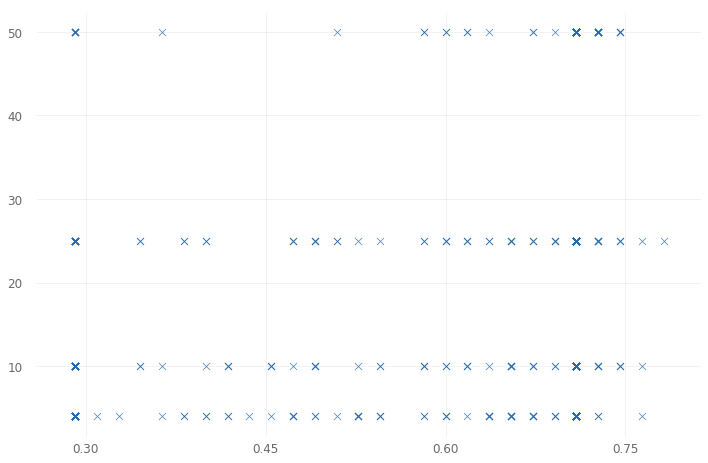

In [23]:
# a regression plot for two dimensions 
r.plot_regs("val_acc", "epochs")

None


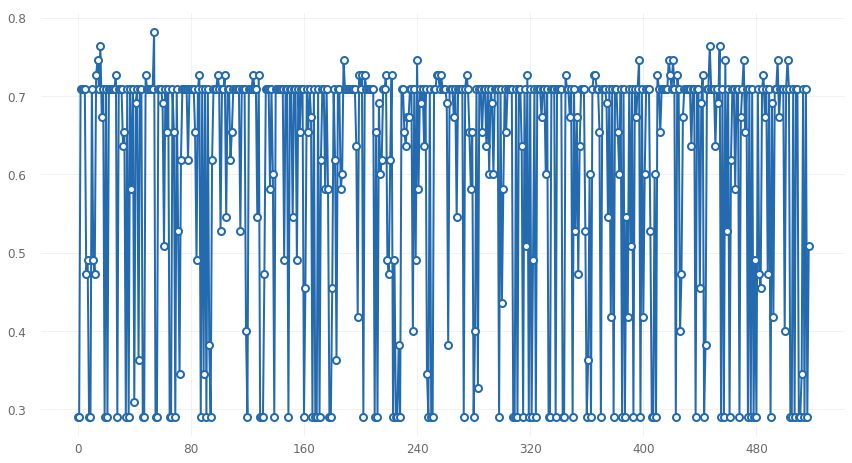

In [24]:
# line plot
print(r.plot_line("val_acc"))

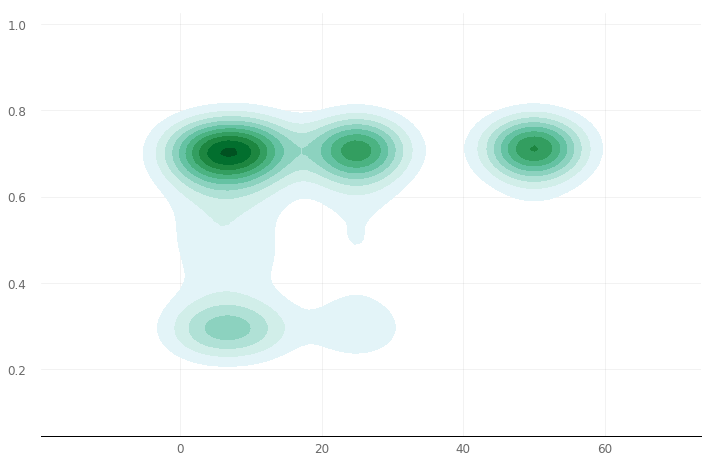

In [25]:
# up to two dimensional kernel density estimator
r.plot_kde("epochs","val_acc")

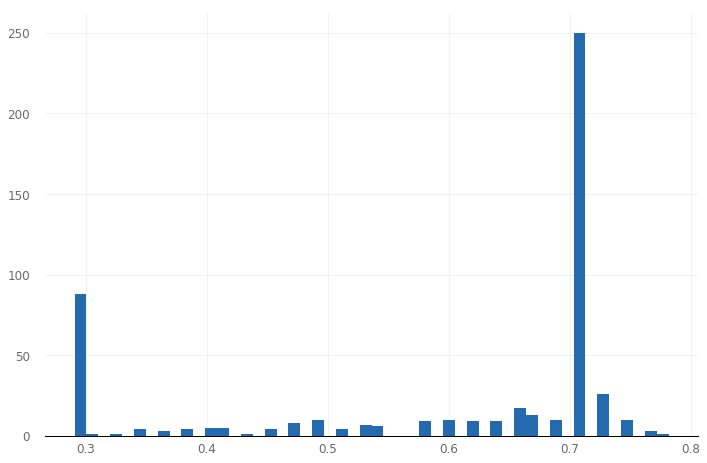

In [26]:
# a simple histogram
r.plot_hist(bins=50)

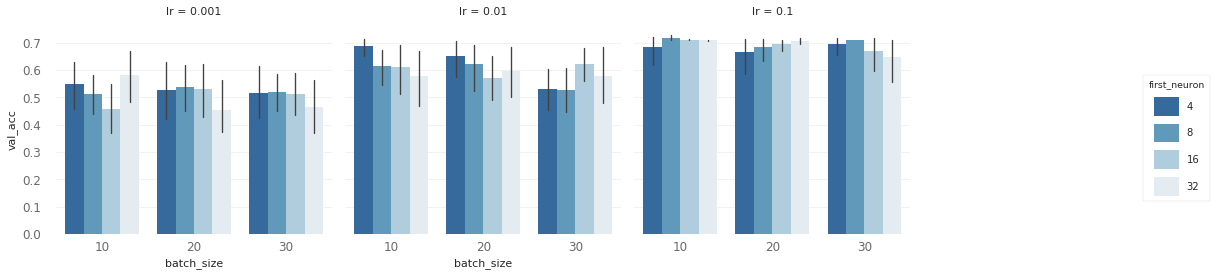

In [27]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

## Evaluating models
Models can be evaluated with Evaluate() against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the Scan process and only exposed into Evaluate once one or more candidate models have been identified.

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/evaluate.py


In [29]:
# k-fols crossvalidation with 10 folds, from test data
# we're going to validate using the f-measure or harmonic mean since 
# combines precision and recall (optimize on that)
# https://en.wikipedia.org/wiki/Precision_and_recall#F-measure

e = ta.Evaluate(h)

e.evaluate(x=x_test, y=y_test,
           folds=10,
           shuffle=True,
           metric='val_fmeasure_acc',
           mode='binary',
           print_out=True)

mean : 0.39 
 std : 0.31


[0.5, 0.4, 0.0, 0.5, 0.0, 0.7499999999999999, 0.0, 1.0, 0.4, 0.4]

## Deploying models

Once the right model or models have been found, you can create a deployment package with Deploy() which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of:

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/deploy.py

In [34]:
# By default selects the model with best validation accuracy "val_acc"
# Other metrics can be specified
ta.Deploy(h, 'drawings-exp1', metric='val_fmeasure_acc');

Deploy package drawings-exp1 have been saved.


## Restoring models
Restores the scan_object that had been stored locally as a result of talos.Deploy

**See source code at** https://github.com/autonomio/talos/blob/daily-dev/talos/commands/restore.py 

In [0]:
# Restore model from local environment
drawings = ta.Restore('drawings-exp1.zip')

In [36]:
# make predictions with the model
drawings.model.predict(x_test)[0:9,] # print first 10

array([[0.49945515],
       [0.4994005 ],
       [0.4996532 ],
       [0.50004065],
       [0.4994038 ],
       [0.5009882 ],
       [0.5002824 ],
       [0.5001683 ],
       [0.49973464]], dtype=float32)

In [37]:
# get the meta-data for the experiment/optimization
print(drawings.details)

                      0                 1
0         random_method  uniform_mersenne
1      reduction_method               NaN
2    reduction_interval                50
3      reduction_window                20
4       grid_downsample              0.05
5   reduction_threshold               0.2
6      reduction_metric           val_acc
7           reduce_loss             False
8       experiment_name     041519170634_
9         complete_time    04/15/19/17:23
10              x_shape        (180, 200)
11              y_shape            (180,)


In [38]:
# get the hyperparameter space boundary for the experiment/optimization
print(drawings.params)

OrderedDict([('first_neuron', [4, 8, 16, 32]), ('activation', [<function relu at 0x7faf18dfb730>, <function sigmoid at 0x7faf18dfb840>]), ('optimizer', [<class 'keras.optimizers.Nadam'>, <class 'keras.optimizers.Adam'>]), ('losses', [<function binary_crossentropy at 0x7faf18e49840>]), ('hidden_layers', [0, 1, 2]), ('batch_size', [10, 20, 30]), ('epochs', [4, 10, 25, 50]), ('dropout', [0, 0.1, 0.2]), ('kernel_initializer', ['uniform', 'normal']), ('lr', [0.001, 0.01, 0.1]), ('last_activation', ['sigmoid'])])


In [39]:
# sample of x and y data, returns pandas dataframe
print(drawings.x.iloc[0:3, 0:3]) # print first 3 rows and columns
print(drawings.y.iloc[0:3]) # print first 3 rows 

          0         1         2
0  0.062465  0.136851 -0.207642
1  0.033932 -0.000115  0.011956
2 -0.120049 -0.053225  0.070037
     0
0  0.0
1  0.0
2  0.0


In [40]:
# the results dataframe
drawings.results[0:3] # print first 3 rows

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation,Unnamed: 19
0,10,0.698434,0.290909,0.450051,0.700725,0.200,0.282903,8,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,2,30,10,0.1,uniform,0.001,sigmoid,0
1,50,0.697053,0.290909,0.450051,0.699479,0.200,0.291325,4,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7faf18e49840>,1,30,50,0.1,uniform,0.010,sigmoid,1
2,4,0.690835,0.709091,0.000000,0.689561,0.832,0.000000,4,<function sigmoid at 0x7faf18dfb840>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7faf18e49840>,2,10,4,0.0,normal,0.010,sigmoid,2


# Resources
- **Talos repo**: https://github.com/autonomio/talos
- **Talos example**:  https://nbviewer.jupyter.org/github/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20on%20Keras%20with%20Breast%20Cancer%20Data.ipynb